Lane Following Problem
===========================

The dynamics model of an omnidirectional vehicle with no friction is defined by the following equation:

$$
\dot{p}^x(t) = (v_k + \dot{v}_k(t-T_s k))cos(\theta_k + \theta_k(t - T_sk))
$$
$$
\dot{p}^y(t) = (v_k + \dot{v}_k(t - T_s k))sin(\theta_k + \theta_k(t - T_s k))
$$

iLQR is applied to a vehicle in order to control them to follow a reference trajectory at a terminal velocity of $10 m/s$.

The state vector $\textbf{x}$ is defined as follows:
$$\begin{equation*}
\textbf{x} = \begin{bmatrix}
    p^x & p^y & v & \theta
    \end{bmatrix}^T
\end{equation*}$$

The action vector $\textbf{u}$ is defined as follows:
$$\begin{equation*}
\textbf{u} = \begin{bmatrix}
   \dot{v} & \delta
    \end{bmatrix}^T
\end{equation*}$$

**Note**: That since this dynamics model is nonlinear, this problem can be solved
more efficiently with a simple Linear Quadratic Regulator (LQR) instead. This
example is just used to demonstrate how to setup an auto-differentiated
dynamics model.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import sys
import os
sys.path.append(os.path.abspath('../'))
import random
import ilqr
import math

In [3]:
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt


In [4]:
from ilqr import iLQR
from ilqr.cost import PathQRCost
from ilqr.examples.car import CarDynamics, CarCost

from bc import *
import pickle

In [74]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    final_control = us[-1]
    if iteration_count % 60 == 0:
        print("iteration", iteration_count, info, J_opt, final_state, final_control)


In [75]:
dt = 0.05
wheel_diameter = 1.0
dynamics = CarDynamics(dt, l=wheel_diameter)

An instantaneous cost function $l(\textbf{x}_t, \textbf{u}_t)$ is defined as follows:

$$
l(\textbf{x}_t, \textbf{u}_t) = \textbf{x}_t^T Q \textbf{x}_t + \textbf{u}_t^T R \textbf{u}_t
$$

where $Q$ is the state error and $R$ is the control error.

In order to approach the two vehicles to each other, $Q$ is set up to penalize differences in positions as $||\textbf{x}_0 - \textbf{x}_1||^2$ while penalizing non-zero velocities.

The following code generates the lane and boundaries. There are 150 way points along the reference trajectory. The boundary is +-3 vertically away from the reference trajecotry.S

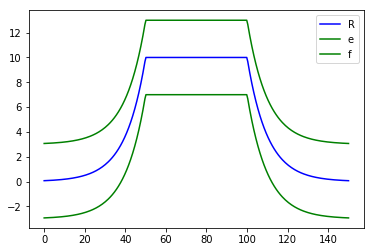

In [123]:
def lane(posx):
    ts = [50, 100, 150]
    rate = 10.0
    height = 10.0
    if posx <= ts[0]:
        return height * np.exp((posx - ts[0])/rate), np.arctan(height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1] and posx <= ts[2]:
        return height * np.exp((ts[1] - posx)/rate), np.arctan(- height * np.exp((ts[1] - posx)/rate))

def nominal(posx):
    ts = [50, 100, 150]
    rate = 10.0
    height = 10.0
    if posx <= ts[0]:
        return height * np.exp((posx - ts[0])/rate), np.arctan(height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1]:
        return height * np.exp((ts[1] - posx)/rate), np.arctan(- height * np.exp((ts[1] - posx)/rate))

posx_path = np.linspace(0, 150, 300)
x_path = [[posx_path[i], lane(posx_path[i])[0], 10, lane(posx_path[i])[1]] for i in range(300)]


posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend("Reference Path")

# Instantenous state cost.
Q = np.eye(dynamics.state_size)
Q[3, 3] = 0.0


R = np.eye(dynamics.action_size)
R[0, 0] = 1.0
R[1, 1] = 1.0

barriers = np.array([0, 1, 0, 0]) 

q = np.zeros((dynamics.state_size, 1))
r = np.zeros((dynamics.action_size, 1)) 
A = np.array([[[0, 1, 0, 0]], [[0, -1, 0, 0]]])
b = np.array([[3.0], [3.0]])
q1 = [1., 1.]
q2 = [0.1, 0.1]
#A = np.array([[[0, 1, 0, 0]]])
#b = np.array([11])

Now use iLQR to solve this trajectory following problem. Safety constraint is added such that the vehicle stay within the boundaries. The vehicles are initialized at $(0, 0)$ with velocities $10$. The look ahead horizon is 30.

In [124]:
N = len(x_path)
n = 30  # Number of time steps in trajectory.
J_hist = []
expert_traj = []

x0 = x_path[0]  # Initial state.
# Random initial action path.
#us_init = np.random.uniform(-1, 1, (n - 1, dynamics.action_size))
us_init = np.zeros((n - 1, dynamics.action_size))

for i in range(0, int(N - n) + 1):
    k = 3
    if i % k != 0:
        continue
        #pass
    x_path_ = x_path[i: i + n]
    cost = CarCost(Q = Q, q = q, R = R, r = r, A = A, b = b, q1 = q1, q2 = q2, x_path = x_path_, x_nominal = nominal)
    ilqr = iLQR(dynamics, cost, n - 1)
    xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)

    x0 = xs[k][:]
    expert_traj = expert_traj + [[xs[i], us[i]] for i in range(k)]

iteration 0 accepted [0.03292936] [14.50766651  0.28096542 10.00794981  0.02042199] [-0.00055076 -0.00342138]
iteration 0 accepted [0.04187392] [16.01045392  0.32658729 10.00980158  0.02368335] [-0.00061807 -0.00401498]
iteration 0 accepted [0.05289182] [17.51329384  0.37960559 10.01158091  0.02759549] [-0.00068149 -0.00461854]
iteration 0 accepted [0.06642373] [19.0160863   0.44123061 10.0132869   0.03210293] [-0.00074111 -0.00534861]
iteration 0 accepted [0.08314541] [20.51871719  0.51285888 10.01493066  0.03731634] [-0.00079779 -0.00621575]
iteration 0 accepted [0.10405329] [22.02104258  0.5961104  10.0165301   0.04337091] [-0.00085269 -0.00722755]
iteration 0 accepted [0.1305735] [23.52287575  0.69286643 10.0181097   0.05040906] [-0.00090721 -0.00840332]
iteration 0 accepted [0.16471202] [25.02397219  0.80531071 10.01970252  0.05859064] [-0.00096313 -0.0097695 ]
iteration 0 accepted [0.20926775] [26.52400896  0.93597651 10.0213527   0.0680986 ] [-0.00102268 -0.01135887]
iteration 0

KeyboardInterrupt: 

The result can be visulized by executing the following code.

In [125]:
X = []
Y = []
posx = []
posy = []
v = []
theta = []

for i in expert_traj:
    posx.append(i[0][0])
    posy.append(i[0][1])
    v.append(i[0][2])
    theta.append(i[0][3])



posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]

#pickle.dump((X, Y), open('expert_traj.p', 'wb'))

The red curve in this plot is the trajecotry of the MPC vehicle. 

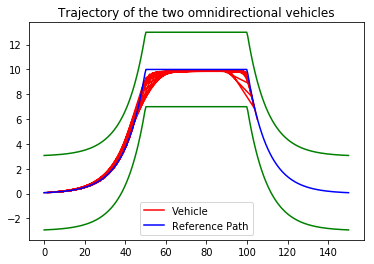

In [126]:

_ = plt.title("Trajectory of the two omnidirectional vehicles")
_ = plt.plot(posx, posy, "r")

_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend(["Vehicle", "Reference Path"])

In [12]:
N = len(x_path)
H = 30  # Number of time steps in trajectory.
J_hist = []
expert_pts = []


num_pts = 50000
for pt in range(num_pts):
    x0 = [] # Initial state.
    i = random.randint(0, len(x_path) - H - 1)
    x0 = [x_path[i][0], \
          x_path[i][1] + 3.0 * (2 * random.random() - 1.0), \
          x_path[i][2] + 1.0 * (2 * random.random() - 1.0), \
          x_path[i][3] + 2.0 * (2 * random.random() - 1.0)]

    # Random initial action path.
    us_init = np.random.uniform(-1, 1, (H - 1, dynamics.action_size))
    #us_init = np.zeros((N, dynamics.action_size))
    print("Point %d" % pt)
    x_path_ = x_path[i: i + H]
    cost = CarCost(Q = Q, q = q, R = R, r = r, A = A, b = b, q1 = q1, q2 = q2, \
                   x_path = x_path_, x_nominal = nominal)
    ilqr = iLQR(dynamics, cost, H - 1)
    xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)

    x = [x0] + x_path_[0:H]
    u = us[0]
    expert_pts = expert_pts + [[x, us[0]]]


Point 0
iteration 0 accepted [1462.83734567] [96.57806656 11.94802197 10.27914572 -2.38091504] [0.00100721 0.91862991]
iteration 60 accepted [108.34298979] [104.49845238   6.40006466  10.75806122  -6.82126375] [-3.44459540e-02  4.33133737e-05]
Point 1
iteration 0 accepted [919.47748508] [132.88799952   4.23993214  10.22457863   1.03875055] [-0.01558491  1.0976912 ]
iteration 60 accepted [49.9504234] [ 1.40194874e+02  1.74219399e-01  1.03933229e+01 -8.32301695e-02] [-1.9059619e-02  1.9157346e-05]
Point 2
iteration 0 accepted [2189.95738106] [16.68048624 -3.94020197  9.53981106  5.11856046] [0.07045297 0.61273893]
iteration 60 accepted [130.62707308] [26.75815608  0.83295522  9.86947642  6.44731091] [1.07463415e-02 3.06335025e-07]
Point 3
iteration 0 accepted [1665.41757729] [93.57450228 11.24374771  9.90542804 -3.13249621] [-0.17597267  0.40837594]
iteration 60 accepted [126.50211854] [103.35536566   6.55367427  10.43664648  -6.84449682] [-2.1001620e-02 -7.1355548e-05]
Point 4
iteration

Point 48
iteration 0 accepted [3546.79193348] [113.08825305   7.35424782   9.55696151  -8.789811  ] [-0.06501689  1.11178633]
iteration 60 accepted [663.23191103] [120.31209805   1.34148276  10.10824196  -7.02799576] [ 0.00278314 -0.00747533]
Point 49
iteration 0 accepted [1578.86626522] [18.7371949  -1.96474462 10.32135661  6.02763738] [-0.01971378  1.96780218]
Point 50
iteration 0 accepted [118.20809353] [124.47609407   1.78110389   9.82016741   0.33128043] [-0.12749198  0.10279797]
Point 51
iteration 0 accepted [439.78321109] [69.33984654  6.13091851 10.45805556  4.6302556 ] [-0.01560679  0.04894753]
Point 52
iteration 0 accepted [501.65383415] [ 7.92653973 -2.83400552  9.61047462  2.7590896 ] [ 0.00399041 -1.74749626]
Point 53
iteration 0 accepted [1057.06896528] [47.01936844  9.2539438  10.11301757  6.31120206] [-0.06279119 -0.49846066]
Point 54
iteration 0 accepted [102.96197419] [140.17033826  -1.35438359  10.03363948  -1.86244528] [ 0.18532346 -0.41971683]
Point 55
iteration 0 

/home/depend/workspace/MPSC_Guided_Imitation_Learning/ilqr/ilqr/controller.py:168: UserWarning: exceeded max regularization term
  warnings.warn("exceeded max regularization term")


Point 73
iteration 0 accepted [752.89853412] [53.45984535 11.68279761 10.05380783 -2.20416765] [0.01455692 0.89160739]
Point 74
iteration 0 accepted [557.56058012] [97.49544332 11.1188251  10.49503241 -1.19591303] [0.00216909 0.89681105]
Point 75
iteration 0 accepted [648.9101386] [7.49841535e+01 1.36082768e+01 1.03208486e+01 5.02911611e-02] [-0.0205331  -1.48318982]
Point 76
iteration 0 accepted [2849.86410062] [15.69579743 -6.70340024 10.25586075 -5.83565463] [0.00295882 2.92679878]
Point 77
iteration 0 accepted [2598.19006135] [96.23209423  7.11042111 10.51627415  9.7721395 ] [-0.017646   -3.21332473]
iteration 60 accepted [220.33487516] [106.15308458   5.29171664  11.05889697  12.16526626] [-0.04778091  0.        ]
Point 78
iteration 0 accepted [657.79507625] [82.98976832  8.56840779 10.12276839  0.15741284] [0.00358273 0.91671598]
Point 79
iteration 0 accepted [602.37810611] [15.59835628  0.06013024  9.33738542  5.52882922] [ 0.52699144 -0.49368406]
iteration 60 accepted [134.4852

iteration 60 accepted [139.13497677] [87.69449883  9.61073426 10.57689695 11.50414269] [-2.42406254e-02 -1.25961565e-05]
Point 122
iteration 0 accepted [363.27306907] [137.03459675  -0.6994074   10.13681299  -1.30821032] [ 0.25442942 -0.63915245]
Point 123
iteration 0 accepted [2279.2926375] [26.50056526  4.68885527 10.03501797 -5.36437686] [0.00686319 2.6155785 ]
iteration 60 accepted [447.06193686] [33.33907828  2.88442194 10.90753869 -6.18187143] [-0.0387321   0.00094119]
Point 124
iteration 0 accepted [3269.03910326] [92.4676938  11.38375845  9.49287852 -3.6023196 ] [0.01351569 0.7476323 ]
iteration 60 accepted [234.49806256] [102.55991672   7.33558482  10.35183918   5.78366251] [-1.29827746e-02 -3.01283255e-05]
Point 125
iteration 0 accepted [840.82473257] [67.32534044  6.96093281  9.82359577  0.22081603] [0.02227384 1.40670843]
Point 126
iteration 0 accepted [2077.51885684] [ 63.12417553  10.67359782  10.11803382 -13.81223325] [0.30743326 0.93035007]
iteration 60 accepted [285.08

Point 169
iteration 0 accepted [1148.62375771] [80.2731101  11.30711002 10.48173288 -0.34051801] [7.29066388e-04 1.69184266e+00]
Point 170
iteration 0 accepted [2306.49463233] [51.37537577  7.53904806  9.48403233  7.54898523] [ 0.0366717  -0.62479232]
iteration 60 accepted [68.51343499] [63.00179961  9.97875076  9.92246901  0.22687522] [ 4.42937441e-03 -6.05732196e-07]
Point 171
iteration 0 accepted [2258.09663764] [133.90184537  -1.7522599   10.41308654  -8.86460207] [-0.01550719 -0.35422149]
iteration 60 accepted [165.76295543] [1.43014563e+02 3.18888265e-02 1.09009187e+01 2.02708821e-02] [-4.06813806e-02 -5.73142366e-05]
Point 172
iteration 0 accepted [1795.52192129] [ 6.68137424  1.52285405  9.54026018 10.50877095] [-0.00595777 -2.65728672]
iteration 60 accepted [148.54950662] [16.05624636  0.30248167  9.78890049  6.33485475] [1.43158242e-02 1.69928848e-05]
Point 173
iteration 0 accepted [647.41723832] [137.28348019  -3.01035455   9.87613282   6.62825959] [-0.14165969  0.36497404]


Point 216
iteration 0 accepted [2083.16405549] [55.0721251  13.76630943 10.44731371  3.69946307] [-0.02302982 -3.02521552]
iteration 60 accepted [70.11304992] [66.19134226  9.96572711 10.67320504 -6.28790306] [-3.23354719e-02  1.37526690e-07]
Point 217
iteration 0 accepted [3566.90622603] [104.43915686   8.41813771   9.59971731   6.63106926] [ 0.09873158 -3.44483703]
iteration 60 accepted [276.03141251] [116.30258871   2.16778838  10.03951718  -6.51590448] [5.62325565e-04 5.65925016e-07]
Point 218
iteration 0 accepted [3106.27649421] [115.41245952   3.94534291   9.47954115   4.07196876] [-0.20831812 -2.72285496]
Point 219
iteration 0 accepted [3207.23786613] [19.49281524 -1.03886553  9.58824487  6.00890099] [ 0.02347715 -2.8901059 ]
iteration 60 accepted [231.56509965] [30.57874782  1.32062567 10.06647981  6.48368456] [5.06569635e-04 8.24350481e-06]
Point 220
iteration 0 accepted [2312.20056572] [134.57595986   1.402491     9.66730535  -0.74275983] [ 0.00818259 -2.9396994 ]
Point 221
i

Point 264
iteration 0 accepted [1700.85555616] [131.8154997    5.75555226  10.21487272   0.45676262] [0.00566046 0.0537327 ]
iteration 60 accepted [74.77575143] [141.38727989   0.26671775  10.5297368   -6.3609447 ] [-2.38537346e-02 -2.57040474e-07]
Point 265
iteration 0 accepted [2232.32544874] [115.35209841  -0.30666787  10.15900328  -2.44352544] [0.15869672 2.80324026]
iteration 60 accepted [112.22778563] [127.16866118   0.72882443  10.59614715   6.19490747] [-0.02697299 -0.00012176]
Point 266
iteration 0 accepted [666.08940029] [38.920463    0.6277106   9.63251111  4.64422532] [-0.18779809  0.58647709]
iteration 60 accepted [31.21272436] [45.42827831  6.39143308  9.93699057  0.49643143] [0.00443884 0.        ]
Point 267
iteration 0 accepted [2624.14542991] [90.54698497  9.71429609  9.17707692 -6.01570295] [0.03153429 0.87312199]
iteration 60 accepted [167.81418346] [99.92565369  8.74114832  9.92731307 -6.71851518] [8.34975064e-03 2.38411116e-05]
Point 268
iteration 0 accepted [1094.

iteration 60 accepted [176.04747378] [20.62883203  0.33996057  9.86793566  6.40046282] [ 0.01090883 -0.00015007]
Point 310
iteration 0 accepted [2307.35126673] [ 89.6985963   13.7682824   10.34094001 -10.06086208] [0.00291444 1.90894461]
iteration 60 accepted [21.9128476] [102.05458636   8.12152157  10.33480187  -0.70770542] [-0.01626835  0.        ]
Point 311
iteration 0 accepted [1098.40644803] [49.08530653  9.07692378  9.63254264 -4.94777527] [0.00881273 2.48627003]
Point 312
iteration 0 accepted [3115.71204381] [81.44151054 13.30208878  9.48713097 -0.33600802] [ 0.01470843 -0.02535822]
iteration 60 accepted [376.72818543] [89.3308269  10.41029149  9.80325308 -1.54152357] [0.0162962  0.00043596]
Point 313
iteration 0 accepted [2723.21628973] [27.51090132  4.25438289  8.81364956  1.32161315] [0.06060723 0.90693561]
iteration 60 accepted [181.44426014] [36.97397532  3.02607697  9.77549898  6.49706803] [0.01526446 0.        ]
Point 314
iteration 0 accepted [3275.82350656] [20.99258254 

Point 360
iteration 0 accepted [237.11401613] [36.29627217  1.6856103   9.69314107 -0.96678654] [0.010758   0.93710131]
Point 361
iteration 0 accepted [593.55344637] [60.98701001  8.32618405  9.55563464  0.72198392] [0.21737136 0.04879904]
Point 362
iteration 0 accepted [1775.27911681] [61.006403   10.44081005 10.16293328  2.89085117] [ 0.00626112 -1.81850241]
Point 363
iteration 0 accepted [2133.3292246] [ 3.63316547 -1.22865548  9.43837861  0.05047731] [0.02475204 0.66622804]
Point 364
iteration 0 accepted [2888.22409342] [81.3608297  12.057448    9.96573405 -6.21605814] [-5.90141076e-04  1.23726796e+00]
Point 365
iteration 0 accepted [2378.58499991] [42.81906349  3.42870271 10.01209338 -5.84932359] [0.01293714 3.1142667 ]
Point 366
iteration 0 accepted [1931.17625741] [54.76370939  7.45454205  9.87219705 -5.02490004] [0.01337813 2.23411659]
Point 367
iteration 0 accepted [3641.52026669] [104.01353439   9.24221156   9.45299946  -8.22381487] [0.01516559 2.74752442]
iteration 60 accept

Point 408
iteration 0 accepted [42.53173057] [92.66853352  9.82727656 10.53625394  0.57587292] [-0.00941494  0.3799202 ]
iteration 60 accepted [33.17684461] [9.35388956e+01 9.96759214e+00 1.04957153e+01 1.10983865e-02] [-0.02505492  0.        ]
Point 409
iteration 0 accepted [3045.47725882] [87.63747439  9.12482968  9.799098   -6.30809114] [-0.00645581  1.28852111]
iteration 60 failed 50.4875576807034 [101.86720734   8.14514741  10.04059568  -0.57727093] [-0.00056386  0.        ]
Point 410
iteration 0 accepted [3292.93572612] [108.70649468  10.36431495  10.44128117  -1.4149561 ] [ 0.1819127  -1.05722809]
iteration 60 accepted [592.56267173] [116.53538159   2.53226747  11.00677942  -0.28528679] [-0.04410106 -0.006669  ]
Point 411
iteration 0 accepted [3202.96003556] [79.59556334 11.82486676  9.56382665  2.3397205 ] [ 0.00864591 -1.75202501]
iteration 60 accepted [215.60728683] [90.52735694 10.09166361 10.08839539  6.2468844 ] [-0.00030983  0.        ]
Point 412
iteration 0 accepted [414

Point 459
iteration 0 accepted [2832.54671577] [79.17561766 10.93082471  9.91139625 -3.58193636] [0.00443001 2.76688808]
iteration 60 accepted [122.39396708] [91.69216926  9.95706779 10.54960354 -6.28221171] [-0.02481357  0.        ]
Point 460
iteration 0 accepted [2293.67290996] [ 4.63172517  3.35721705 10.16874334  2.1661925 ] [-0.00949089 -0.43157253]
iteration 60 accepted [270.53732508] [14.52919167  0.54954101 10.7997454  -0.04748404] [-0.03553603  0.00017437]
Point 461
iteration 0 accepted [3730.35876409] [100.03069024   8.9230788   10.18641407   7.51791814] [0.01165769 3.28508854]
iteration 60 accepted [210.80361204] [110.97180666   3.71835468  10.67989157   6.19342663] [-0.0326045  -0.00036858]
Point 462
iteration 0 accepted [661.67862901] [72.36296315 10.36753375  9.39436227  1.26536613] [ 0.30971687 -1.06400335]
Point 463
iteration 0 accepted [156.44358321] [56.1055535   8.96562487 10.5274245   1.25846217] [-0.27180676  0.49630686]
Point 464
iteration 0 accepted [2371.5118872

Point 508
iteration 0 accepted [4228.20761211] [97.88326639 11.44718607  9.4736483   2.7510587 ] [0.01372765 2.16644448]
Point 509
iteration 0 accepted [2144.39118363] [21.61402394  0.23175701  9.29699992 -0.75210462] [0.02340204 1.5207915 ]
iteration 60 accepted [204.27396086] [31.09837238  1.45483391 10.04893681 -6.0923912 ] [0.00139183 0.        ]
Point 510
iteration 0 accepted [251.17227492] [81.56124872  9.5386938  10.09283029  3.40251459] [-0.23153281  0.66515487]
Point 511
iteration 0 accepted [1785.65228958] [130.10250601   1.96547238  10.08533965   3.62179479] [ 0.00451131 -1.2706175 ]
Point 512
iteration 0 accepted [456.42681696] [114.937717    -1.40573612  10.27600109   1.34316998] [-0.23692006  0.72410262]
Point 513
iteration 0 accepted [2160.36331478] [14.69912679 -0.49904753 10.1715993   2.48942376] [-0.12803378 -2.20257137]
Point 514
iteration 0 accepted [1131.11420977] [41.58088894  4.30334187  9.61464434 -2.28024201] [ 0.03426198 -0.66586567]
iteration 60 accepted [58.

iteration 60 accepted [271.84112597] [44.52499268  6.44995307  9.89231168  6.70903016] [0.00969275 0.        ]
Point 559
iteration 0 accepted [1978.17074467] [117.5032108    3.75111556  10.20168112   1.43519418] [-0.00922981  0.3161381 ]
iteration 60 accepted [83.77237169] [127.37625832   0.45520243  10.61062152   6.16494146] [-2.73292279e-02  5.51863622e-06]
Point 560
iteration 0 accepted [2773.59276725] [42.71395188  5.04698766  9.42793618 -3.42318652] [0.03088456 1.79774069]
iteration 60 accepted [174.35219019] [52.78428609  9.7429947   9.7825544  -6.21946803] [1.50935519e-02 3.10670534e-07]
Point 561
iteration 0 accepted [3082.55877006] [ 1.89123629e+01 -4.65303236e-03  9.90793881e+00 -1.81487691e+01] [0.01929688 3.04075916]
Point 562
iteration 0 accepted [4063.70589951] [41.16004582  4.6129081   8.84230543 -3.20957655] [0.03982826 0.37991915]
iteration 60 accepted [479.9875507] [51.3576729   8.51362843  9.9609611   6.60217986] [ 0.00689454 -0.00509653]
Point 563
iteration 0 accept

Point 606
iteration 0 accepted [2309.99474709] [126.44002157  -0.60955597   9.69127049   0.27746745] [ 0.01326568 -0.41396251]
iteration 60 accepted [453.67672409] [ 1.34394176e+02 -1.36280825e-01  1.00923644e+01  9.39266444e-02] [2.35837887e-04 3.36159232e-05]
Point 607
iteration 0 accepted [500.83609418] [40.11060885  1.71220029 10.41825412  3.62267671] [-0.01793741  0.56127192]
Point 608
iteration 0 accepted [2273.64737311] [ 5.55684685  1.73840908  9.59527778 -5.17568618] [0.01306213 2.89358121]
iteration 60 accepted [252.84766782] [15.40076541  0.49559229 10.06287617 -6.29309664] [ 7.89000995e-04 -1.04648562e-06]
Point 609
iteration 0 accepted [672.52107184] [131.70836269  -0.88823719  10.4934859   -5.9231675 ] [-0.23090007  0.45853572]
iteration 60 accepted [128.61304224] [137.74269392   0.19315322  10.75141064  -6.28373125] [-0.03549487  0.00024858]
Point 610
iteration 0 accepted [1470.70899792] [23.62178367  1.12807244 10.22488125 -1.82995934] [ 0.05163823 -0.53645436]
Point 61

iteration 60 accepted [87.65974261] [65.57006311 10.0445719   9.96433165 -6.32145196] [ 5.11412070e-03 -1.00794956e-05]
Point 659
iteration 0 accepted [503.11969324] [76.34605961  9.67995178 10.2904817   1.27640779] [0.36180021 0.4526775 ]
Point 660
iteration 0 accepted [2446.3314415] [110.49621889   6.2286155   10.17988691  -3.21625945] [-0.00428953  2.47912521]
iteration 60 accepted [162.84668679] [121.90683094   1.26392856  10.78715903   6.106424  ] [-0.03676151  0.        ]
Point 661
iteration 0 accepted [156.47175937] [93.3213376   9.18928484 10.14344915  1.12013537] [0.13580207 0.3714144 ]
Point 662
iteration 0 accepted [1960.43011755] [43.03782725  1.18365947  9.64891064  2.47355413] [0.01216798 1.89349779]
iteration 60 accepted [240.41932884] [47.54046803  8.01355228 10.19725657  6.78420489] [-0.00502673  0.00074026]
Point 663
iteration 0 accepted [2102.6262901] [92.87717056  5.96060254  9.57956321  4.59110269] [-0.25017533  1.71122614]
Point 664
iteration 0 accepted [3773.7572

iteration 60 accepted [206.56189167] [56.76636648  9.82275016 10.88098572  0.10344059] [-4.20239078e-02 -5.02974809e-05]
Point 708
iteration 0 accepted [1279.0075149] [26.3278167  -2.83673886  9.78837479  3.29787205] [-0.06523944 -1.69546805]
Point 709
iteration 0 accepted [2115.03392011] [31.73586161 -0.2536246   9.71144683  1.25249162] [3.06386595e-03 3.16879171e+00]
Point 710
iteration 0 accepted [5393.50451045] [3.52570609 1.4523397  9.35521762 5.58168308] [ 0.02798277 -1.06381888]
Point 711
iteration 0 accepted [2003.28865761] [ 1.17277648e+02 -8.38063372e-02  1.00102728e+01  3.35981487e+00] [0.01889383 2.08682065]
iteration 60 accepted [98.14220108] [130.56194055   0.48755373  10.37162337   6.23152607] [-0.01623205  0.00075221]
Point 712
iteration 0 accepted [462.63721938] [92.95773148  7.82772784 10.67580534 -0.31105229] [-0.17331199  1.07774208]
Point 713
iteration 0 accepted [2761.17119068] [21.33378784  0.19678381 10.11210406  2.99778492] [-0.00997156  0.87450259]
Point 714
i

iteration 60 accepted [107.40823034] [67.10124144  9.97739342 10.72155854 -6.29858324] [-3.46503306e-02  7.31680196e-06]
Point 754
iteration 0 accepted [434.36572939] [53.45176379  8.92003725  9.97014795  0.30898541] [ 0.10413282 -0.18616443]
Point 755
iteration 0 accepted [787.86591368] [60.23725926  5.62907625  9.67347538  4.1622806 ] [ 0.00600333 -2.40797054]
Point 756
iteration 0 accepted [943.24516722] [137.71985374  -1.43465513   9.63440754   4.57707435] [0.02480511 0.76998905]
iteration 60 accepted [93.30526539] [1.45916877e+02 3.51590574e-02 9.96272492e+00 6.30258611e+00] [5.07186505e-03 7.17873412e-05]
Point 757
iteration 0 accepted [3391.506035] [29.74558166  2.74179361 10.15268112 -0.61730072] [-0.01491386 -1.29850364]
iteration 60 accepted [198.49742335] [39.7187815   4.35352295 10.77823387  0.72416158] [-3.3266643e-02 -1.9917318e-05]
Point 758
iteration 0 accepted [2365.24308112] [45.01160595 12.04858712  9.57256432  7.2017537 ] [-0.05095494 -1.50134355]
iteration 60 accep

Point 799
iteration 0 accepted [2182.9952184] [18.30743775  4.90482924  9.96044693 -4.62422605] [ 0.01658086 -1.2151788 ]
Point 800
iteration 0 accepted [1137.86747296] [41.27900352  2.44298852 10.31483792 -3.72621887] [1.98746779e-03 2.35149442e+00]
Point 801
iteration 0 accepted [1847.47588632] [22.46424411 -3.11931941 10.62946302 -1.24711018] [0.16627223 1.8356301 ]
Point 802
iteration 0 accepted [2265.45364106] [27.92857638  1.48207484  9.64720368  1.64729871] [-0.0501437   2.06684345]
Point 803
iteration 0 accepted [223.41810372] [98.93505817  7.23786417  9.61536697 -2.04269099] [ 0.23502727 -0.52919062]
Point 804
iteration 0 accepted [1667.36555608] [48.16430346  3.46550981  9.64800751 -3.94128658] [ 0.71810793 -0.50773597]
Point 805
iteration 0 accepted [905.1420963] [ 4.67494324  0.88700506 10.30210136  1.20330196] [-0.00260843 -1.37610084]
Point 806
iteration 0 accepted [1861.40342339] [77.22847708 12.66670541 10.44783605 -3.61562509] [-0.00556201 -1.64469317]
iteration 60 acc

Point 848
iteration 0 accepted [708.81067802] [136.35251151  -2.81224435   9.40834263   0.81456569] [0.10781186 0.86624597]
Point 849
iteration 0 accepted [2832.19414136] [ 7.59955601 -2.17157999  9.57076651 -2.09534317] [ 0.01873801 -2.09155759]
iteration 60 accepted [503.02656225] [ 16.98268206  -0.19346886  10.19361127 -12.41439559] [-0.00347913 -0.00150173]
Point 850
iteration 0 accepted [1089.97071324] [43.892339    3.33617328  9.51143524 -0.90431342] [0.08874955 1.40974796]
Point 851
iteration 0 accepted [3695.78594278] [95.3492854  10.14474174  9.66003972  3.84774771] [ 0.01925975 -2.17046728]
iteration 60 accepted [158.76999742] [105.98741516   5.94034096  10.04403776  -6.71062378] [0.00336516 0.00028999]
Point 852
iteration 0 accepted [2899.97121729] [32.42572427  0.94524123  9.12873108 -6.07128417] [0.02182443 3.36390558]
iteration 60 accepted [218.56269045] [40.94426986  4.5575881   9.91219057 -5.12808047] [0.01024854 0.00035856]
Point 853
iteration 0 accepted [2262.79580223

Point 897
iteration 0 accepted [2370.88120967] [135.13327935   1.51438462   9.00286133   2.94805634] [0.03054582 0.72211881]
Point 898
iteration 0 accepted [2256.51582073] [85.14349968  9.93425371 10.56577884  5.06494682] [ 0.19296741 -1.17748348]
iteration 60 accepted [25.49511443] [9.80248971e+01 9.96432165e+00 1.03769330e+01 1.46208286e-03] [-0.01908821  0.        ]
Point 899
iteration 0 accepted [3027.64652994] [80.51163322 10.77207802 10.10069032 -0.22188404] [0.0130593 1.1895878]
Point 900
iteration 0 accepted [121.19466385] [132.92009045   0.34197034  10.14548072  -0.76601142] [-0.1755211  -0.32273877]
Point 901
iteration 0 accepted [1678.24612131] [37.99164776  0.54313078  9.89661703 -2.84214519] [-0.05074366 -1.91424126]
iteration 60 accepted [282.03315868] [45.43169889  6.67994112 10.51656904 -5.69986065] [-0.02070267 -0.00281496]
Point 902
iteration 0 accepted [3171.07042382] [ 1.09402311  4.51415076 10.57149612  0.06964034] [-0.02159395 -2.42499671]
iteration 60 accepted [1

Point 944
iteration 0 accepted [836.46617969] [95.87865623 10.76434708  9.11557711 -5.44623476] [0.30192438 1.05923965]
Point 945
iteration 0 accepted [1008.44050095] [ 6.15789568 -1.20578511 10.18829563 -1.20052218] [0.16639412 1.65769116]
Point 946
iteration 0 accepted [2759.94569217] [113.50227132   4.81439619  10.04288379 -11.66429196] [0.00829796 2.58459263]
Point 947
iteration 0 accepted [1941.92222136] [77.0765516   6.96317049  9.50740977 -5.70612367] [0.02234175 2.3712394 ]
iteration 60 accepted [134.5687137] [86.59235064  9.99374298  9.79269744 -6.29860902] [0.01436547 0.00030347]
Point 948
iteration 0 accepted [1818.53497699] [21.96115593  3.60198668 10.16079876 10.65058504] [-0.00409484 -2.56460105]
iteration 60 accepted [171.88010128] [28.36875719  1.00332887 10.62279402 11.57984   ] [-0.02647628 -0.00087886]
Point 949
iteration 0 accepted [2620.20336558] [50.48343776 10.93100454  9.88003802 -1.90518289] [ 0.00520619 -1.39178654]
iteration 60 accepted [176.51655762] [ 6.046

iteration 60 accepted [201.74849879] [77.11713203 10.00016125 10.78801969  0.13332991] [-3.43199360e-02 -1.88610527e-06]
Point 993
iteration 0 accepted [2716.48767644] [129.36342661   2.9100313    9.81153253  -7.70331143] [0.00747366 3.80413646]
iteration 60 accepted [327.21641188] [ 1.40008122e+02  4.16066955e-01  1.05167531e+01 -1.30396973e-02] [-1.96888919e-02 -4.17828922e-05]
Point 994
iteration 0 accepted [2411.42467641] [122.9631082   -0.1824206    9.32482388   7.4481321 ] [0.01132436 0.82547025]
iteration 60 accepted [216.93249168] [132.43714388   0.2522503    9.81688462   6.29732564] [ 1.26594731e-02 -3.72153084e-05]
Point 995
iteration 0 accepted [2277.72122395] [106.91229308   1.77579845  10.50029473  -9.80731486] [ 1.36982987e-03 -1.58147457e+00]
Point 996
iteration 0 accepted [891.87224048] [120.81696478   4.19993867  10.35613404  -0.71890307] [0.00063743 0.53858689]
Point 997
iteration 0 accepted [2407.41651041] [74.18475926 15.15901524  9.99173037 -4.86839855] [ 0.0058000

iteration 60 accepted [54.41414622] [25.37796731  0.85134626 10.18411146  0.0852348 ] [-8.37112568e-03 -7.96268224e-07]
Point 1043
iteration 0 accepted [1107.00133455] [97.85464368  8.54818142 10.00212587 -7.48387629] [0.06115808 1.19448487]
iteration 60 accepted [149.30956964] [105.75845711   5.64932889  10.50479041  -6.75963449] [-0.02156397  0.00018663]
Point 1044
iteration 0 accepted [3047.1197654] [108.15733615   3.74680686   9.94784961  -4.24275291] [0.01203049 2.43308812]
Point 1045
iteration 0 accepted [2653.16539522] [22.23110548  3.81022391  9.31886644  7.68772628] [ 0.00912157 -1.99265192]
Point 1046
iteration 0 accepted [745.22013723] [42.01125169 -0.05070111  9.8067214   3.15296727] [ 0.00248398 -1.08716084]
Point 1047
iteration 0 accepted [1286.12063708] [100.27049509  10.62813604   9.51347488  -2.45956652] [0.20018326 1.93096759]
Point 1048
iteration 0 accepted [3466.21668638] [103.77701218  13.66861733  10.52786092  -4.92500733] [1.24094545e-03 2.29693860e+00]
iteration

Point 1089
iteration 0 accepted [1211.83097102] [109.36362379   4.70324709  10.27479593  -1.01363676] [-0.00401081 -1.32731688]
Point 1090
iteration 0 accepted [1720.24020381] [41.35481669  6.81357605 10.2432283  -5.34084749] [0.21010975 1.32405078]
iteration 60 accepted [355.81231383] [50.27222602  8.65950258 10.86340807 -5.91382665] [-0.03867042 -0.00397967]
Point 1091
iteration 0 accepted [1531.83891182] [93.46523609  2.62409484 10.41822874  3.80103034] [-0.00358387 -2.35437436]
iteration 60 accepted [58.13583932] [101.55223235   8.11999554  10.56415253   5.78240873] [-2.56292319e-02 -3.10410904e-10]
Point 1092
iteration 0 accepted [918.57292215] [131.58533894  -1.88808948   9.15781737   4.56650958] [-0.46273592 -0.11597578]
iteration 60 accepted [165.96865258] [1.38819339e+02 3.05459762e-02 9.70473095e+00 9.45012413e-01] [ 0.01459224 -0.00033182]
Point 1093
iteration 0 accepted [2304.89201015] [122.27709772   1.78211309  10.10541038   5.73822931] [-0.24902746  0.52921141]
Point 109

iteration 60 accepted [118.23118245] [18.16084611  0.35371741 10.10778805  6.35394774] [-0.00175058 -0.00056972]
Point 1136
iteration 0 accepted [778.08023431] [76.15904088  9.66878014  9.79303093 -5.41684204] [0.18026737 0.13975668]
iteration 60 accepted [206.99978688] [81.86763443 10.14654349 10.28171689 -6.34982657] [-1.04320453e-02  6.84456005e-06]
Point 1137
iteration 0 accepted [661.3588099] [42.26265112  2.80352977  9.64588917  2.22507024] [-0.38431578  0.89599868]
Point 1138
iteration 0 accepted [1629.25264874] [115.67499775   4.19965768  10.10846004  -3.96281126] [-0.0056718   2.06720331]
iteration 60 accepted [64.97328505] [125.91153341   0.80924109  10.43701526  -6.38504354] [-0.01931248  0.        ]
Point 1139
iteration 0 accepted [2464.85566695] [74.93463468 10.9722965   9.48723904 -2.65094861] [ 0.00789257 -0.24612894]
Point 1140
iteration 0 accepted [84.68733193] [130.29389719   0.35835592  10.5183226   -1.89453999] [ 0.11182233 -0.46701114]
Point 1141
iteration 0 accept

iteration 60 accepted [637.27343275] [114.74956458   3.14371773  10.23625172  -6.71574962] [-0.00889272  0.00027878]
Point 1181
iteration 0 accepted [2749.72573399] [44.52701751 -0.97447177  9.82176307  9.97917797] [ 0.15085842 -1.00606257]
iteration 60 accepted [317.57192432] [49.93676668  8.14540335 10.40226527  6.69528153] [-0.01472381 -0.00382188]
Point 1182
iteration 0 accepted [2689.02432163] [ 4.65503162 -1.36623537  9.68356726 -0.34953047] [0.00778453 1.55543167]
Point 1183
iteration 0 accepted [1355.55154184] [120.06606476  -2.05090747   9.89338305   7.86406104] [-5.14066099e-04 -2.09580813e+00]
iteration 60 accepted [156.8911288] [128.16628616   0.45864574  10.52084955  12.55733241] [-2.13151872e-02 -2.25617334e-05]
Point 1184
iteration 0 accepted [41.55233876] [90.72590536  9.62807226 10.35285486  0.83160906] [-0.0026272   0.35834565]
Point 1185
iteration 0 accepted [1581.51187708] [14.53361501  0.35829567 10.28810904  5.79116197] [-0.00664646  0.76820049]
Point 1186
iterati

iteration 60 accepted [114.15760118] [32.66701466  1.86330992 10.01714681  6.4576692 ] [2.87043728e-03 9.66457209e-05]
Point 1227
iteration 0 accepted [1342.91163429] [14.51631209 -0.06981414  9.31507098  8.51356276] [-0.31035641 -1.46987665]
iteration 60 accepted [119.06654109] [24.02976051  0.5341797   9.71949072  6.13585986] [ 0.01838977 -0.00034134]
Point 1228
iteration 0 accepted [4286.17741093] [52.98077766 11.36917695  9.0494066   4.35637535] [ 0.0290274  -0.61907282]
iteration 60 accepted [119.75089616] [ 6.81132801e+01  9.99298265e+00  9.80133824e+00 -2.29573012e-02] [ 1.1663883e-02 -2.5100241e-06]
Point 1229
iteration 0 accepted [1539.61899656] [77.64735513 10.08289734 10.20986482  2.56153459] [1.54235404e-03 2.63052302e+00]
iteration 60 accepted [205.67898318] [8.50581499e+01 9.98064707e+00 1.08034467e+01 6.05086552e-03] [-0.03545396  0.00089531]
Point 1230
iteration 0 accepted [1399.25608095] [102.42892411   8.76153885  10.2342961   -6.44759107] [-0.00276926 -1.33702461]
it

iteration 60 accepted [381.3600511] [8.84545440e+01 9.80239261e+00 1.08477238e+01 2.85661013e-02] [-0.03772559 -0.00900582]
Point 1268
iteration 0 accepted [1980.62248209] [123.59714507  -3.31205657  10.2958989    8.53233983] [ 0.00385688 -1.70006561]
iteration 60 accepted [53.82011804] [134.401561     0.28986057  10.61184158   6.27371251] [-0.02862864  0.        ]
Point 1269
iteration 0 accepted [600.4358104] [139.76138678  -0.18994032   9.79617466   6.77352427] [-0.27807775  0.28111828]
iteration 60 accepted [124.29968873] [1.43560584e+02 3.22345039e-03 1.02433611e+01 6.32628566e+00] [-0.00930202  0.0001871 ]
Point 1270
iteration 0 accepted [1030.60406315] [57.36933018 11.54507065  9.82039977 -5.80781659] [ 0.28016251 -1.52081325]
iteration 60 accepted [230.9480429] [65.16624779 10.16996897 10.2139729  -6.36626417] [-0.00742358 -0.00037059]
Point 1271
iteration 0 accepted [387.93791724] [ 1.18279236e+02  1.91866756e-01  1.00777635e+01 -5.55766514e-02] [-0.00734143 -1.73372626]
Point 

iteration 60 accepted [1234.65300524] [112.54215177   4.60352999  10.41895777   5.69390895] [-0.01249274 -0.09574325]
Point 1317
iteration 0 accepted [3462.16633751] [125.2968026   -2.22980183   9.74610127  -6.93825538] [0.00780952 1.83539401]
Point 1318
iteration 0 accepted [3102.95698376] [24.05317231  0.28264993  9.26348392 -4.15453792] [0.02747487 2.61852406]
Point 1319
iteration 0 accepted [1708.72312458] [136.99374943   3.7871486    9.44479553  -0.47974993] [ 0.01645102 -0.29825644]
iteration 60 accepted [67.118367] [ 1.46652054e+02  5.00847841e-02  9.75956956e+00 -3.63903923e-01] [1.25037001e-02 1.16875300e-05]
Point 1320
iteration 0 accepted [1025.48177094] [124.14241306  -4.10535689   9.7580501    2.76478248] [ 0.00488993 -1.52171392]
Point 1321
iteration 0 accepted [3383.79163558] [107.76129551   3.11383481   9.59237257  -1.70097661] [ 0.02622493 -0.33702599]
iteration 60 accepted [272.25674885] [119.85782786   1.33981958  10.47291812  -6.39171715] [-1.99414719e-02  4.0522137

iteration 60 accepted [1195.79689312] [109.31791295   5.59177475  10.11730116  -0.59134207] [-0.00018689 -0.04235549]
Point 1364
iteration 0 accepted [2783.30647484] [85.8211363   9.83185297  9.6858069  -0.92215396] [ 0.00709406 -0.88392028]
iteration 60 accepted [122.04745519] [97.60766309 10.03869738 10.28476733 -6.31928142] [-0.01149352 -0.00010579]
Point 1365
iteration 0 accepted [1097.1259517] [13.06297258  0.45158722 10.1445635  -3.04950438] [0.00876403 1.53461673]
Point 1366
iteration 0 accepted [4323.91545151] [111.3459857    8.05548562  10.18663436  -3.12385179] [ 0.18117934 -1.03665029]
iteration 60 accepted [307.79618521] [124.73925933   1.00082942  10.89906108  -6.41809696] [-4.14975498e-02  6.22131584e-05]
Point 1367
iteration 0 accepted [3136.48889822] [46.06913895  6.18026687  9.45289811 -6.71446435] [0.01820192 1.39082204]
iteration 60 accepted [133.69781735] [56.45568745  9.77886975 10.30107804 -6.21841829] [-1.16216264e-02  1.18571089e-05]
Point 1368
iteration 0 accep

Point 1408
iteration 0 accepted [472.46280208] [46.23348988  3.2402209   9.95355505  1.15102202] [ 0.00412344 -0.67673775]
Point 1409
iteration 0 accepted [721.17413724] [67.23303237  8.53395215  9.84381063 -1.34306312] [0.00878003 0.87204224]
Point 1410
iteration 0 accepted [265.87208142] [127.24991528   0.42913709   9.91721592   3.82155876] [0.0781783  0.18839625]
Point 1411
iteration 0 accepted [2012.6463434] [20.68624487  1.93683093 10.06802241 -8.38821371] [0.00293352 1.51701929]
iteration 60 accepted [167.80978029] [ 30.77397898   1.61772601  10.76093325 -12.44390171] [-0.03382862  0.00024604]
Point 1412
iteration 0 accepted [1084.67690084] [117.47311473   4.52913588  10.34082622  -8.70131292] [-0.01687731  2.50316262]
Point 1413
iteration 0 accepted [1681.24194237] [136.69369012  -2.98982803   9.95543999  -6.68268007] [0.01859636 0.68131273]
iteration 60 accepted [74.49580993] [ 1.47546793e+02  9.38473423e-02  1.04516036e+01 -6.29652412e+00] [-2.01356884e-02  1.18777390e-05]
Poi

Point 1454
iteration 0 accepted [2945.67595481] [112.64225881   1.46687774   9.81068322  -7.10693463] [ 0.02622655 -0.39497163]
iteration 60 accepted [2.67081847] [ 1.28324266e+02  5.85687932e-01  1.00499974e+01 -6.28403861e-02] [-0.00236991  0.        ]
Point 1455
iteration 0 accepted [571.66387546] [139.73956979   6.06474333   9.47355133  -0.72140629] [ 0.14239323 -1.67230937]
Point 1456
iteration 0 accepted [581.99244669] [55.00967365 10.63828664  9.35632488  2.70174252] [-0.04053731  0.66154924]
Point 1457
iteration 0 accepted [775.55986731] [76.81389983 11.45056611  9.78226762  0.91545025] [-0.0076064  -1.84652804]
Point 1458
iteration 0 accepted [2089.42540992] [18.23339856  0.2270875   9.43600689 -3.84748498] [-0.03195718  3.01483964]
Point 1459
iteration 0 accepted [2296.97087661] [81.13422771  9.17001592 10.49992391 -4.37711023] [ 0.29151967 -0.94749019]
iteration 60 accepted [174.53623008] [95.06938722  9.89447263 10.75738212 -6.2568625 ] [-0.03502095  0.00016857]
Point 1460


iteration 60 accepted [43.49094405] [63.83038521 10.00614032 10.01063366 -0.30376511] [-0.00061457  0.        ]
Point 1502
iteration 0 accepted [1876.37252968] [50.7932945   4.68365586 10.4954819  -0.06272493] [0.14807491 0.28574209]
iteration 60 accepted [862.39886897] [55.33450862  8.8525717  11.00955665  0.32287578] [-0.0326515   0.03057945]
Point 1503
iteration 0 accepted [843.28262665] [122.25211213   0.80737163   9.64921999  -0.47688833] [ 0.53494094 -0.35028136]
Point 1504
iteration 0 accepted [1424.03417012] [ 7.54349601 -3.18670757  9.82196438  9.38690697] [-0.00467117 -2.56571206]
iteration 60 accepted [89.59312463] [14.04933809  0.61102536 10.14976218  8.66583466] [-0.00612742 -0.00013302]
Point 1505
iteration 0 accepted [3533.64594201] [114.4875577    4.97974845   9.24436654  -7.75249776] [ 0.01535776 -1.3048109 ]
iteration 60 accepted [584.68537635] [123.09755822   1.5297605    9.88798562 -12.73689992] [ 0.01220192 -0.00289712]
Point 1506
iteration 0 accepted [2816.3046198

Point 1546
iteration 0 accepted [3704.16156584] [102.79704778   7.00514685  10.07248932  -8.95052193] [2.67339282e-04 1.72072990e+00]
iteration 60 accepted [155.16693623] [114.82196541   2.20603737  10.66862149   6.06283835] [-0.02890232 -0.00014296]
Point 1547
iteration 0 accepted [708.87583723] [26.76778392 -0.47138488  9.69321231 -2.34022383] [-0.55946665 -0.5926544 ]
Point 1548
iteration 0 accepted [3459.65631999] [26.41533629 -1.31477408  9.75377886  4.74901245] [ 0.03196759 -2.57755017]
iteration 60 accepted [188.30374384] [39.10844337  3.45067621 10.41924286 -5.92038295] [-0.0181701  0.       ]
Point 1549
iteration 0 accepted [526.56691959] [111.85135345   2.45169458   9.72812832  -2.13632003] [ 0.46207778 -0.51807365]
Point 1550
iteration 0 accepted [459.848247] [140.39354376   1.33751534   9.73440758  -7.2902622 ] [-0.0729715   1.07333928]
Point 1551
iteration 0 accepted [1504.13900666] [ 2.23926985  0.88639813 10.35555359  3.40918251] [6.15969407e-05 1.65725842e+00]
iteration

Point 1592
iteration 0 accepted [2451.63384547] [95.80152856 11.99747319  8.90589871 -3.64467049] [0.03933995 0.35621101]
iteration 60 accepted [640.58518869] [101.29782598   7.80233252   9.90191639  -0.454499  ] [0.01058955 0.00781286]
Point 1593
iteration 0 accepted [1226.12498742] [33.93202365  6.00923088 10.15797596 -2.47055679] [1.25031849e-03 1.91025341e+00]
Point 1594
iteration 0 accepted [803.9622034] [41.78502331  6.83589766  9.41269898 -1.12355791] [0.29309243 1.5969203 ]
Point 1595
iteration 0 accepted [1210.90149964] [138.55491987   1.93165602   9.60089125  -2.86402138] [ 0.00318154 -0.44140633]
Point 1596
iteration 0 accepted [2989.61535805] [120.22934969   2.44549615   9.33365809  -5.65692161] [0.03016145 2.98336269]
Point 1597
iteration 0 accepted [3546.78407184] [38.03613015  1.26281981 10.37226391 10.03225788] [ 0.00240652 -2.04902303]
iteration 60 accepted [289.86686639] [48.59184518  8.45117129 11.06363044 -5.82220966] [-0.04888803  0.00014305]
Point 1598
iteration 0

Point 1640
iteration 0 accepted [481.03021163] [13.11952371  3.35534976  9.70461523  1.85064928] [ 0.00697017 -1.83585477]
Point 1641
iteration 0 accepted [154.65329535] [58.89609242 10.0064209   9.67864565  0.24167415] [ 0.01043348 -0.80400497]
Point 1642
iteration 0 accepted [650.20109673] [1.20185381e+02 9.28211437e-01 1.03958692e+01 9.20993626e-02] [0.22894758 0.11824097]
Point 1643
iteration 0 accepted [2566.5364247] [35.09117353  2.79091248 10.20461893 -6.37173131] [0.00613329 0.56019269]
iteration 60 accepted [305.56905986] [43.96107626  5.97428608 10.90851644  0.48611181] [-0.04015969 -0.00055602]
Point 1644
iteration 0 accepted [1317.84534735] [61.94522008 12.05811485 10.50187835  7.08138702] [-0.00813776 -0.86117225]
iteration 60 accepted [33.64872708] [7.29687806e+01 9.96205963e+00 1.04923112e+01 1.28298537e-02] [-0.02488302  0.        ]
Point 1645
iteration 0 accepted [2141.31364989] [103.93790989   8.61907088   9.9293494    1.88783297] [-0.00511761 -2.28033529]
iteration 6

Point 1683
iteration 0 accepted [3523.81508842] [89.26173265  9.8572921   9.35341019  6.28117891] [ 0.01271471 -3.56419698]
iteration 60 accepted [294.0631902] [101.06111048   7.75338469   9.81146766  -6.685537  ] [0.01457569 0.        ]
Point 1684
iteration 0 accepted [413.38543009] [46.83832658 12.31623494 10.40363135  4.19265458] [-0.43194771  0.50817095]
Point 1685
iteration 0 accepted [3206.92572901] [94.90855563 10.02366027 10.1201465   0.78734444] [-1.17186911e-03 -1.98187243e+00]
Point 1686
iteration 0 accepted [1929.62600619] [30.10424105 -1.2901916   9.97947173  3.82560562] [ 0.01079737 -2.02221135]
iteration 60 accepted [143.24932881] [38.69234459  3.3136518  10.42122618  6.61371284] [-0.01716365 -0.00020995]
Point 1687
iteration 0 accepted [833.94483326] [129.58852943   1.80292863   9.61729696   1.11923044] [0.01321601 0.53369529]
Point 1688
iteration 0 accepted [2009.51070274] [118.22755415   1.69084883  10.21382197  -2.64032039] [-0.01187944 -2.07866884]
Point 1689
iterat

Point 1733
iteration 0 accepted [2250.64599374] [115.28423592   5.53466038  10.16865245  -7.87371668] [0.0024803  1.05244813]
iteration 60 accepted [123.8228764] [ 1.26296792e+02  7.54816072e-01  1.06131605e+01 -1.09616574e-01] [-0.02938473  0.00059618]
Point 1734
iteration 0 accepted [558.73002293] [31.04264235  1.1755502   9.5181054   2.93460483] [0.15413367 0.91123619]
Point 1735
iteration 0 accepted [2235.13407848] [82.08607723  7.50665422 10.21339877  0.34217006] [ 0.0142212 -0.6671444]
Point 1736
iteration 0 accepted [1929.84807493] [70.88242211 11.75657153  9.39309337  2.57608585] [0.01276852 0.27108259]
iteration 60 accepted [135.61877985] [79.90133064  9.87509249  9.76003681  6.31361713] [ 0.01619203 -0.0001059 ]
Point 1737
iteration 0 accepted [1303.34145694] [114.08636863   5.16251453  10.03160549  -0.13159095] [0.00376459 0.09044565]
Point 1738
iteration 0 accepted [3435.09191933] [132.17095908   2.71529146   9.88073942   3.25984046] [ 0.01751278 -1.57187244]
iteration 60 a

Point 1780
iteration 0 accepted [1651.35382728] [ 3.69318012 -3.65745239  9.46975379  6.09501794] [-0.0315817  -3.11072188]
Point 1781
iteration 0 accepted [632.44966592] [63.8850115  12.36838068 10.14394163 -5.23754289] [-0.00947416  1.00083494]
Point 1782
iteration 0 accepted [1333.97684628] [55.64461966 12.57583234 10.03627823 -9.59075558] [0.23146088 2.12903487]
iteration 60 accepted [41.34218957] [6.66795074e+01 9.96596044e+00 1.02181200e+01 1.57867237e-02] [-0.01022489  0.        ]
Point 1783
iteration 0 accepted [1800.10558774] [15.84425634 -2.07725748  9.76939134  6.91904902] [-0.00345421 -1.25397086]
iteration 60 accepted [245.41197626] [23.21935811  0.26398801 10.27088225 12.66912012] [-7.36882468e-03 -4.64310346e-05]
Point 1784
iteration 0 accepted [2656.84229812] [47.39168195  4.22536946  9.62029624 -4.94245877] [0.02310989 2.41179791]
iteration 60 accepted [275.81006152] [57.08210612  9.57209715 10.07579156 -6.1808989 ] [0.000735   0.00036758]
Point 1785
iteration 0 accept

iteration 60 accepted [81.90773377] [ 1.30542052e+02  4.94314806e-01  1.00365040e+01 -8.28635043e-03] [-8.93893330e-04 -1.22909322e-05]
Point 1822
iteration 0 accepted [1817.16766655] [22.05382573 -0.03420312 10.01766473 -5.97278628] [-0.05346063  1.00437577]
Point 1823
iteration 0 accepted [1142.73395828] [94.67059164 12.78129256  9.97279761 12.98410417] [-0.17962609 -0.04739811]
iteration 60 accepted [107.6699201] [100.82381173   8.34287101  10.35612431   5.83818949] [-0.01435498  0.00010521]
Point 1824
iteration 0 accepted [184.39418152] [118.42192675   0.66187896  10.17473195  -1.00276539] [0.0035149 0.5983622]
Point 1825
iteration 0 accepted [824.56549635] [40.10678851  5.41936846  9.54972314  1.27652265] [ 0.26077697 -1.34146961]
Point 1826
iteration 0 accepted [799.03793072] [ 8.80566011e+01  1.00855562e+01  1.00580151e+01 -7.74783785e-02] [0.00136024 1.06090267]
Point 1827
iteration 0 accepted [218.41558472] [59.89769941 12.63692488  9.51141217  0.28942375] [-0.11117774 -0.0974

Point 1870
iteration 0 accepted [36.54479854] [122.87362427   2.01549286  10.07900101  -0.352931  ] [-0.00328424 -0.58163551]
Point 1871
iteration 0 accepted [523.215927] [130.73951774  -1.1036296   10.02026129  -6.48540872] [ 0.17838434 -0.25455102]
iteration 60 accepted [132.01047756] [134.23561755   0.27752086  10.39511815  -6.29141803] [-0.01682447 -0.00011515]
Point 1872
iteration 0 accepted [3447.25949623] [ 73.62207603   5.89725788   9.63381242 -11.07967824] [0.02106141 0.42733801]
Point 1873
iteration 0 accepted [2731.27897292] [102.56246633   8.34868282   9.93897935  -3.09784591] [-0.00235361 -0.32046457]
iteration 60 accepted [107.64381628] [113.16843157   2.82554137  10.51686655  -6.58789037] [-0.02296597  0.        ]
Point 1874
iteration 0 accepted [552.4284867] [90.02094862  6.58544863  9.76389199  5.16242405] [-0.14437805 -0.69231154]
Point 1875
iteration 0 accepted [1584.87405808] [94.92628948  6.92266773 10.13040411 -1.3742612 ] [0.00464549 0.24857578]
Point 1876
iterat

iteration 60 accepted [237.43240385] [50.60727112  9.06859743 10.25786092 -5.99794035] [-9.38525580e-03  6.33257196e-05]
Point 1914
iteration 0 accepted [2913.66775725] [66.7864356   8.75617022  9.69154036  7.05031127] [ 0.0088961 -1.3764057]
Point 1915
iteration 0 accepted [2714.15260141] [7.84966987e+01 1.20918274e+01 1.02602952e+01 3.56810616e-02] [0.05249215 1.05306396]
iteration 60 accepted [235.00127458] [88.46102359  9.63526311 10.5153549   3.57636144] [-2.43084965e-02  1.71405407e-06]
Point 1916
iteration 0 accepted [39.96046577] [127.67918379   1.75521064  10.44122523  -0.1531166 ] [-0.00657199 -0.0169187 ]
iteration 60 accepted [16.77767773] [ 1.28630007e+02  5.63796482e-01  1.04168764e+01 -6.39571350e-02] [-0.02108765  0.        ]
Point 1917
iteration 0 accepted [1576.40879301] [101.96112902  11.77936031   9.79408517  -9.23435036] [-0.07884588  1.04324876]
iteration 60 accepted [187.48796331] [107.96732709   4.61441511  10.14967452  -1.18905293] [-0.00620341  0.00024064]
Poi

Point 1956
iteration 0 accepted [2011.20831326] [37.17559499  5.11694788  9.54659342  6.43896555] [ 0.01705318 -3.41828215]
Point 1957
iteration 0 accepted [3761.88392607] [52.42541827 11.24028002 10.29445221  5.68368274] [-0.01966014  1.70599452]
iteration 60 accepted [35.30492327] [6.80024210e+01 9.97044475e+00 1.03759730e+01 5.04663418e-02] [-0.01863984  0.        ]
Point 1958
iteration 0 accepted [917.85441269] [112.67426718   7.42662982   9.62167735  -4.90928784] [-2.48573278e-03  2.53443433e+00]
Point 1959
iteration 0 accepted [3177.3948325] [ 63.83725805  11.15541914  10.2168163  -11.14308765] [9.66799654e-04 2.96336726e+00]
Point 1960
iteration 0 accepted [4332.08622006] [18.1315867   0.45170938 10.44252907  6.88420429] [-0.01093488  1.03717211]
iteration 60 accepted [54.98304365] [33.91887686  1.82126737 10.61441229  6.49319694] [-0.02782666  0.        ]
Point 1961
iteration 0 accepted [1095.99303635] [110.75223791   4.76606065   9.91274215  -0.25888824] [ 0.34672101 -0.356626

Point 2005
iteration 0 accepted [1878.27699876] [58.4367681   4.41180736 10.74054438 -5.57519993] [0.1790167  0.60554626]
iteration 60 accepted [228.75559438] [66.47539709  9.86201735 10.93043628 -6.22648872] [-4.42237497e-02  7.93667595e-05]
Point 2006
iteration 0 accepted [865.57076556] [66.77531364  7.01073522  9.22837376  1.68566017] [-0.42182299  0.5528128 ]
Point 2007
iteration 0 accepted [1608.89327288] [1.32490564e+02 1.17499260e-01 1.00409715e+01 1.73400267e+00] [ 0.01003993 -1.09874749]
Point 2008
iteration 0 accepted [582.22109595] [93.6995842   8.54956089  9.77687209 -3.0207251 ] [0.03049346 1.94047805]
Point 2009
iteration 0 accepted [358.38165745] [139.95599849  -0.79245373  10.10802361   0.39407328] [ 0.03537521 -0.45791741]
Point 2010
iteration 0 accepted [652.03848965] [119.76796347   1.71215829  10.33061004  -0.40228103] [0.00376105 0.76101625]
Point 2011
iteration 0 accepted [2735.07177162] [131.32539303   1.17352429  10.24657277  -2.51169822] [-0.00174825 -1.5313097

Point 2057
iteration 0 accepted [1120.51673218] [61.74941525 13.72154885 10.08685294  0.65738723] [ 0.00877148 -1.35769018]
Point 2058
iteration 0 accepted [898.79718647] [35.04924599  3.20797321 10.66003353 -1.86364161] [ 0.37655002 -0.85874707]
Point 2059
iteration 0 accepted [3197.69764787] [57.63419958 13.31859129  9.5618783   1.73512752] [0.00586229 2.72688455]
iteration 60 accepted [241.6167399] [69.76181685 10.21155063  9.9539021  -6.36932078] [ 6.04166407e-03 -2.99432877e-07]
Point 2060
iteration 0 accepted [4557.93329687] [119.92755297   7.68713747   9.94930126  -2.35879216] [ 0.01398378 -2.27952135]
Point 2061
iteration 0 accepted [1688.80677476] [16.9868718  -1.28400725  9.45792265  5.82678036] [ 0.09913184 -0.47512195]
Point 2062
iteration 0 accepted [556.56379902] [41.46246909  0.21353323 10.42135022  5.4333456 ] [-0.01819021  0.05654919]
Point 2063
iteration 0 accepted [1651.34315773] [75.14901022  9.56209061  9.65637483 -3.86489919] [0.00887564 2.63042364]
iteration 60 a

Point 2105
iteration 0 accepted [1074.46795937] [111.82767156   7.33886062   9.78350242  -3.31475638] [-0.0163956   2.14349753]
Point 2106
iteration 0 accepted [2800.45851139] [115.45362111  -0.24547957   9.29975595 -10.26826498] [0.01468247 3.00153221]
iteration 60 accepted [268.81683126] [125.35624094   0.77310583   9.86497547  -6.38092218] [ 1.18361679e-02 -6.97953624e-05]
Point 2107
iteration 0 accepted [506.88185129] [54.64756582 11.74547469 10.24489648 -3.00904543] [-0.00701055 -0.55571616]
Point 2108
iteration 0 accepted [2763.65309034] [118.2419587    4.85745343   9.83214669   2.54607156] [ 0.01577502 -1.38193214]
iteration 60 accepted [81.36160383] [130.41471209   0.53652955  10.48441378  -6.35846889] [-2.16748285e-02  3.21794670e-05]
Point 2109
iteration 0 accepted [1714.52543899] [44.32617736  4.55883056 10.14488261  8.75702657] [ 0.05737263 -0.68649516]
iteration 60 accepted [208.29345542] [54.23775789  9.24234369 10.65581376  6.49787686] [-2.83554549e-02 -4.27600194e-05]
P

iteration 60 accepted [231.49455449] [117.51566508   1.84824889  10.19376248  -6.49187219] [-4.73035565e-03  7.81066198e-06]
Point 2149
iteration 0 accepted [2551.10258914] [116.78319681  -2.25291354   9.38757955  -8.06368959] [0.07096915 2.06369189]
iteration 60 accepted [457.38234298] [1.27643863e+02 2.79602420e-01 9.94379688e+00 2.46504710e-02] [ 0.00806093 -0.00049394]
Point 2150
iteration 0 accepted [611.95933592] [49.14866436  7.48197696  9.61478872  1.86050683] [0.29850577 0.12634884]
Point 2151
iteration 0 accepted [2217.72141958] [90.79735197  9.44472192 10.06424819  7.6334551 ] [-0.00451595  1.04185084]
iteration 60 accepted [111.04255417] [101.28786598   8.13717213  10.50023829   5.83401752] [-2.21428414e-02 -8.02715627e-06]
Point 2152
iteration 0 accepted [416.46939648] [63.02087275 13.68221169 10.1456157  -5.46866195] [ 0.00714895 -0.71155971]
Point 2153
iteration 0 accepted [724.81777507] [89.93763883  9.5120376   9.52035861  3.61835149] [ 0.00691575 -1.81961773]
Point 21

iteration 60 accepted [658.85687271] [105.66859693   5.83982712  11.3686092    5.83467093] [-0.06447899  0.01077316]
Point 2195
iteration 0 accepted [2538.24452816] [42.41298605  1.71866098  9.35622397 -1.9308252 ] [0.26571033 0.69581676]
Point 2196
iteration 0 accepted [2643.73286079] [135.28255692  -2.19428408   9.72399549   0.79154962] [-0.03154134 -1.02615423]
Point 2197
iteration 0 accepted [1733.49674189] [132.55144815   4.53760954   9.6328221   -4.58914259] [-0.14706322  0.71842506]
Point 2198
iteration 0 accepted [1633.9299063] [84.9704467  10.90545106  9.47698726 -2.25966143] [0.0319536  1.06931319]
Point 2199
iteration 0 accepted [2255.94964133] [128.46049292  -1.00668074  10.36709154  -4.08033806] [-2.98997418e-04 -1.69418489e+00]
iteration 60 accepted [192.15038973] [138.66319643   0.43712388  10.94996642 -12.62614972] [-4.26574951e-02 -3.23077380e-07]
Point 2200
iteration 0 accepted [1375.45620493] [29.9914759   8.17502426  9.44758349 -4.2713089 ] [ 0.0889567 -2.1720539]
i

Point 2240
iteration 0 accepted [2075.13749151] [51.22518738 14.36448943 10.47833354  0.23768931] [ 0.00752672 -0.23536138]
Point 2241
iteration 0 accepted [711.02482212] [90.2715022   8.01276696  9.5416048   2.20726944] [0.44577189 0.02203189]
Point 2242
iteration 0 accepted [3082.49056815] [55.86310259 15.02435835  9.24728286  2.95666111] [ 0.05992891 -3.1074025 ]
Point 2243
iteration 0 accepted [2483.66968716] [124.41732346   0.91928535  10.2669652   -9.28815561] [-0.01012301  1.88956318]
iteration 60 accepted [118.72762979] [136.02545476   0.26202483  10.72412451  -6.30432811] [-3.37585515e-02 -9.25573635e-05]
Point 2244
iteration 0 accepted [2796.83861609] [45.06000927  7.73777634  9.1546359  -3.29279722] [ 0.02212579 -0.73585865]
iteration 60 accepted [180.73343] [55.12841207  9.45248865  9.81063116  6.43019859] [ 1.39703741e-02 -4.75412674e-06]
Point 2245
iteration 0 accepted [361.32074816] [31.28528589  3.05320902  9.55549274  0.11473718] [-0.19347104 -0.15562154]
Point 2246
it

Point 2291
iteration 0 accepted [3338.99342118] [27.97447717 -0.54760446  9.98592792  6.79636144] [ 0.0135243  -0.12863466]
Point 2292
iteration 0 accepted [1942.3753607] [103.96387121   6.69981242   9.76803865  -2.18791665] [-0.23294932  0.45735128]
Point 2293
iteration 0 accepted [981.06133097] [106.80383032   9.74731959   9.64219155   1.30391585] [-0.01007094 -2.15610893]
Point 2294
iteration 0 accepted [2394.57686976] [44.68151334  0.93523344 10.11493339  6.17829213] [ 0.19549852 -1.77499234]
iteration 60 accepted [273.27958684] [51.49750561  8.88647864 10.58285826  7.09468314] [-0.02734139 -0.00146827]
Point 2295
iteration 0 accepted [1977.75487887] [81.26257587 11.91555605  9.95687819 -1.49999695] [0.00503143 1.14898249]
iteration 60 accepted [71.90420923] [91.03539854  9.97966185 10.52985872 -6.29494488] [-2.42620795e-02 -3.80624356e-09]
Point 2296
iteration 0 accepted [1113.41388959] [105.37154765   4.07888184   9.74420995   1.91944434] [-0.27943903 -0.66293263]
Point 2297
iter

iteration 60 accepted [99.34945947] [29.0179135   1.29519426  9.77397537  0.08286267] [ 1.32795457e-02 -9.87493751e-05]
Point 2346
iteration 0 accepted [1094.658488] [68.82363645 13.96963441  9.57684359  7.04873929] [-0.31040662 -1.54713497]
iteration 60 accepted [176.01153556] [76.60441876 10.0284441  10.05196131  6.2580873 ] [ 0.00067685 -0.00020493]
Point 2347
iteration 0 accepted [1541.11970549] [82.91788969 12.21695334 10.52921379  4.58534493] [ 0.00243833 -2.1041282 ]
Point 2348
iteration 0 accepted [3324.82391697] [ 1.28766420e+02 -1.09571104e-01  9.57549657e+00 -6.25497215e+00] [-0.04337613  1.78590484]
Point 2349
iteration 0 accepted [843.38207088] [ 8.58725058e+01  1.31478999e+01  9.97993522e+00 -2.42266760e-02] [-0.24168893 -0.73151266]
iteration 60 accepted [39.60554455] [ 9.37195386e+01  9.95579002e+00  1.01908183e+01 -3.47731508e-02] [-0.00902025  0.        ]
Point 2350
iteration 0 accepted [1804.62781904] [38.54097789  6.14010401  9.93913836 -4.24040879] [0.00195503 0.60

Point 2389
iteration 0 accepted [470.91152378] [40.69443728  3.2427617   9.58615067  0.16132226] [ 0.54173792 -0.18350519]
Point 2390
iteration 0 accepted [545.73172625] [7.64325354 1.01200786 9.87870519 0.18971989] [ 0.1602285  -1.48104345]
Point 2391
iteration 0 accepted [3038.90281818] [115.77545091   0.28792148   9.45948585  -5.36740068] [-0.14393629  1.12933599]
Point 2392
iteration 0 accepted [993.39275828] [50.39262519  9.94104804  9.81712369 -3.43038292] [0.00557823 1.5787704 ]
Point 2393
iteration 0 accepted [2465.5001968] [118.07334398   3.19010075   9.81877263  -4.98891765] [2.30398052e-03 2.81565264e+00]
iteration 60 accepted [58.48970019] [128.39092323   0.49424126  10.19920643   4.37971967] [-7.43285165e-03  7.61176275e-07]
Point 2394
iteration 0 accepted [448.36602815] [82.30542132 10.7638439   9.94916064  0.34540611] [ 0.01239975 -0.53372927]
Point 2395
iteration 0 accepted [2673.6035956] [21.31688102 -0.54167536  9.69093309 -4.44619299] [-2.19990228e-04  9.51048607e-01

iteration 60 accepted [469.90159048] [28.72951831  0.8951591   9.88022748  0.23392075] [0.01318116 0.00031534]
Point 2435
iteration 0 accepted [848.7194989] [98.00736463  9.38439768 10.40101963  5.10772662] [0.00157343 0.4416013 ]
Point 2436
iteration 0 accepted [2090.67885398] [50.94036375 11.22247709  9.18614756 -0.35126008] [0.07925237 0.51629037]
Point 2437
iteration 0 accepted [3563.51487203] [85.9906038   7.20428321 10.06586923 -2.37008445] [ 0.0004968  -0.30868777]
iteration 60 accepted [54.52334106] [ 9.96657007e+01  1.00115498e+01  1.03749622e+01 -2.30160508e-02] [-0.0187294  0.       ]
Point 2438
iteration 0 accepted [2572.03176439] [ 6.49376134 -1.72744767 10.18813399 11.16305567] [-0.03512867  0.07286959]
iteration 60 accepted [5.98917707] [21.21771943  0.55918897 10.22237117  0.0518807 ] [-0.01130169  0.        ]
Point 2439
iteration 0 accepted [3039.39144366] [53.95808184  7.23402126  9.31960449 -2.44226952] [0.01206485 2.47982278]
iteration 60 accepted [125.83199003] [64

Point 2482
iteration 0 accepted [2601.03424906] [26.34909712  2.89331237  9.4841017  -6.53622731] [0.0319832  0.37279967]
Point 2483
iteration 0 accepted [698.17198526] [47.54463107  6.80877766  9.7372987  -4.35103853] [ 0.39712585 -0.53146273]
Point 2484
iteration 0 accepted [780.22362057] [85.63694402 12.15266736  9.78556481 -8.7221554 ] [-0.06079097 -1.15313948]
Point 2485
iteration 0 accepted [1848.24712714] [10.80709492 -1.18408771 10.19321186 -3.90469094] [-0.00782923  2.54149412]
iteration 60 accepted [280.47501583] [20.39530712  0.31953583 10.74903878  0.12107262] [-0.03326321  0.00078369]
Point 2486
iteration 0 accepted [597.25871661] [121.93982632  -1.48191299   9.97807597  -1.75334968] [-0.02702428  0.39914432]
Point 2487
iteration 0 accepted [1638.73547641] [87.40676818  7.72076899 10.19001658  6.27270307] [-0.00747252 -1.36902778]
iteration 60 accepted [68.73961796] [96.48794457  9.8775253  10.57768481  6.33340315] [-0.02656219  0.        ]
Point 2488
iteration 0 accepted 

iteration 60 accepted [417.12725161] [50.97835668  8.78046094  9.87114292 -6.03325478] [ 0.00923225 -0.0019113 ]
Point 2534
iteration 0 accepted [1927.55850236] [88.61458501 12.54450344  9.84276987  8.49576617] [ 0.01683258 -1.94034816]
Point 2535
iteration 0 accepted [439.37482091] [27.18666417  5.43028673 10.01583621 -0.53551382] [-0.25197765 -0.38192001]
Point 2536
iteration 0 accepted [2210.37549326] [14.6272535  -0.9862294   9.23919474  1.64887985] [0.01484723 1.11011326]
Point 2537
iteration 0 accepted [2999.50002048] [132.11737134  -2.56624012   9.55997219   3.43953915] [ 0.0148579  -0.64748201]
iteration 60 accepted [159.74913132] [1.44186422e+02 1.11367940e-01 1.03131612e+01 6.27570255e+00] [-0.01278719 -0.00026905]
Point 2538
iteration 0 accepted [872.60077737] [52.35984158  6.04692617 10.11374423  0.17929707] [-0.09172225  0.17210212]
iteration 60 accepted [444.44271313] [53.77663048  9.08330166 10.65883881  0.20668105] [-0.03126362  0.00869281]
Point 2539
iteration 0 accept

Point 2578
iteration 0 accepted [355.1084178] [137.46882498  -1.26285081  10.13417082   2.85844207] [-0.13897378  0.82184452]
Point 2579
iteration 0 accepted [2315.96992565] [125.16568478   1.06146714  10.1149502    0.51055416] [0.02375453 1.28088716]
Point 2580
iteration 0 accepted [1102.07376986] [36.81470523  5.14289859 10.0499166   6.34968276] [ 3.92862880e-04 -7.62073665e-01]
Point 2581
iteration 0 accepted [1904.84892255] [89.46691168  4.59240622 10.05652394  3.82813129] [ 0.02355201 -0.33859626]
Point 2582
iteration 0 accepted [2351.01562681] [38.08149188  4.75264571  9.90108415 -1.3297156 ] [-0.07362175  1.24676484]
iteration 60 accepted [798.25596625] [44.85952237  6.89852903 10.47602067 -5.74300753] [-0.01943536  0.06898234]
Point 2583
iteration 0 accepted [3058.49326961] [72.58425464 11.4560358  10.06640576 10.67390977] [ 0.28809367 -2.55079201]
Point 2584
iteration 0 accepted [1565.47589871] [84.16180446 15.25122399 10.0995855  -8.94903351] [0.19198946 1.42402686]
Point 258

Point 2632
iteration 0 accepted [1431.99956994] [51.39304598  6.64446956  9.76268882 -3.51198752] [ 0.05041286 -0.96917071]
iteration 60 accepted [90.25836805] [59.35784427  9.80032651 10.07640301  6.33739832] [-2.56535691e-04 -4.08986312e-05]
Point 2633
iteration 0 accepted [987.03302257] [72.10891408 12.56585298  9.2396421  -1.93078979] [-0.32400505 -0.27982853]
Point 2634
iteration 0 accepted [582.82468965] [64.28145923  8.15759413  9.98848366 -0.78650748] [-0.18974859  0.31880806]
Point 2635
iteration 0 accepted [1380.40868982] [69.80023815  8.46587355  9.55070817  1.86900065] [ 0.02951609 -1.36972007]
Point 2636
iteration 0 accepted [2584.12531488] [129.14807732   2.01024456   9.61937514   0.32795459] [ 0.01410704 -0.76667744]
Point 2637
iteration 0 accepted [1496.8128274] [ 4.14715868  4.11377844 10.18177162 -3.79495713] [-0.00464647  0.22988189]
iteration 60 accepted [115.36827603] [ 1.03553888e+01  7.95912792e-03  1.06545858e+01 -1.44568315e+00] [-0.02846082 -0.00010153]
Point 

Point 2682
iteration 0 accepted [1274.61064402] [57.92364286 11.46535353 10.0120532   3.94776219] [ 0.00686086 -2.65696807]
Point 2683
iteration 0 accepted [3509.12445379] [125.82981343   2.36922057   9.31011305  -5.81137434] [ 0.01979213 -0.38250608]
Point 2684
iteration 0 accepted [352.94309178] [53.4670976  11.24816639  9.59786492 -0.98407144] [-0.01253877  0.4790022 ]
Point 2685
iteration 0 accepted [1117.04674944] [72.52787974 15.32226413 10.10646119 -3.20660942] [-0.01364019  1.98852669]
Point 2686
iteration 0 accepted [2589.3636263] [71.91868815 10.23341353  9.74739127 -8.29486875] [0.01217581 1.88091337]
iteration 60 accepted [177.33900714] [83.3911189   9.86769136 10.51999028 -6.24239482] [-2.30047886e-02  9.73206019e-05]
Point 2687
iteration 0 accepted [1748.52772827] [128.18716041   2.67767038   9.49052346  -4.38591971] [0.02403169 1.7451052 ]
iteration 60 accepted [129.25429431] [136.7266274    0.38748414   9.79619616  -6.35021523] [0.01422869 0.00115637]
Point 2688
iterati

Point 2729
iteration 0 accepted [2825.44508059] [31.78343888  4.81780427 10.34339744 -5.40522547] [0.0032774  2.66966729]
Point 2730
iteration 0 accepted [522.00914966] [120.4989513    0.23898119   9.67679202  -0.1991145 ] [-0.14539906  0.87437772]
Point 2731
iteration 0 accepted [2927.14693884] [95.69523456  8.29884086  9.54723516  6.62651194] [ 0.03370735 -0.01769902]
Point 2732
iteration 0 accepted [2460.68308994] [21.23921489 -3.1373868  10.32614662 -4.37167572] [ 5.92298770e-04 -7.09192537e-01]
iteration 60 accepted [384.39598827] [29.23119597  0.94451033 11.01701451  0.23655679] [-0.04655174  0.00055813]
Point 2733
iteration 0 accepted [3311.39999849] [53.2307731   8.20763076 10.21347667 -1.28806204] [0.00564828 1.25826114]
Point 2734
iteration 0 accepted [2416.529649] [70.45404097 13.33808217  9.78157722 -7.37974967] [0.01195375 0.71878789]
iteration 60 accepted [138.44307894] [80.57166269  9.58322525 10.31763039 12.02154994] [-0.01080177  0.        ]
Point 2735
iteration 0 acce

Point 2778
iteration 0 accepted [4465.68948405] [100.64992548   9.05338823   9.73522323   5.17484196] [ 0.01891093 -0.61841684]
iteration 60 accepted [343.98352624] [111.87704616   3.4867763   10.30242835   5.90875209] [-0.01100987 -0.00016005]
Point 2779
iteration 0 accepted [1629.48869076] [101.57645022   5.6599072    9.89888009   5.14350385] [ 0.00497634 -0.88918367]
iteration 60 accepted [190.40223978] [107.66923033   4.96879445  10.63115304   1.07928409] [-2.67912467e-02 -8.76851963e-06]
Point 2780
iteration 0 accepted [868.13162269] [100.29493813  11.76547437  10.50742685   2.58816468] [-1.77933366e-03 -2.09557552e+00]
Point 2781
iteration 0 accepted [2058.61645899] [113.00985766   1.69157532   9.41641074   2.30702458] [0.00613026 1.00951271]
iteration 60 accepted [123.01316104] [121.72950133   1.30967134   9.84755262  -6.44020373] [0.0116223  0.00019171]
Point 2782
iteration 0 accepted [1375.67805708] [134.15496388   2.05837185  10.32999961  -1.53723515] [0.26273679 1.49174229]


Point 2823
iteration 0 accepted [714.8754886] [77.30181854  8.86621542  9.76506228 -2.59801811] [0.02612311 2.38237958]
Point 2824
iteration 0 accepted [886.56470473] [103.12797965   3.36232822   9.90609377  -1.74935492] [0.02026067 1.15890638]
Point 2825
iteration 0 accepted [1234.92890076] [71.73612443  6.87124374  9.53985893 -4.3172432 ] [0.00274666 2.29751975]
Point 2826
iteration 0 accepted [3803.22207064] [98.67330369 10.02638833 10.2588862  -1.80020225] [-0.01054864  1.78839737]
iteration 60 accepted [134.94156683] [109.97761082   3.77067138  10.74939321   5.93836044] [-3.29715002e-02 -5.17743557e-05]
Point 2827
iteration 0 accepted [2533.02874046] [97.2419196   5.87324115 10.1614236  -6.89888279] [0.00861069 0.78976653]
iteration 60 accepted [99.14050061] [108.55009629   4.2820416   10.35156084  -0.60958594] [-1.69109470e-02 -4.45394711e-09]
Point 2828
iteration 0 accepted [1089.17138422] [ 82.30517576  10.9714305    9.36529179 -10.20836072] [0.35255605 0.39495295]
iteration 60

iteration 60 accepted [41.2796963] [60.13762538 10.01682312  9.94052636 -0.45623834] [2.76566982e-03 5.09840053e-08]
Point 2870
iteration 0 accepted [1089.35953548] [105.98483585   4.22311227  10.00227118  -2.06014815] [-0.03669012 -0.36298463]
Point 2871
iteration 0 accepted [311.16132236] [47.44784037  8.72982357 10.40337211 -3.50513256] [-0.26264574  0.62618011]
iteration 60 accepted [88.79242645] [51.59530719  9.54142734 10.60926676  0.2339562 ] [-0.02938415  0.00260191]
Point 2872
iteration 0 accepted [2437.61258053] [102.26327626   3.5168267    9.70102025  -1.63659123] [6.18312219e-04 1.63588380e+00]
iteration 60 accepted [185.14872527] [113.17417439   2.75307435  10.07595716   6.0227362 ] [-3.06603337e-04  1.08792853e-06]
Point 2873
iteration 0 accepted [1297.85469118] [82.98879382 15.32653299 10.07668083  4.33403532] [-0.13492409 -2.66678189]
Point 2874
iteration 0 accepted [949.08333527] [53.35489084  9.28908319  9.71103606  7.78312682] [-0.09290529 -1.02386795]
Point 2875
ite

Point 2921
iteration 0 accepted [1376.12423089] [107.12760715   1.36528938   9.49855768   2.54469601] [ 0.02738428 -1.51056983]
iteration 60 accepted [158.37571955] [116.82751225   1.82399657   9.88516295   6.13476445] [0.00962474 0.        ]
Point 2922
iteration 0 accepted [2352.89066687] [53.43856372 13.58359295  9.27747472 -4.90789   ] [0.01880026 2.67637148]
Point 2923
iteration 0 accepted [2786.27229576] [56.14829172 12.00742585  9.94346288 -6.64726614] [9.77260436e-04 1.40191896e+00]
Point 2924
iteration 0 accepted [1916.48320312] [22.03068637  1.11182255  9.55191764  2.05738917] [ 0.01462354 -1.9795836 ]
iteration 60 accepted [84.0672987] [32.18422797  1.33352284  9.9009529   5.32265698] [ 8.80448064e-03 -5.07398215e-07]
Point 2925
iteration 0 accepted [3838.07027365] [114.69152722   6.0983367   10.05806862  -5.21158213] [-0.00134649  0.06324252]
Point 2926
iteration 0 accepted [421.77585718] [12.76525687  3.15871432 10.17374902 -0.51088521] [ 0.04757162 -0.18727133]
Point 2927


Point 2968
iteration 0 accepted [2925.80400802] [81.77539258  7.34118452  9.69513167  5.03581621] [ 0.01176214 -0.41735532]
iteration 60 accepted [196.80240332] [93.33762606  9.86472373 10.30523001 -6.24296169] [-1.21581107e-02  7.97392995e-05]
Point 2969
iteration 0 accepted [2867.31122424] [24.21861195  2.70377059 10.24700024 -4.0346856 ] [-0.00480922  0.28296192]
Point 2970
iteration 0 accepted [682.76018182] [48.06533534 12.868217    9.83073086 -0.38213289] [-0.02561814 -0.88199076]
Point 2971
iteration 0 accepted [1728.89235128] [113.94946791   4.01123443  10.15206542   0.67654028] [-0.29056686 -0.95731516]
iteration 60 accepted [65.1691363] [123.5954695    0.92360352  10.49830174   6.21256212] [-2.20292756e-02 -1.72124990e-05]
Point 2972
iteration 0 accepted [3700.48808927] [20.68925754 -1.09052983 10.12993093  5.23853492] [-0.00512709 -1.30398357]
iteration 60 accepted [317.61479357] [32.76770273  1.83752274 10.92800323  0.20206139] [-0.04155095  0.00154772]
Point 2973
iteration

Point 3015
iteration 0 accepted [684.36890162] [129.76500185  -0.3127134   10.01256999   0.47441745] [ 0.21321382 -0.11237414]
Point 3016
iteration 0 accepted [904.04097363] [8.17882315 0.55933886 9.86948367 9.96095988] [ 0.0115436  -2.33886695]
Point 3017
iteration 0 accepted [4010.69395277] [45.42516573  6.88689696 10.02063156  6.59420349] [-0.00107107 -1.03453012]
Point 3018
iteration 0 accepted [3380.24509918] [57.21590339 11.80716501  9.53457218 -3.4052882 ] [ 0.01029698 -0.10041352]
Point 3019
iteration 0 accepted [3010.83120304] [33.64184106 -0.22553702  9.63042398 -4.42919338] [0.03377708 2.72956026]
iteration 60 accepted [205.68808415] [42.86472599  5.19498026 10.23396118 -5.81588908] [-0.00637366  0.        ]
Point 3020
iteration 0 accepted [2238.96722918] [121.33653188   1.15433118  10.4237272  -10.61746389] [-0.00298916  2.54119247]
Point 3021
iteration 0 accepted [1770.02543154] [ 4.50119165 -1.17026088  9.79932483 -5.25864042] [ 0.02746452 -0.30924824]
Point 3022
iteratio

Point 3065
iteration 0 accepted [1449.91872771] [58.96220673  8.84642092  9.99083     5.71352224] [-0.00806583 -1.13378974]
Point 3066
iteration 0 accepted [3060.96333829] [67.26463314 11.18305661  9.53208559 -6.09766225] [-0.0016611  -1.04514729]
iteration 60 accepted [427.98541822] [ 77.00179215   9.70508139  10.04267835 -12.57792085] [0.00445775 0.00020428]
Point 3067
iteration 0 accepted [3156.62056422] [95.25374033 10.09955858  9.69155081 -8.08464488] [0.0321051  1.17268362]
iteration 60 accepted [503.06564681] [105.0034765    6.16621082  10.41968978  -0.45882068] [-0.01364052  0.00018077]
Point 3068
iteration 0 accepted [2135.73627056] [61.62793803  8.78221959  9.77761891  2.06695091] [0.00526853 0.69001555]
iteration 60 failed 12.14294195615867 [ 7.37178766e+01  9.96151986e+00  1.00506111e+01 -2.05657548e-04] [-0.00249561  0.        ]
Point 3069
iteration 0 accepted [919.45607047] [13.68218722 -0.90804268  9.84219474  3.68707607] [ 0.00509173 -1.77447794]
Point 3070
iteration 0 

Point 3109
iteration 0 accepted [837.48487129] [117.69212866   3.93157173   9.67811469  -0.32809721] [-0.2086119  -1.14819337]
iteration 60 accepted [113.92486911] [123.88342929   1.07297492  10.22769494  -6.42915741] [-0.00850031 -0.00089244]
Point 3110
iteration 0 accepted [894.32808819] [48.16543162  6.52573114  9.46033344 -0.75757668] [-0.23875396  0.71868369]
Point 3111
iteration 0 accepted [2462.18913713] [49.1490687  11.89422436  9.74980852 10.47392481] [ 0.03400638 -2.37900798]
Point 3112
iteration 0 accepted [2979.06847764] [38.86121367  1.54471988  9.94180537 -9.08173132] [-0.00146157 -0.26015013]
iteration 60 accepted [326.87997407] [47.93815656  7.70721941 10.83555634  0.47312925] [-0.03540967 -0.00018491]
Point 3113
iteration 0 accepted [635.96501511] [131.57206922  -0.6437788    9.90417156  -2.34345965] [-0.05553042 -0.56559774]
Point 3114
iteration 0 accepted [1538.76585034] [30.52004468 -0.60543573  9.72452454 -0.12870607] [-0.01799865  1.20356122]
Point 3115
iteration 

iteration 60 accepted [137.50835547] [95.99003898 10.06448405 10.35576106 -6.32753879] [-1.48694838e-02  3.27294996e-05]
Point 3157
iteration 0 accepted [1592.37910288] [ 17.84580213   2.22708735  10.30868778 -10.71333923] [0.00399117 1.92111431]
iteration 60 accepted [381.03134977] [23.95352291  1.29398527 11.20114811 -6.24498323] [-0.05382598  0.00114944]
Point 3158
iteration 0 accepted [340.18499629] [27.38905086  0.75651499  9.86838691  1.26306235] [ 0.00805457 -0.20345701]
Point 3159
iteration 0 accepted [542.23753331] [91.67568394 12.67455269 10.28622676 -0.72201658] [-0.01070796 -1.81941282]
Point 3160
iteration 0 accepted [1970.45999595] [91.60000756 13.21618024  9.16907944 -9.77977564] [0.1269466  1.29509687]
iteration 60 accepted [114.15221336] [102.42620591   7.65242597   9.66376415  -0.55536928] [0.01852863 0.00011157]
Point 3161
iteration 0 accepted [1374.15093406] [68.27976463 11.22123391 10.26461175  2.45297729] [-0.01463536  0.49193293]
Point 3162
iteration 0 accepted [

Point 3206
iteration 0 accepted [225.69320331] [53.68598132 13.31134569  9.85105563 -0.87567032] [-0.27309767 -1.20355975]
Point 3207
iteration 0 accepted [2189.00895853] [120.97922644   2.78892621   9.83338564  -5.18897294] [-0.00630699  2.68359037]
iteration 60 accepted [196.21440746] [1.28657896e+02 9.62139760e-01 1.02050271e+01 7.52877922e-02] [-4.25941603e-03 -7.38624223e-05]
Point 3208
iteration 0 accepted [439.27151123] [37.73817746  0.3217475  10.57310202 -0.52418576] [-0.22756431  0.00355038]
Point 3209
iteration 0 accepted [729.2334328] [120.11648038   2.28735261  10.10785083   0.77576549] [ 0.16336269 -0.49551415]
Point 3210
iteration 0 accepted [1718.50300065] [91.92156222  5.29317557  9.7971854   9.22482533] [ 0.01064219 -1.77612976]
Point 3211
iteration 0 accepted [2780.51707016] [92.1632547   5.59398235  9.58661761 -2.204944  ] [0.02186802 1.51973945]
iteration 60 accepted [245.77351555] [102.31611193   7.07472754  10.30615298   5.89494362] [-1.12094867e-02 -1.13124885e-

Point 3253
iteration 0 accepted [1460.88987967] [64.38819399 13.71910735  9.88067848  0.67836723] [ 0.03872305 -2.03521665]
Point 3254
iteration 0 accepted [3135.92860566] [120.68407531  -0.55443612   9.61542701   5.63040277] [-0.05396467 -2.70652434]
iteration 60 accepted [268.97744152] [1.32220130e+02 9.97485410e-02 1.00964697e+01 6.34307554e+00] [-7.79604249e-04 -6.21358501e-07]
Point 3255
iteration 0 accepted [2035.9798713] [67.00836472 10.58267376  9.59640243  2.83523668] [ 0.21284046 -2.44092937]
iteration 60 accepted [119.98188363] [78.0686576   9.97117867 10.21723123  6.28415788] [-7.57445466e-03 -5.46366954e-07]
Point 3256
iteration 0 accepted [2748.86622584] [ 6.16151735 -0.55439281  9.61711999 -3.38489619] [-0.00333866 -0.20680114]
iteration 60 accepted [237.45142214] [17.52658613  0.21997555 10.08711749 -6.17735474] [-0.0007442 -0.0001298]
Point 3257
iteration 0 accepted [585.59215347] [1.39439510e+02 2.82908108e+00 1.04814733e+01 6.82891335e-02] [-0.07199654 -0.38505631]
P

Point 3299
iteration 0 accepted [453.09658959] [49.87127904 10.49022116  9.53944156  0.1177813 ] [ 0.02955575 -0.50545816]
Point 3300
iteration 0 accepted [807.66713929] [16.14623528  1.78923092  9.47099922  2.00206988] [0.02499856 0.68664629]
Point 3301
iteration 0 accepted [1531.51111597] [73.39059848  9.49931657  9.78076508 -0.7916084 ] [0.13983166 0.86008185]
Point 3302
iteration 0 accepted [2130.88740754] [92.24865146 10.03651751  9.97428903  2.93945736] [-0.00376858  0.33022562]
Point 3303
iteration 0 accepted [2664.27686766] [83.29527748  6.13579412  9.48615826  7.15473133] [ 0.01424363 -0.04102853]
Point 3304
iteration 0 accepted [3413.89855366] [103.26196614   3.01094971   9.66392375  -8.12003843] [ 0.00254538 -0.67098888]
iteration 60 accepted [246.88471055] [113.88888495   2.92276434  10.35962263 -12.86719591] [-1.27762199e-02  1.38392361e-06]
Point 3305
iteration 0 accepted [2994.70201924] [25.6748177  -2.77914732  9.39605466 -1.34997728] [0.02907547 1.27390261]
Point 3306


iteration 60 accepted [102.01447324] [95.72675708 10.2401661   9.7929632  -6.35985987] [1.42351623e-02 1.02490248e-05]
Point 3348
iteration 0 accepted [2733.05716099] [103.57816228   8.95591157  10.44784907   4.23638955] [0.27071894 0.1078483 ]
iteration 60 accepted [165.38904744] [114.66161048   1.94971217  10.6670941   -2.39593601] [-3.25423234e-02  6.20559836e-05]
Point 3349
iteration 0 accepted [3481.67011194] [118.18376265  -2.26535089  10.02704773  -9.83706138] [ 0.00887203 -1.74033109]
iteration 60 accepted [242.57956584] [130.4332429    0.42587752  10.60556448 -12.58740915] [-0.02742761 -0.00011728]
Point 3350
iteration 0 accepted [177.74169639] [93.8202176  11.52508791  9.50058961  1.82702871] [-0.13436716  0.44861764]
Point 3351
iteration 0 accepted [501.41796703] [62.23999704  7.81413242  9.99743523 -0.32578039] [0.00240946 0.96216849]
Point 3352
iteration 0 accepted [1159.25711668] [64.19895203 13.12614016 10.53961378  6.4026308 ] [-0.02515841  1.45363944]
iteration 60 acce

Point 3396
iteration 0 accepted [797.50511745] [70.34970519 11.74880183 10.16452061 -9.62242777] [ 0.13293967 -0.98007003]
iteration 60 accepted [117.27557924] [77.1781268   9.93235926 10.55726559 -6.27028084] [-0.02522687 -0.00017673]
Point 3397
iteration 0 accepted [623.27096979] [50.93831134 12.33026845 10.14078973 -1.59953226] [-0.05399948 -1.36043875]
Point 3398
iteration 0 accepted [5488.63064905] [40.34600789  3.92549283 10.465222   11.74615787] [-0.01388794 -2.89402789]
iteration 60 accepted [622.21719536] [54.48711157  9.12052262 11.2112958  -6.01751782] [-0.05642276  0.00588509]
Point 3399
iteration 0 accepted [1564.55458394] [40.03883421  7.14058905 10.483649    3.4153478 ] [ 0.00371791 -2.06403858]
Point 3400
iteration 0 accepted [2074.42531466] [33.20557156  5.04545534 10.17223669  2.11249836] [-1.52870963e-03  2.69238481e+00]
iteration 60 accepted [127.00655431] [44.36056673  5.9180438  10.63326514  6.72948577] [-0.02932182  0.00013113]
Point 3401
iteration 0 accepted [19

Point 3444
iteration 0 accepted [1782.13420752] [26.81062293  7.0194456   9.6691314   1.70054183] [-0.00671613 -2.4629355 ]
Point 3445
iteration 0 accepted [2713.2183703] [4.43011281 0.55770695 9.37603133 1.98589629] [ 0.00840966 -0.0041628 ]
Point 3446
iteration 0 accepted [4435.09317755] [37.88284399  2.05837514  9.46438052 -0.8609819 ] [ 0.03948606 -2.98675818]
iteration 60 accepted [476.899757] [49.65359118  8.12290781  9.99694147 -5.89089176] [0.00559068 0.        ]
Point 3447
iteration 0 accepted [2146.44212254] [105.80730022  10.15468307  10.17204956  -1.31759053] [-0.15715946  0.25062769]
Point 3448
iteration 0 accepted [840.67916324] [61.10900112  5.83961417  9.91905973 -4.2844438 ] [0.00529451 1.35061801]
iteration 60 accepted [95.22927737] [67.95467883  9.97545102 10.38857535 -6.29436874] [-1.65745143e-02  4.69510630e-05]
Point 3449
iteration 0 accepted [1118.26537487] [125.02639028  -0.77406667   9.44329859  -0.69042504] [-0.03446966 -0.74569492]
Point 3450
iteration 0 acce

Point 3490
iteration 0 accepted [523.77004662] [60.25179762 12.49294723  9.40886319 -5.39017794] [-0.17231363  0.0456751 ]
Point 3491
iteration 0 accepted [1752.58869787] [82.71764934 10.03327441  9.282933   -0.81403639] [ 0.17181071 -0.52463422]
Point 3492
iteration 0 accepted [1880.49601615] [122.15306045   1.41308601  10.54034648   7.50683276] [-0.00187855 -1.2300712 ]
Point 3493
iteration 0 accepted [127.21408221] [119.34549186  -2.00903734   9.98299849   1.39723993] [-2.68828633e-04  7.65458390e-01]
Point 3494
iteration 0 accepted [241.17958383] [1.27356714e+02 1.29005714e+00 9.86541211e+00 4.85410242e-02] [ 0.10593776 -0.16827757]
Point 3495
iteration 0 accepted [2309.97305163] [74.03988762  9.16022267  9.99219214 -2.53993544] [-0.00691186 -0.19626988]
iteration 60 accepted [288.71497073] [8.32092871e+01 9.74460586e+00 1.06837037e+01 1.01185528e-02] [-0.03139662  0.00010209]
Point 3496
iteration 0 accepted [767.73751531] [74.773713    7.18185722 10.26790177 -0.625631  ] [ 0.43430

Point 3536
iteration 0 accepted [848.15438515] [76.79496947  7.0763858   9.66587729  7.84224586] [ 0.00654002 -1.88774781]
Point 3537
iteration 0 accepted [3329.5522809] [124.99894849  -0.66404658  10.39790971   3.44930306] [-0.02303401 -2.73388628]
Point 3538
iteration 0 accepted [2467.01128459] [94.90091952 13.61676227 10.26182289  0.66573652] [-0.13088913 -1.7264939 ]
iteration 60 accepted [211.75823121] [105.16737803   5.87244644  10.74486367  -6.7422084 ] [-3.37974155e-02 -8.57519740e-05]
Point 3539
iteration 0 accepted [1212.30144765] [91.24200601  8.61980105  9.59740496  2.09740494] [ 0.25808425 -1.77935723]
Point 3540
iteration 0 accepted [696.07265019] [22.95501541  3.42747186  9.51191292 -1.10988996] [ 0.00776997 -0.29203879]
Point 3541
iteration 0 accepted [1766.81211255] [16.56149092  1.74833626  9.2042835  -0.52198179] [0.04320699 0.36894004]
Point 3542
iteration 0 accepted [3693.10176599] [ 4.57073862 -2.83572018  9.72567794 -2.93223908] [0.02196064 2.5144565 ]
Point 3543

iteration 60 accepted [239.42293422] [ 1.29810330e+02  5.13044298e-01  1.09325938e+01 -4.38741555e-02] [-0.04316993  0.00021881]
Point 3581
iteration 0 accepted [972.0102861] [22.01644191 -0.67775565 10.40423849 12.64603421] [-0.01285954 -0.60167135]
Point 3582
iteration 0 accepted [3339.81215643] [104.70030441   2.41604223   9.40459594  -2.2234824 ] [ 0.02327286 -1.95862956]
Point 3583
iteration 0 accepted [1540.79171871] [35.22208555  5.26257119 10.22856038 -7.61266647] [ 0.0013498  -0.12945035]
Point 3584
iteration 0 accepted [111.36940876] [77.08912046 10.52337062  9.41312478 -1.16445757] [ 0.05214638 -0.30461911]
Point 3585
iteration 0 accepted [2448.19366464] [ 2.36343138 -2.25288798 10.05926108 -8.65997601] [ 0.00490571 -1.95977204]
Point 3586
iteration 0 accepted [1204.31891755] [51.55642774 10.87566992 10.39643182 -4.65345933] [ 0.07309215 -1.12094679]
Point 3587
iteration 0 accepted [566.64954486] [92.03981163  8.80361451 10.37250747  6.08590402] [-0.07997382  0.43084207]
Poi

Point 3629
iteration 0 accepted [382.11792275] [28.32722369  1.96327876 10.57622387 -0.61695367] [ 0.05743986 -0.43587892]
Point 3630
iteration 0 accepted [2100.39721462] [24.14880667  3.57726362  9.39078658  0.45340319] [-0.1384533  -0.52872391]
iteration 60 accepted [92.46133704] [36.79245448  2.75230924  9.73194456  0.25015585] [1.51485466e-02 7.68271416e-05]
Point 3631
iteration 0 accepted [1922.06592066] [91.15783757  7.08283846 10.0109539   4.71433706] [ 0.01334171 -2.57834957]
iteration 60 accepted [424.40510146] [98.70452008  8.49960654 10.65631266 -0.24052596] [-0.02779963 -0.00075236]
Point 3632
iteration 0 accepted [2300.10417272] [130.12827845   1.03897759   9.98858812  -1.51848466] [-0.00625314 -0.90438198]
iteration 60 accepted [8.00933869] [ 1.43324684e+02  1.30724182e-01  1.01230168e+01 -1.41234068e-02] [-0.00595864  0.        ]
Point 3633
iteration 0 accepted [1977.397478] [47.6354268  11.13931442  9.96517546  1.21746287] [-0.00215943 -2.07385905]
Point 3634
iteration 

Point 3674
iteration 0 accepted [2622.90712255] [97.57335821 13.8382751  10.04030771 -2.83482717] [-9.57481604e-04 -1.63571845e+00]
iteration 60 accepted [206.99016415] [105.17050514   6.06791105  10.75412133   5.78106127] [-3.31165040e-02 -4.33976498e-05]
Point 3675
iteration 0 accepted [2271.62697741] [40.94021098  3.83783701 10.2168622  -1.03407718] [-2.55729908e-03 -2.95373939e+00]
iteration 60 accepted [141.61502285] [49.29087804  8.74743676 10.64644332 -5.94032927] [-0.0278316  -0.00122762]
Point 3676
iteration 0 accepted [3782.29655854] [46.79851158  2.55165433 10.2413375  -2.94106662] [ 0.0075086  -1.07155344]
iteration 60 accepted [195.51859259] [58.77832185 10.41692216 10.59690505  1.72819925] [-0.02957424 -0.0012156 ]
Point 3677
iteration 0 accepted [957.87068006] [122.59754829   4.2432899    9.8082483  -11.67786695] [-0.25534074  0.83309217]
iteration 60 accepted [140.52019414] [129.20506152   0.56089325  10.29087259  -6.34213153] [-0.01197744  0.00065017]
Point 3678
iterat

Point 3719
iteration 0 accepted [1126.26148008] [101.04389638   5.78613201  10.33061063  -4.29487566] [-2.00540942e-03  2.03531341e+00]
Point 3720
iteration 0 accepted [175.690277] [13.06273011 -1.71692473  9.30213757 -1.32958553] [ 0.10472368 -0.47623559]
Point 3721
iteration 0 accepted [2625.99348738] [15.0962272  -0.85845616  9.83746063 -5.32982122] [0.01311921 3.14719897]
iteration 60 accepted [139.52924586] [26.19270449  1.01056781 10.46207276  6.35137127] [-0.02008565  0.        ]
Point 3722
iteration 0 accepted [2584.01528078] [39.30483679  9.2621357  10.42620793  1.39227238] [ 0.03083484 -0.33703601]
Point 3723
iteration 0 accepted [2254.12643294] [80.90115894  7.08284817 10.68954172 -4.96836746] [0.09584778 1.07757503]
Point 3724
iteration 0 accepted [2371.63240169] [30.28561257  3.09504648  9.45286222 -0.15738062] [ 0.02275117 -2.83189187]
iteration 60 accepted [304.89130275] [39.53142817  3.70935382  9.90764278 -5.93613905] [ 9.41908001e-03 -1.81702146e-05]
Point 3725
iterat

iteration 60 accepted [288.80767684] [122.38122302   1.39998852  10.96572011  -6.48154592] [-0.04442988  0.00199006]
Point 3769
iteration 0 accepted [452.0875867] [72.21417817 10.16841537 10.39305224 -3.30790447] [-0.22024717 -0.79701311]
Point 3770
iteration 0 accepted [495.37788682] [31.76924818  3.65741532 10.32425157 -1.03915394] [-0.00339466 -1.10639923]
Point 3771
iteration 0 accepted [1446.22067037] [55.48704133  8.71322005  9.88599881  6.82434005] [ 0.00628928 -1.3471008 ]
Point 3772
iteration 0 accepted [2146.77381196] [98.54251524  5.24185868  9.9719177   1.910418  ] [-0.01279978  0.96858751]
Point 3773
iteration 0 accepted [1782.25970658] [81.85279085 13.9044814   9.53637334 -2.15176588] [0.02319856 1.70751024]
Point 3774
iteration 0 accepted [543.50826801] [75.97742208 10.60625407 10.26282927  1.15665341] [-0.00296271 -1.37539117]
Point 3775
iteration 0 accepted [296.8020757] [135.69970687  -0.45586146  10.18165536  -2.01304755] [ 0.10053153 -0.47329785]
Point 3776
iteratio

Point 3816
iteration 0 accepted [2053.46826314] [136.07632616   0.72227398   9.88760766  -4.13586025] [ 0.00587825 -1.53808477]
Point 3817
iteration 0 accepted [164.11876526] [1.29443513e+02 4.06066398e-02 9.92932745e+00 2.10676748e+00] [-0.22540575  0.58587341]
Point 3818
iteration 0 accepted [2850.56052111] [17.04983287  0.23046528  9.78046107  6.90526607] [0.01400386 0.41887347]
Point 3819
iteration 0 accepted [1778.77957502] [130.72879105   0.20024122  10.27928739   6.0802137 ] [-6.79250307e-04 -2.97645969e+00]
Point 3820
iteration 0 accepted [911.69944273] [ 6.90739309  1.64710309  9.67204607 -4.54166965] [0.00327943 0.49962399]
Point 3821
iteration 0 accepted [3666.80719013] [123.20107388  -0.6407943    9.82178884  11.66018565] [-0.04280764 -2.85542486]
iteration 60 accepted [239.161775] [ 1.35076846e+02  4.65951064e-01  1.05834199e+01 -6.60710185e-02] [-2.42924764e-02  2.12776162e-06]
Point 3822
iteration 0 accepted [2117.66091994] [106.44919587   2.67430093   9.39479876  -7.699

Point 3864
iteration 0 accepted [2786.31409314] [108.52986819   7.93284597  10.29657234  -2.45049541] [-0.01009039 -1.24209706]
Point 3865
iteration 0 accepted [442.78903441] [77.51357583  9.33590414  9.95365404 -2.35519016] [-0.0755018 -0.5231359]
Point 3866
iteration 0 accepted [120.91101716] [104.72849432   7.15355682  10.35745084  -1.4262946 ] [ 0.23033414 -0.70538865]
Point 3867
iteration 0 accepted [1903.67738658] [56.37003695 13.39751619 10.27297812  9.59717945] [-0.00330235 -2.32113545]
iteration 60 accepted [196.68495934] [ 6.64425097e+01  1.00975470e+01  1.08245217e+01 -4.91476034e-02] [-0.03705592  0.        ]
Point 3868
iteration 0 accepted [1905.43736194] [29.32300928  2.56859185 10.16442999  9.27824051] [ 0.00573999 -2.06110558]
iteration 60 accepted [277.42703897] [37.07172433  3.07665258 10.84301725 12.8039455 ] [-3.68646886e-02 -5.33121417e-05]
Point 3869
iteration 0 accepted [420.07817783] [44.29259381  5.04780467  9.35522226  4.29245614] [-0.5054279   0.49771078]
Poi

iteration 60 accepted [308.5236461] [ 9.31169810e+01  1.02033837e+01  1.05077107e+01 -5.26692117e-02] [-0.02008221 -0.00026564]
Point 3918
iteration 0 accepted [803.74762473] [76.7706574  13.18472099 10.24961901 -4.41562727] [-0.49288629  0.70720228]
iteration 60 accepted [89.18359516] [81.60948536 10.2254126  10.41491103 -4.81348729] [-0.01834738  0.        ]
Point 3919
iteration 0 accepted [627.52449321] [25.93047208 -0.55147541 10.03181769 -0.36326026] [ 0.10064341 -0.42230462]
Point 3920
iteration 0 accepted [317.717183] [38.90638192  5.46224871 10.54751562 -4.78297306] [ 0.0549278  -0.46205117]
Point 3921
iteration 0 accepted [323.15398805] [96.00112095 13.09232709  9.62762386  0.87776857] [0.57166671 0.49155848]
Point 3922
iteration 0 accepted [2191.96467398] [ 1.62172628  2.23608266 10.15872725  5.51628948] [-0.16167318  1.77731126]
iteration 60 accepted [118.03599213] [14.22372554  0.33760082 10.55401611  6.28083747] [-2.5414365e-02 -8.3987195e-06]
Point 3923
iteration 0 accept

Point 3962
iteration 0 accepted [1165.67916583] [80.08509161 11.21585484  9.1928002  -6.88310558] [ 0.01515723 -0.09917188]
iteration 60 accepted [344.09329274] [84.26671138 10.1327137   9.80649152 -6.33342854] [ 0.01401731 -0.00042607]
Point 3963
iteration 0 accepted [1933.73510874] [93.67581746 11.56448495 10.40618067  6.91584106] [-0.13671196 -0.89527788]
Point 3964
iteration 0 accepted [3523.37974934] [116.138432    -0.72291884   9.81433718  -5.23459065] [-0.01177337  1.28399759]
iteration 60 accepted [87.96406665] [129.66941832   0.5729772   10.31997587  -6.35650977] [-1.3215083e-02  1.8745807e-05]
Point 3965
iteration 0 accepted [934.40402893] [18.95771084 -3.09341629 10.02308758 -3.61149083] [-0.25052921  0.82925384]
iteration 60 accepted [129.38722005] [22.61313637  0.63326902 10.49358378 -6.21052075] [-0.02163207  0.00037869]
Point 3966
iteration 0 accepted [829.63740232] [116.68611204  -1.3732099    9.21481585   0.17716307] [-0.05857048  1.1536959 ]
Point 3967
iteration 0 acc

Point 4007
iteration 0 accepted [1407.41995455] [134.61090545  -2.30978055   9.9443734    0.90507043] [-0.0367782  -0.98574961]
iteration 60 accepted [75.3857025] [ 1.43530108e+02 -8.57493006e-02  1.02292409e+01  5.38194457e+00] [-1.09121778e-02 -4.41232303e-05]
Point 4008
iteration 0 accepted [1132.39627236] [12.76868088 -1.12631462  9.66282669  1.93495544] [ 0.01796026 -1.28998741]
Point 4009
iteration 0 accepted [2705.17220275] [88.98222886 11.44374294  9.49500829  0.37560418] [ 0.00204213 -1.80728236]
Point 4010
iteration 0 accepted [3029.79013011] [90.26766531 14.81481694 10.55726224  8.96260066] [-0.2293545  -0.11394221]
Point 4011
iteration 0 accepted [2752.71983239] [13.25125364  1.86172676 10.07149905  3.25729898] [ 0.01881451 -2.24397056]
iteration 60 accepted [92.51614899] [26.60967679  0.96568588 10.69376697 -6.18363143] [-3.27976856e-02  2.48750056e-05]
Point 4012
iteration 0 accepted [2954.07140515] [78.03664328 12.16013353 10.13433822 -8.32115214] [-9.99896019e-04  1.815

iteration 60 accepted [143.59677548] [75.77656007 10.04075389  9.72966279 -6.56042946] [0.01489928 0.00022531]
Point 4056
iteration 0 accepted [487.19312879] [ 6.79491201  1.48152396 10.18729342  2.00598015] [ 0.00730078 -1.85705868]
Point 4057
iteration 0 accepted [701.42070804] [29.67455353  1.7755119  10.14520023 -0.04241077] [ 0.27868712 -0.05296241]
iteration 60 accepted [210.49868136] [33.40266008  1.78181083 10.60847934  0.25943947] [-0.02494849  0.        ]
Point 4058
iteration 0 accepted [729.60852301] [19.66814799 -3.90417248  9.4495244   0.85324113] [-0.06780674 -1.58297974]
Point 4059
iteration 0 accepted [2604.42168762] [64.78278602 10.64866635 10.34813589  7.16904441] [-0.00165483 -1.35047569]
iteration 60 accepted [114.27566926] [77.16713171  9.98942147 10.66316952  6.26644847] [-3.11377443e-02 -2.05929568e-05]
Point 4060
iteration 0 accepted [1403.28711406] [61.95157546 11.55070628  9.79978619 -4.09188614] [0.01753562 2.31705543]
Point 4061
iteration 0 accepted [2597.15

Point 4107
iteration 0 accepted [720.56082615] [22.28133164 -2.36526266 10.36025594 -7.60927963] [-0.00978543  1.63509652]
Point 4108
iteration 0 accepted [408.27333816] [16.91024498  2.81328052  9.65711253  0.02979875] [0.04632613 0.26815423]
Point 4109
iteration 0 accepted [4208.2735565] [121.2908692   -0.50887443   9.38561407  -4.99898495] [0.00446304 0.73362462]
iteration 60 accepted [237.39364838] [134.17336287   0.24881095   9.86165095  -6.28508427] [1.09894686e-02 1.18475233e-07]
Point 4110
iteration 0 accepted [1427.6602663] [101.05702138  10.18764822   9.64869448   5.23427344] [-0.07347075  0.00825197]
iteration 60 accepted [135.97411353] [108.00047562   4.70527624  10.14002278  -0.46584033] [-0.00402149 -0.00024833]
Point 4111
iteration 0 accepted [2851.47523373] [64.97365071 13.58607839  9.69295593 -2.53904272] [0.01298736 0.58109851]
iteration 60 accepted [118.61309575] [75.66856633 10.04381261 10.48024665 -6.32397983] [-2.14021908e-02  9.22998083e-05]
Point 4112
iteration 

Point 4151
iteration 0 accepted [668.70175282] [27.1646075  -1.90930813 10.26968927  2.71062855] [-0.01436926 -1.88058896]
Point 4152
iteration 0 accepted [180.63607519] [84.73351612  8.257247    9.71214224  2.88539338] [-0.31700852  0.29189325]
Point 4153
iteration 0 accepted [2444.27757846] [104.84375536   8.27609108   9.64976932  -6.43913174] [ 0.01783708 -0.1731713 ]
iteration 60 accepted [260.2147159] [113.96721873   2.63942568  10.13635342  -6.53954021] [-2.40143770e-03 -2.03202352e-05]
Point 4154
iteration 0 accepted [3317.77880038] [131.52297141   4.81643927   9.85564737  -5.93566822] [0.00692757 0.86102426]
iteration 60 accepted [148.21878369] [141.23509531   0.31554039  10.55640529  -6.35598294] [-2.43862025e-02  2.71302573e-05]
Point 4155
iteration 0 accepted [749.95024059] [5.66081604e+01 9.17728294e+00 1.01721114e+01 3.26504192e-02] [ 0.16795213 -0.88550059]
Point 4156
iteration 0 accepted [273.60809391] [96.75250597  7.75267956 10.5676021  -7.38216388] [ 0.00158799 -0.005

Point 4199
iteration 0 accepted [2402.69705308] [ 1.36072822e+02 -1.28303913e-02  9.82495710e+00  5.32498931e+00] [ 2.60902300e-03 -2.78229624e+00]
iteration 60 accepted [55.00034464] [1.47370907e+02 2.91169716e-02 1.03207317e+01 6.30993130e+00] [-1.33791011e-02 -1.02421584e-06]
Point 4200
iteration 0 accepted [1946.60951642] [135.38630048  -2.06829922  10.13731551  -5.05737436] [0.02423703 2.34709077]
Point 4201
iteration 0 accepted [1796.14716174] [110.51310189   0.78347003  10.43409448  -4.17531736] [1.53629686e-03 2.32490200e+00]
Point 4202
iteration 0 accepted [2952.64619035] [97.16327564 11.10157512 10.4055123  -1.99175745] [0.00441424 0.88910449]
iteration 60 accepted [71.08648325] [109.52299944   3.9374447   10.71327847  -0.41137308] [-3.38154466e-02  3.48042257e-06]
Point 4203
iteration 0 accepted [2392.70431752] [58.08925832 11.83472259  9.43951367  1.2823236 ] [ 0.02738773 -0.92305205]
Point 4204
iteration 0 accepted [1194.0260791] [16.74839088 -2.52213337  9.95195602 -2.354

Point 4246
iteration 0 accepted [2165.45305898] [131.77643031  -1.2393924   10.24606264  -3.34335741] [0.16154605 0.23412163]
Point 4247
iteration 0 accepted [1762.33028354] [ 1.12625272e+02  1.01714721e-01  1.02436892e+01 -4.44400036e+00] [1.97480977e-03 2.95806217e+00]
Point 4248
iteration 0 accepted [2433.84082467] [25.61995188  3.11316011 10.15036917  1.6774933 ] [-0.01554945 -0.20188354]
Point 4249
iteration 0 accepted [297.13572569] [94.70515429  9.96940848 10.58394832  0.63157491] [-0.13749586  0.00583776]
Point 4250
iteration 0 accepted [2655.38554832] [134.92387029   2.21853546   9.74937355   2.01990549] [ 0.0151059  -1.16273704]
Point 4251
iteration 0 accepted [2371.25347415] [18.4593836  -0.30299169  9.81099608 -6.01793861] [-0.06937158 -0.51100833]
iteration 60 accepted [152.72042581] [29.09950422  1.02353564 10.22900988  6.497749  ] [-0.0076325  -0.00011192]
Point 4252
iteration 0 accepted [1059.76245059] [19.91293918  5.38982905 10.31956254 -2.26708324] [-0.00987824  2.20

Point 4294
iteration 0 accepted [109.17783415] [130.42137426  -2.3104448    9.90447891  -0.42115105] [0.00559419 0.44532362]
Point 4295
iteration 0 accepted [273.2699821] [102.68374722  10.30125979  10.07293412  -3.7304866 ] [-0.17407457 -0.87367743]
Point 4296
iteration 0 accepted [2653.33863188] [87.08561829  7.50912573  9.55301422  4.88478655] [ 0.02099043 -2.04589325]
iteration 60 accepted [66.02722821] [98.9741878   9.88437693  9.72885322  0.19266467] [1.39908500e-02 4.03208799e-09]
Point 4297
iteration 0 accepted [2393.40081547] [60.32128966 11.6374005  10.2913011   0.42429077] [-0.01048635  0.96434931]
iteration 60 accepted [141.27140539] [70.6879251  10.06307536 10.79468035 -6.33409485] [-0.03713033  0.00013208]
Point 4298
iteration 0 accepted [2843.17382419] [106.30549526   7.18806713   9.36423844  -2.52999713] [0.02010599 1.72924521]
iteration 60 accepted [692.14775932] [113.29700238   3.35052311  10.18025887 -12.84531523] [-0.00192291  0.01831953]
Point 4299
iteration 0 acce

iteration 60 accepted [17.20477873] [ 1.48206879e+02  7.69644966e-02  1.04337154e+01 -7.13856813e-03] [-0.0219422  0.       ]
Point 4342
iteration 0 accepted [2282.25207181] [133.39042959  -2.49459826   9.24153494   3.65022193] [ 0.02112596 -0.10761756]
Point 4343
iteration 0 accepted [2519.66251276] [52.59552624 11.52277832  9.75201684  6.99138997] [ 1.25116715e-03 -1.73684550e+00]
iteration 60 accepted [197.25699886] [63.99039963 10.07803027 10.35585405  6.231221  ] [-1.50051707e-02  2.13553018e-05]
Point 4344
iteration 0 accepted [2901.14882928] [50.72329853  6.16926877 10.23686327 -4.01171828] [-0.00935918 -1.95846719]
iteration 60 accepted [194.48210457] [62.57156839  9.87907984 10.73429071 -6.23269932] [-3.46426987e-02 -6.69549714e-05]
Point 4345
iteration 0 accepted [492.84467913] [84.09235999 11.551936   10.09466822  1.07009099] [ 0.29699905 -1.46357596]
Point 4346
iteration 0 accepted [1362.89988442] [47.18415582  5.14309239 10.19739262  2.92773304] [-0.21504565 -1.71894346]
P

Point 4387
iteration 0 accepted [1315.51697699] [131.5641226    1.0630913   10.02518649  -2.76316331] [-0.00783167 -1.00870635]
Point 4388
iteration 0 accepted [4135.40485588] [86.34897025 10.84648079  9.946113   -6.77396473] [0.01086684 0.44100671]
Point 4389
iteration 0 accepted [288.24999403] [37.38515553  3.80872144  9.31009711  0.8039469 ] [0.20955108 0.11924962]
Point 4390
iteration 0 accepted [1511.3683469] [35.54326688  1.01578807  9.81626948 -3.60610046] [ 0.0057994  -0.35601552]
Point 4391
iteration 0 accepted [3307.7496799] [9.94983219 0.18589828 9.87481621 5.45571833] [-1.12508707e-03 -1.42193006e+00]
iteration 60 accepted [81.64803678] [22.79586152  0.45452394 10.33549585  6.40373727] [-1.32502817e-02 -7.44182467e-08]
Point 4392
iteration 0 accepted [784.34183758] [ 5.44295051 -1.27327998  9.33597759  3.01137965] [0.01865692 0.39246927]
Point 4393
iteration 0 accepted [1508.64322511] [11.3270524  -0.48608434 10.17080155 10.95252142] [ 0.07711805 -2.52985452]
iteration 60 a

iteration 60 accepted [92.0123788] [125.35427383   0.87651458  10.03718159  -6.3944896 ] [ 1.36980091e-03 -9.42051098e-06]
Point 4431
iteration 0 accepted [1084.2915078] [140.57552034  -4.49151461  10.15044214  -0.78734859] [-0.00205817  1.57671972]
Point 4432
iteration 0 accepted [756.73572073] [137.01474099  -0.91744737  10.27119692  -9.45801449] [-0.29758193 -0.58371242]
Point 4433
iteration 0 accepted [742.09232949] [72.55738974 12.66141174 10.27594105  0.59336697] [-0.16123606 -1.08017408]
Point 4434
iteration 0 accepted [1091.36990346] [128.14997372   4.37433209   9.58507048  -3.07473461] [ 0.27943237 -0.00675213]
Point 4435
iteration 0 accepted [207.9533554] [42.19937456  5.48911243 10.38441883 -2.07402766] [-0.00607926 -0.4078623 ]
Point 4436
iteration 0 accepted [2378.88094166] [72.10402384 12.89154828  9.82103324 11.34241166] [ 0.00618423 -1.99184812]
iteration 60 accepted [124.68274119] [81.20825808  9.91042764 10.10005203  6.30708062] [-0.00120991 -0.00020022]
Point 4437
it

iteration 60 accepted [464.42683361] [42.37125104  4.85695857 10.21361124  0.51745481] [-0.00285148 -0.01170364]
Point 4480
iteration 0 accepted [815.31514554] [100.87317706   2.70389751  10.51706547   6.27888717] [0.00744938 1.72988853]
Point 4481
iteration 0 accepted [3875.13107852] [100.06286448   2.32883504   9.95766413  13.30937023] [ 0.02768877 -3.04797491]
iteration 60 accepted [275.63415142] [113.86356395   2.59295345  10.71520167  -0.23813865] [-3.14341271e-02  6.79786485e-05]
Point 4482
iteration 0 accepted [211.86731226] [55.86078893  8.5645751  10.07416526  1.17736122] [-0.00463093 -1.32723268]
Point 4483
iteration 0 accepted [459.59718812] [38.16386696  4.91110179  9.48929125  0.50971991] [ 0.21950861 -1.59635045]
Point 4484
iteration 0 accepted [2796.32069386] [73.29661207  6.73113421  9.94344859  4.85704628] [ 0.02251851 -1.5549345 ]
iteration 60 accepted [128.53783111] [85.63282191  9.82532412 10.40475696  6.3386758 ] [-1.69137903e-02 -1.20552476e-06]
Point 4485
iterati

Point 4521
iteration 0 accepted [215.02889914] [61.40741763  7.66824813 10.08736892 -0.39563462] [-0.28132267 -0.29540407]
Point 4522
iteration 0 accepted [3606.29493673] [103.75291544  12.05816423   9.13878577 -11.17359747] [0.04728827 2.48017722]
iteration 60 accepted [707.27527154] [110.57284293   4.71025919   9.86915864  -6.69330481] [0.01059672 0.05852981]
Point 4523
iteration 0 accepted [2448.54446751] [51.20567306  5.37536363 10.08440708  7.03048669] [-0.00451619  0.68506584]
iteration 60 accepted [158.18213215] [60.59479872  9.64118113 10.65409048 12.635935  ] [-2.81833999e-02 -2.35592639e-05]
Point 4524
iteration 0 accepted [2990.3208505] [ 5.56256940e+01  8.79488262e+00  1.02396720e+01 -3.98757675e-02] [ 0.00370596 -0.25205155]
Point 4525
iteration 0 accepted [1593.89017638] [ 66.45782126   9.19192465   9.44352133 -11.20207038] [0.02839283 2.7180343 ]
Point 4526
iteration 0 accepted [1498.3693954] [83.61313257  8.76384473  9.87888361  9.12914943] [ 0.01357665 -1.72823728]
ite

Point 4573
iteration 0 accepted [2404.52437076] [79.88946714 11.92487467 10.10145682 -8.0450749 ] [0.01051409 1.41820051]
Point 4574
iteration 0 accepted [969.98708897] [119.4489097   -0.36527128   9.98381654   1.34538162] [-0.13185779 -1.37234297]
Point 4575
iteration 0 accepted [1934.59871941] [94.11012835  9.08031279  9.48672978 -5.29608714] [0.02289464 2.98558749]
Point 4576
iteration 0 accepted [2169.78848259] [55.62071876  7.18163395  9.54309512 12.55614392] [ 0.02953403 -2.97947333]
Point 4577
iteration 0 accepted [3407.07527923] [51.27655998 12.22780954  9.58549755  2.2987523 ] [0.00762162 1.27282252]
Point 4578
iteration 0 accepted [348.48323253] [84.52040975  8.46633073  9.7901725  -4.5296392 ] [-0.12324443  0.92804817]
iteration 60 accepted [107.63807696] [87.13097216  9.99290252 10.17426002 -6.29631533] [-0.00617747  0.00143825]
Point 4579
iteration 0 accepted [328.9675195] [31.68343905  1.4003817  10.45704065 -5.24018404] [-0.00471274  0.03124191]
iteration 60 accepted [99

iteration 60 accepted [294.44925242] [63.96900098  9.95391049 10.71253027  0.14649528] [-0.03041826 -0.00011081]
Point 4616
iteration 0 accepted [2001.69474428] [ 8.57196191 -2.55791636  9.46807289  5.38195545] [ 0.01215144 -2.15540275]
Point 4617
iteration 0 accepted [254.87691071] [ 6.74092271e+01  9.98511824e+00  9.42827484e+00 -5.46690174e-02] [0.06162591 0.0006057 ]
Point 4618
iteration 0 accepted [2348.7068118] [120.23610026  -1.00590694   9.67052536   9.75869424] [ 0.03005058 -1.40688835]
iteration 60 accepted [45.47317641] [ 1.33135536e+02  3.70514009e-01  1.01290760e+01 -4.83862474e-02] [-5.46817086e-03 -1.55765931e-07]
Point 4619
iteration 0 accepted [297.21297534] [72.6974403  11.4789859   9.93426099 -1.75046509] [-0.0010114  -0.45118016]
Point 4620
iteration 0 accepted [1941.95145906] [58.54258924 10.94727408  9.6576656   3.22809626] [ 0.01707403 -1.71432671]
Point 4621
iteration 0 accepted [839.3943221] [86.70882033  8.14627223 10.12975408 -7.33755909] [0.17212028 1.464886

Point 4663
iteration 0 accepted [632.49980608] [69.5668409  11.7319886   9.93026933  9.13418659] [-0.466374   -0.00570339]
iteration 60 accepted [135.56989206] [76.38763719 10.0029305  10.35076103  6.26721186] [-0.0145657  0.       ]
Point 4664
iteration 0 accepted [177.63187389] [143.72693632   2.09217048  10.47681706  -0.63331108] [ 0.13716125 -0.30350093]
Point 4665
iteration 0 accepted [3048.78488036] [118.58213594  -1.73170555   9.35990554   3.08595195] [ 0.01016773 -2.0231718 ]
Point 4666
iteration 0 accepted [908.74207488] [56.15094541  7.23050233  9.42092558  0.98740796] [0.34550265 0.46986732]
Point 4667
iteration 0 accepted [1871.10516999] [126.61174191   1.58025832   9.78174005  -5.00189593] [0.01463627 2.93490587]
iteration 60 accepted [127.50661529] [135.72034936   0.55984756  10.34392535  -6.40404446] [-0.01374487  0.00091204]
Point 4668
iteration 0 accepted [2336.43150674] [35.21358706  3.81124255  9.48966487  2.72505281] [ 0.00418218 -2.46194962]
Point 4669
iteration 0 

iteration 60 accepted [32.16890335] [ 1.35054655e+02  3.00662242e-01  1.01508562e+01 -3.23607646e-02] [-0.00706107  0.        ]
Point 4712
iteration 0 accepted [3731.95730477] [-0.83952272 -3.34862856 10.1251744   3.5125695 ] [-0.01110175 -2.68304193]
iteration 60 accepted [159.92072695] [12.27813176  0.15261323 10.65443889 -6.22212462] [-2.98552021e-02  6.25089911e-05]
Point 4713
iteration 0 accepted [1085.13513681] [45.25659159  7.60826763  9.30369556 -7.64954094] [ 0.27171685 -0.33903701]
iteration 60 accepted [553.73989615] [50.01698245  8.10326469  9.85519831 -5.93618491] [ 0.02242457 -0.02383502]
Point 4714
iteration 0 accepted [814.94610839] [94.86756082 11.32756021 10.20330235 -2.84300578] [-0.08194711  2.00783678]
Point 4715
iteration 0 accepted [4450.85258836] [92.19623719 10.52401885 10.47385195 -2.39581749] [-0.00095274  0.85847837]
iteration 60 accepted [92.31939685] [106.68818002   5.55018311  10.73508637  -6.66589817] [-3.28001226e-02  2.08622801e-08]
Point 4716
iteratio

iteration 60 accepted [117.12075276] [96.80305111  9.98949997 10.46379943 -6.29783218] [-0.02064789  0.        ]
Point 4760
iteration 0 accepted [552.61766347] [129.80884947  -4.19494531   9.64553449  -2.32456295] [0.00959861 2.01413516]
Point 4761
iteration 0 accepted [2339.6621097] [30.91036719  3.31553962  9.93444981 -0.93369356] [0.01442468 1.27233964]
iteration 60 accepted [269.70226837] [40.79958169  4.35558082 10.50052996  0.35455489] [-1.98749261e-02 -7.10740253e-05]
Point 4762
iteration 0 accepted [420.70866815] [114.50881497   2.25526033   9.62897053  -6.03143772] [-0.13651011  0.29394242]
iteration 60 accepted [172.25136141] [116.46812973   2.32246152  10.06438651  -6.56032987] [0.00123656 0.        ]
Point 4763
iteration 0 accepted [2832.10056978] [85.32637279 14.9461456   9.90145108 -4.96086611] [0.00993468 2.18659027]
Point 4764
iteration 0 accepted [2579.8005363] [1.78989285e+01 9.09840866e-03 9.37596009e+00 7.31036407e+00] [ 6.41179629e-04 -1.92314491e+00]
Point 4765
it

Point 4809
iteration 0 accepted [292.84518273] [117.49874577   0.850406     9.69910772  -0.13627654] [-0.13112725  0.97252964]
Point 4810
iteration 0 accepted [2980.8538044] [ 1.14677443e+02  1.14392238e-01  9.81993178e+00 -7.43135567e+00] [-0.00203672 -1.48512488]
Point 4811
iteration 0 accepted [642.75776361] [30.56930446  5.36973065 10.22159004 -1.24876961] [-0.17512444  0.04263038]
Point 4812
iteration 0 accepted [2976.26848189] [ 4.25514066 -1.23226303  9.93072725  7.05883273] [ 0.01221659 -0.4790742 ]
Point 4813
iteration 0 accepted [2942.45495182] [81.47596859  5.93587132  9.23976076 -0.34882153] [0.31703264 1.36053914]
iteration 60 accepted [166.73065802] [93.59743965 10.02997896  9.99121624  6.25712555] [0.00384476 0.        ]
Point 4814
iteration 0 accepted [1646.97902306] [ 6.00249463 -1.95948211  9.36054175  7.43255755] [-0.04763641 -2.08984142]
Point 4815
iteration 0 accepted [1644.83634835] [63.86770596  9.29521183  9.89128606  2.58599384] [ 0.00267509 -2.44337225]
Point 

iteration 60 accepted [181.64061493] [50.09538017  8.72959624 10.86284122 11.18740047] [-0.03887969 -0.0016652 ]
Point 4859
iteration 0 accepted [2878.47275549] [110.48743468   3.13864957  10.06948465  -2.27118378] [ 0.00569012 -2.29120813]
iteration 60 accepted [568.80504881] [119.210302     1.46468458  10.94493401  -6.40758879] [-0.03963835 -0.01292678]
Point 4860
iteration 0 accepted [2275.40405366] [88.80889029 11.36912438 10.24929378 -5.27020717] [0.00559962 2.46056789]
iteration 60 accepted [196.82673464] [98.6039567   9.29594974 10.91921245 -0.2852345 ] [-4.19696506e-02  8.06228617e-05]
Point 4861
iteration 0 accepted [2570.01680415] [125.13891349  -1.29199686   9.97166857  -7.94426558] [0.00256926 1.44949193]
Point 4862
iteration 0 accepted [2502.91163247] [100.21106009   7.23045437  10.14861506  -1.77664924] [0.01225338 1.65884184]
Point 4863
iteration 0 accepted [2911.9481788] [112.33567546   1.48907175  10.07023898  -6.81426593] [-0.00803571  2.04206237]
Point 4864
iteration

iteration 60 accepted [254.4333716] [30.00286785  1.64869372  9.74676202 -6.17550299] [ 1.50322689e-02 -6.42734657e-05]
Point 4903
iteration 0 accepted [1325.07923262] [17.13146813 -2.02183203 10.20185457 -2.48784202] [-1.12346648e-03  1.89652363e+00]
iteration 60 accepted [122.79573621] [25.63065461  0.82597429 10.62671871  6.39639323] [-0.0294647   0.00021433]
Point 4904
iteration 0 accepted [2414.56602778] [ 7.14044084 -0.94781151 10.0673673   2.59720675] [0.00155933 0.72486679]
Point 4905
iteration 0 accepted [1753.75806393] [84.08725579 11.78447111 10.25694154 -5.53783702] [-0.24930028  1.29195006]
iteration 60 accepted [177.96322233] [93.81610264  9.87700972 10.60090626 -6.25256914] [-2.68975094e-02 -5.37566375e-05]
Point 4906
iteration 0 accepted [540.0461867] [68.34221873  6.98255818 10.13351076 13.02518557] [-0.18905695  0.22794412]
iteration 60 accepted [143.09452592] [72.39663299  9.87707985 10.49617512  6.33077193] [-0.02248133  0.        ]
Point 4907
iteration 0 accepted [

Point 4948
iteration 0 accepted [880.10599892] [72.02764451 11.51095446  9.39921109  3.61224607] [ 0.01210325 -0.23085791]
iteration 60 accepted [130.13134936] [79.65542873  9.97953381  9.89608478 -6.29733428] [0.00904475 0.0002574 ]
Point 4949
iteration 0 accepted [240.94242301] [63.47464105  7.78084653 10.583771   -0.60067317] [-0.03605226  0.2717667 ]
Point 4950
iteration 0 accepted [892.27839518] [59.53783407  8.35718937 10.11497368  7.30940113] [-0.04015022 -1.24758032]
Point 4951
iteration 0 accepted [108.17281749] [119.91216587   4.34329061   9.87434882  -0.34937239] [0.00501957 0.49944347]
Point 4952
iteration 0 accepted [572.66452578] [30.94566757  5.7679489   9.86372425  6.60369195] [-0.21308817 -1.0702795 ]
Point 4953
iteration 0 accepted [1444.66391577] [98.99257091  6.71737422  9.85961082  8.03960727] [-0.00424082 -2.35339236]
iteration 60 accepted [120.17575306] [107.5906982    4.71974912  10.31241283   5.88045795] [-1.20050045e-02 -3.97307328e-05]
Point 4954
iteration 0 

Point 4997
iteration 0 accepted [515.67211496] [50.99310968  4.49885359  9.33022104 -0.94005322] [-0.5065147   0.12612065]
Point 4998
iteration 0 accepted [3154.81261828] [22.474783    0.9502012   9.98614193 -0.8654478 ] [-0.01025548  1.51616379]
Point 4999
iteration 0 accepted [206.9210301] [58.72776392  6.64514986 10.14025431  0.07399868] [-0.15257594 -0.3757801 ]
Point 5000
iteration 0 accepted [2097.83387644] [17.52659084  5.47596287 10.17519613  5.87173593] [-0.00296774 -1.44612861]
iteration 60 accepted [25.35718096] [28.72721923  1.18959469 10.3251754   0.10811906] [-0.01579366  0.        ]
Point 5001
iteration 0 accepted [76.6897698] [39.68875918  3.08309682 10.49937327  0.2163119 ] [0.16161855 0.15640876]
Point 5002
iteration 0 accepted [1047.3408771] [95.3089872   9.55180661 10.09031007 -5.50236788] [-0.30264529 -0.61529476]
iteration 60 accepted [192.69524534] [102.11997306   7.60538192  10.55868696  -6.77999498] [-2.40693520e-02 -2.63477748e-05]
Point 5003
iteration 0 accep

Point 5044
iteration 0 accepted [2000.73230829] [115.31734846  -0.82096659   9.76090008   7.72986202] [0.00298715 1.62623215]
Point 5045
iteration 0 accepted [2736.88111906] [63.7736615  13.65067465  9.9635173  11.87043834] [ 0.00346939 -3.26366283]
iteration 60 accepted [258.580135] [ 7.41245363e+01  1.00119099e+01  1.06893092e+01 -2.97915150e-02] [-3.09218823e-02  2.34678807e-05]
Point 5046
iteration 0 accepted [1075.60249894] [94.49323519  8.94554767  9.47190585  1.3049207 ] [0.02125897 0.41172531]
Point 5047
iteration 0 accepted [2791.01893937] [124.53995662   5.55959118   9.78634047   4.33257459] [-0.00076071 -0.55933614]
Point 5048
iteration 0 accepted [1592.35535931] [134.73140499  -2.85339816   9.68508646   4.82526171] [0.00684714 1.45124399]
Point 5049
iteration 0 accepted [159.83221482] [126.67913435   1.37609013  10.21206083  -2.6681455 ] [ 0.07345438 -0.5830069 ]
iteration 60 accepted [11.67740604] [ 1.29913313e+02  4.99399198e-01  1.01740849e+01 -5.33277195e-02] [-0.008678

iteration 60 accepted [21.99934385] [ 9.60000973e+01  9.95940286e+00  1.03084543e+01 -3.72643603e-03] [-0.01564477  0.        ]
Point 5092
iteration 0 accepted [2779.74632853] [20.30519757 -0.8508996   9.93522333  2.69190909] [0.00108647 0.42254239]
iteration 60 accepted [235.37475223] [31.35363547  1.78840327 10.65200364  6.34469694] [-0.02975773 -0.00025995]
Point 5093
iteration 0 accepted [344.3207424] [60.06084645 11.54924007 10.75098648  0.87429781] [-0.01302902 -0.24531928]
Point 5094
iteration 0 accepted [553.08807399] [35.54023212  1.107815    9.50903784  4.21870299] [-0.17628973  0.20007071]
iteration 60 accepted [209.75139451] [39.38273404  3.84274815 10.08046987  6.52914554] [-0.00046751  0.        ]
Point 5095
iteration 0 accepted [612.24440909] [119.46891635   4.1157671    9.45632992  -4.27751229] [0.28380679 0.60964518]
iteration 60 accepted [103.96795018] [123.23386627   1.26754171  10.01179441  -6.45018749] [0.00353769 0.00082549]
Point 5096
iteration 0 accepted [1054.0

Point 5142
iteration 0 accepted [1546.79627188] [79.33670168 13.54401385  9.31283397 -1.04620401] [0.02419167 1.94846331]
Point 5143
iteration 0 accepted [347.76576313] [60.82785529 11.05498712 10.13029976  1.06497   ] [0.26036139 0.50734168]
Point 5144
iteration 0 accepted [3464.93075078] [92.79426593  7.97415974  9.49158044 -5.97780889] [-0.08297159  2.88092821]
Point 5145
iteration 0 accepted [120.94186233] [24.12293824  1.98229558 10.35152782  2.34717466] [0.22773896 0.53560378]
Point 5146
iteration 0 accepted [1524.06662115] [85.31406019 10.45285072 10.54710057  3.39602758] [0.48000956 0.75707438]
Point 5147
iteration 0 accepted [1641.42758114] [113.77403602   6.20675024   9.52235421   4.7493808 ] [ 0.01629399 -2.59341403]
iteration 60 accepted [78.72276042] [121.13960555   1.38548221   9.94346468  -6.45892389] [6.33982041e-03 1.20956877e-05]
Point 5148
iteration 0 accepted [3039.54145203] [129.40360241   3.79821526   9.89406399  -8.68535844] [ 0.00965054 -2.63238217]
iteration 60

Point 5192
iteration 0 accepted [2042.42903062] [98.49473557  7.05980333  9.47577503  1.9164727 ] [0.14706262 0.91909665]
Point 5193
iteration 0 accepted [3948.35447244] [9.85236288e+01 1.15872094e+01 1.02764917e+01 7.69762808e-02] [-0.01719694  3.14739943]
iteration 60 accepted [134.52473022] [110.48287689   3.69153408  10.68158269  -0.40763067] [-0.03176186 -0.00015848]
Point 5194
iteration 0 accepted [1024.15379612] [ 7.24252137 -0.21594854  9.98134085 -1.17889001] [0.00977789 0.97860537]
Point 5195
iteration 0 accepted [676.75888228] [80.45665131 12.4533712   9.5549632   0.55249282] [ 1.13560663e-01 -5.13177658e-05]
Point 5196
iteration 0 accepted [2799.6660012] [103.43765091   9.72899568  10.3075043   -3.05970273] [-0.0118792  -0.85783593]
iteration 60 accepted [653.46951421] [110.53801298   4.49327249  11.07389659  -6.8107904 ] [-0.05052007 -0.03148825]
Point 5197
iteration 0 accepted [3411.18363677] [23.99365119 -2.19392151  9.42524222  2.91674688] [ 0.02898935 -1.60664371]
Poin

Point 5239
iteration 0 accepted [1737.36268348] [104.39827258   5.79316215   9.82215802  -6.40844088] [-0.29513641  0.02564046]
iteration 60 accepted [334.40279823] [111.02357435   3.72274613  10.45655904  -6.65212946] [-0.02239397  0.00015803]
Point 5240
iteration 0 accepted [1691.01371265] [110.89479808   7.67635427  10.34478743  -1.45078334] [0.00277682 0.13516693]
iteration 60 accepted [197.17228602] [117.24302111   1.56821715  10.90650328  -8.66220076] [-4.42591744e-02  6.32577468e-06]
Point 5241
iteration 0 accepted [2208.77832166] [38.55554682 -0.93426737  9.51154861  9.2010959 ] [-0.04344105 -2.03539427]
Point 5242
iteration 0 accepted [448.46765322] [20.07908375  0.45717419 10.48485088 -1.24492096] [-0.10136611 -0.18234704]
Point 5243
iteration 0 accepted [1696.5355554] [122.27997482  -1.44511737  10.49762062  -7.23649447] [-0.20673202  2.07063055]
Point 5244
iteration 0 accepted [1637.85490889] [44.84334969  6.92935168  9.61269347 -4.91011383] [0.28434118 0.47882883]
Point 52

iteration 60 accepted [302.61727808] [97.36293254  9.65874334  9.98595568 -5.81523685] [ 0.00213735 -0.0006821 ]
Point 5284
iteration 0 accepted [1493.28554364] [28.64466697 -1.82102442 10.27575384 -1.95768411] [-0.31149562  1.7460324 ]
iteration 60 accepted [221.15537325] [37.41452845  2.96500857 10.84809466  0.30426503] [-3.74850524e-02 -2.34041117e-05]
Point 5285
iteration 0 accepted [3361.45641385] [34.64464293 -0.82198203  9.96686593  8.2380639 ] [-0.21842068 -0.61090147]
iteration 60 accepted [295.71730143] [45.18658616  6.41398643 10.48248417  6.89104115] [-1.86092682e-02 -1.54074615e-06]
Point 5286
iteration 0 accepted [2739.95635998] [46.21048088  7.59660554  9.89568624 -3.59002889] [-0.00441877  0.0147366 ]
iteration 60 accepted [22.42965547] [5.97957368e+01 9.96108986e+00 1.01627317e+01 1.99050501e-03] [-7.62997701e-03 -2.06395757e-13]
Point 5287
iteration 0 accepted [1956.90015784] [42.15494014  0.3084675  10.2116627   3.3981901 ] [-0.03703578 -0.532374  ]
Point 5288
iterat

Point 5329
iteration 0 accepted [1826.78474105] [37.53753089  5.24905027 10.38801167  2.40515729] [ 0.01172244 -1.56415901]
iteration 60 accepted [138.44694656] [47.63405016  7.93157571 10.86017843  6.8831549 ] [-0.03843652 -0.00011647]
Point 5330
iteration 0 accepted [658.44350395] [1.37214956e+02 1.11300244e-01 1.00555881e+01 9.94042404e-02] [-0.00561158 -0.86074271]
Point 5331
iteration 0 accepted [769.78063648] [48.4358667   6.28707044  9.87205579 -4.94285789] [-0.05169857 -0.56176628]
Point 5332
iteration 0 accepted [3007.87156393] [37.19833612  6.08689136  9.83964408  3.24699014] [-0.25949034 -1.85646212]
iteration 60 accepted [166.57335392] [50.23278672  9.07281996 10.46011722 -6.03115708] [-0.01858766  0.0001696 ]
Point 5333
iteration 0 accepted [1476.05964723] [ 2.92909537  0.82425545  9.45175577 -1.3163414 ] [0.01814059 0.02258843]
Point 5334
iteration 0 accepted [1083.8501618] [29.46331181  1.65249427  9.43574427 -7.83321426] [-0.08823379  0.40605002]
iteration 60 accepted [

Point 5379
iteration 0 accepted [2833.76316759] [131.99424702   2.48789337  10.19904095  -0.24290425] [-0.00583442 -1.68598222]
iteration 60 accepted [98.36030892] [ 1.45740602e+02  8.76317965e-02  1.06736646e+01 -6.27952704e+00] [-3.21068693e-02  7.25631486e-07]
Point 5380
iteration 0 accepted [598.75204737] [82.09058613 12.84490319  9.96164607 -0.90555571] [ 0.11248611 -0.75796297]
iteration 60 accepted [32.51181491] [8.88739338e+01 9.96144816e+00 1.00706401e+01 8.38632373e-04] [-0.00300562  0.        ]
Point 5381
iteration 0 accepted [1077.34929661] [ 9.21783755 -4.29722079 10.28833086  6.27807137] [0.00713649 0.61105965]
Point 5382
iteration 0 accepted [2805.2574997] [12.97196947  0.33366371  9.79774549 -7.16736831] [0.02501747 0.7360574 ]
Point 5383
iteration 0 accepted [1503.52493643] [30.93601485  5.64155918 10.60728575  2.11686468] [-0.12812694 -1.65641461]
Point 5384
iteration 0 accepted [617.68256289] [37.71056205  2.17723964  9.88208449  2.36461394] [-0.03545521 -0.3495154 ]

Point 5426
iteration 0 accepted [779.71756703] [126.73735258  -0.65912852   9.82626575   5.03692792] [ 0.13793892 -0.99570984]
iteration 60 accepted [107.62510471] [132.27885347   0.34901703  10.26121363   6.26832823] [-0.0102689  -0.00068653]
Point 5427
iteration 0 accepted [1120.28583423] [94.35901182 11.46984192  9.42183433 -5.83077379] [0.04969355 0.41938956]
iteration 60 accepted [242.3372427] [100.32954859   8.56611622   9.94336954  -6.7497883 ] [0.00776167 0.0002492 ]
Point 5428
iteration 0 accepted [3886.4235509] [105.19130794   9.09368441  10.20503309 -10.13648913] [0.00286371 2.23371116]
iteration 60 accepted [325.56461642] [116.93298082   2.13334778  10.80379021  -6.56980885] [-0.03696958 -0.00179577]
Point 5429
iteration 0 accepted [508.26654099] [79.77373226 11.95442046 10.40251102  3.64525193] [-0.00626942 -0.54851502]
Point 5430
iteration 0 accepted [824.13615146] [56.60948861  9.66078448  9.37276335  6.88673914] [ 0.09823848 -1.01549515]
Point 5431
iteration 0 accepted 

Point 5474
iteration 0 accepted [406.68161399] [67.10064992  6.37880336  9.81849685  1.76780541] [ 4.04054352e-04 -1.52035925e+00]
Point 5475
iteration 0 accepted [305.46243648] [69.18263062  9.09121033  9.83866848  6.10382567] [-0.19226399 -0.28278947]
iteration 60 failed 14.66784507600532 [ 7.34722542e+01  9.96140555e+00  9.97620341e+00 -8.01560826e-06] [0.00153178 0.        ]
Point 5476
iteration 0 accepted [228.59797206] [139.97147364   3.01678988  10.12757249  -1.20830593] [-0.00089333  0.74152176]
Point 5477
iteration 0 accepted [1165.61150985] [29.90028088  5.71804494  9.31323008  5.31236787] [ 0.18537409 -0.70883011]
Point 5478
iteration 0 accepted [2152.17770476] [56.15375883  9.83408457  9.56308529 -6.20960397] [0.04136594 1.36353962]
Point 5479
iteration 0 accepted [1855.05670454] [90.92372576 11.3566369   9.74416851 -6.2605476 ] [1.32038783e-04 1.20189378e+00]
Point 5480
iteration 0 accepted [4182.22233667] [74.82447343 14.87552265  9.63784984  4.03004033] [0.01560879 0.408

Point 5523
iteration 0 accepted [4081.88870023] [108.95063321   1.75401832  10.38052227   0.11241453] [-0.01041285 -0.60305734]
Point 5524
iteration 0 accepted [2252.55241152] [80.11862389 10.20120033  9.67780674 -4.85660065] [0.02300819 2.42810786]
iteration 60 accepted [153.87213103] [90.76697546  9.95724797 10.14885492  5.9639841 ] [-6.05527332e-03  6.49432612e-06]
Point 5525
iteration 0 accepted [592.03488555] [114.9596782    5.01777095  10.13978716  -8.57082278] [ 0.17094123 -1.1903372 ]
iteration 60 accepted [179.98894513] [118.10771153   2.01858558  10.6091869   -6.54623887] [-0.02610101 -0.00062259]
Point 5526
iteration 0 accepted [1055.91831555] [122.77786259   3.42926629   9.8561078  -15.22435438] [-0.22364545  1.48543253]
iteration 60 accepted [161.40741879] [130.23158487   0.84256853  10.29584065 -12.12085762] [-0.00994164  0.00186712]
Point 5527
iteration 0 accepted [375.53678786] [86.48988675  9.82229663 10.54680422 -0.81224525] [-0.06310639  0.41288782]
Point 5528
iterat

Point 5571
iteration 0 accepted [1787.49343864] [129.57177093   3.45007652   9.7520283   -2.06393343] [-0.01809775 -1.34856434]
Point 5572
iteration 0 accepted [1779.09506104] [135.68958363   0.77705074  10.04434013 -10.80029305] [-0.04349887  2.51166091]
iteration 60 accepted [97.97825638] [ 1.45251404e+02  1.00814242e-01  1.03107938e+01 -6.28992456e+00] [-0.01276742  0.00055731]
Point 5573
iteration 0 accepted [105.48167243] [86.05874258  9.14697934 10.36034905 -1.27283909] [0.13632056 0.17082736]
Point 5574
iteration 0 accepted [2704.83598917] [102.26057181  10.82171615   9.60898277   2.4283345 ] [-0.04785776  0.50868718]
Point 5575
iteration 0 accepted [490.55825504] [ 8.31366697  1.58278265  9.52942258 -0.80978763] [0.00258568 1.6547084 ]
Point 5576
iteration 0 accepted [18.18430439] [125.69076886   0.68703146  10.26078242   1.96625491] [-0.0015641   0.61069819]
Point 5577
iteration 0 accepted [241.63006057] [37.15768779  0.40619408  9.62959342  0.28150809] [0.24032616 0.35338718]

Point 5619
iteration 0 accepted [1289.25492944] [116.69136929   4.67912861   9.51119938  -3.11018164] [ 0.07788184 -0.69434122]
Point 5620
iteration 0 accepted [3336.94248583] [87.96793874 10.87335492 10.07859747 -3.41419313] [0.00661646 1.70681703]
Point 5621
iteration 0 accepted [606.87930142] [58.13438686  9.85820121 10.16725601  0.57954207] [-0.00332033 -1.02408657]
Point 5622
iteration 0 accepted [3002.6010694] [68.38113586 15.20835287 10.1316375  -4.57519677] [-0.00661621  3.16093928]
iteration 60 accepted [225.55406986] [78.14482621 10.12203448 10.7450164  -6.3614708 ] [-3.45498836e-02  1.12069588e-05]
Point 5623
iteration 0 accepted [452.81257022] [23.2890436   1.46614218 10.46741307 -2.98479088] [-0.02305647  0.16514806]
Point 5624
iteration 0 accepted [2200.44856723] [  3.34147633  -1.47760295  10.2337719  -12.73934397] [-0.0062763   3.31230525]
iteration 60 accepted [1027.80987524] [  9.34069641  -0.63390006  11.04343012 -12.2599982 ] [-0.0430553   0.10162899]
Point 5625
ite

Point 5666
iteration 0 accepted [3156.59112341] [65.31468898  9.78976553 10.06294267  1.21510171] [ 0.01217571 -0.83746911]
iteration 60 accepted [510.9123885] [75.47339819  9.78291978 10.76585316  6.38497843] [-0.03549241 -0.00050646]
Point 5667
iteration 0 accepted [2017.09735007] [46.29147219  2.07029658  9.50519399  9.43573498] [-0.27016197 -1.79604563]
iteration 60 accepted [143.96094335] [53.14914071  9.65557574  9.83837855  3.69483375] [ 0.01035425 -0.00271681]
Point 5668
iteration 0 accepted [2134.43774187] [90.38838888  9.24176496  9.6590355   5.68018185] [-0.00198283  1.47843789]
iteration 60 accepted [289.24572975] [98.58118067  8.3041966  10.05535976  3.05635634] [0.00012227 0.00026784]
Point 5669
iteration 0 accepted [207.222948] [28.3541578   5.81921543 10.25526649 -0.66007483] [-0.01008393 -1.50574213]
iteration 60 accepted [7.53089241] [32.2360054   1.68297204 10.24166279  0.15831991] [-0.0122442  0.       ]
Point 5670
iteration 0 accepted [3442.24606382] [62.43169935  

iteration 60 accepted [131.26509492] [39.81371279  3.76494823 10.28847746  6.60348215] [-0.01142493  0.00021273]
Point 5711
iteration 0 accepted [488.6223466] [93.67529707  6.93046129 10.46785845  4.38715719] [-0.01235152  0.45302194]
Point 5712
iteration 0 accepted [1567.22148431] [35.17491903  2.06771239  9.54266785  0.76387851] [0.00403529 1.42209346]
iteration 60 accepted [188.2873452] [42.44739446  5.17192385  9.98853739 -5.81808519] [0.00634485 0.00024788]
Point 5713
iteration 0 accepted [332.17288083] [69.27149832 10.93199732  9.9636782  -0.23644629] [ 0.00761478 -0.23621277]
Point 5714
iteration 0 accepted [359.88782556] [11.68769267 -0.50700344 10.47387883 -1.68793256] [ 0.3001958  -0.11715764]
Point 5715
iteration 0 accepted [493.39161028] [97.34006091 11.24919821 10.52420567 -6.06922255] [-0.00700925 -0.07968355]
iteration 60 accepted [67.13105952] [102.70177305   7.83465893  10.52071799  -0.74591104] [-0.02615619  0.        ]
Point 5716
iteration 0 accepted [3690.28468437] 

Point 5758
iteration 0 accepted [150.19235942] [34.06409037  2.66230496  9.39559104  1.53435253] [-0.24900009  0.57272078]
Point 5759
iteration 0 accepted [3613.84113148] [25.13932905 -0.34085119 10.15154425 -0.35553799] [-0.00784741 -1.64492081]
Point 5760
iteration 0 accepted [1264.24678153] [80.41597354  8.70511723  9.6514627   6.07300754] [ 0.11053586 -0.31569324]
Point 5761
iteration 0 accepted [1784.01744815] [27.76780526  8.77418082  9.48976134 -3.85629766] [0.03630092 2.12977743]
Point 5762
iteration 0 accepted [2009.09085673] [15.52355283  0.35401177  9.62921258 -6.48323009] [0.01197482 0.35449931]
iteration 60 accepted [214.05798125] [2.25212671e+01 1.03980417e+00 1.03454659e+01 2.19641673e-02] [-1.15668275e-02 -8.07507181e-06]
Point 5763
iteration 0 accepted [369.71133835] [136.85173696  -2.25761606  10.41496189   1.34235581] [-0.00214222 -0.39092309]
Point 5764
iteration 0 accepted [1369.52020065] [100.51134205   9.17158231   9.38670656  -4.52597393] [0.01914625 0.52567063]

Point 5808
iteration 0 accepted [2610.23120206] [22.53668174  1.02352851  9.66476085  0.23575603] [ 0.02596056 -0.3042251 ]
Point 5809
iteration 0 accepted [396.81080821] [132.94874661  -2.27224714   9.92389177  -1.38380522] [0.00646383 1.91717018]
Point 5810
iteration 0 accepted [3138.30925777] [107.64538461   3.59148026   9.32943472 -12.5589742 ] [0.01029971 3.41892397]
iteration 60 accepted [1019.69872818] [114.48223049   2.8169621    9.91472966  -0.27305267] [0.01459674 0.00182594]
Point 5811
iteration 0 accepted [230.49394873] [36.0284068   4.00666637 10.03855403 -6.04640933] [-0.1933296  -0.22483269]
iteration 60 accepted [142.31770282] [37.65228878  3.09544147 10.47871816 -6.06958982] [-0.02163101 -0.00027072]
Point 5812
iteration 0 accepted [1675.31383742] [76.86134301  7.01195245 10.12377629 16.75888737] [-0.00585529 -2.59691769]
iteration 60 accepted [177.22258413] [83.50597864  9.4197229  10.59950145 11.77164369] [-0.02504897 -0.0014878 ]
Point 5813
iteration 0 accepted [189

Point 5854
iteration 0 accepted [1312.91447136] [101.11879715   5.07754287   9.89187703   3.01642105] [-1.11708440e-03 -2.58480057e+00]
Point 5855
iteration 0 accepted [2319.3441055] [38.383916    5.1877325  10.12569231  1.38861956] [ 0.01312969 -1.02896393]
Point 5856
iteration 0 accepted [863.77066956] [65.48773094 12.50893871 10.01886817 -8.87861965] [-0.06133575 -1.30233234]
Point 5857
iteration 0 accepted [2189.57086172] [92.30532401  9.46240151  9.53330733  5.72781067] [ 0.01841961 -2.90143329]
iteration 60 accepted [108.26232646] [103.97261367   6.57448462   9.76467275  -0.49930623] [ 1.42378361e-02 -5.29654032e-06]
Point 5858
iteration 0 accepted [2691.40506407] [25.20838079  4.77743541  9.57049173  7.39589251] [ 0.01693819 -3.6790087 ]
iteration 60 accepted [401.84402771] [36.747215    3.18786495 10.10169958  0.22684116] [ 0.00110654 -0.00243717]
Point 5859
iteration 0 accepted [1671.77659902] [71.97670221  9.24906053 10.37151247  3.49067621] [ 0.00656997 -1.52573483]
iteratio

Point 5900
iteration 0 accepted [2132.39221214] [  8.76567713   1.14419581   9.62701094 -10.80771626] [0.01493193 2.26861098]
iteration 60 accepted [195.77125292] [15.51320572 -0.11882072  9.9232143   3.96235603] [ 6.21028645e-03 -4.07498813e-05]
Point 5901
iteration 0 accepted [1026.2673696] [73.91992278 10.70315017  9.29368578 -1.80714213] [-0.24272097  1.73573436]
Point 5902
iteration 0 accepted [1152.35388154] [119.7969239   -2.20854979   9.86409793  -1.13081149] [-0.05810121  2.17848177]
Point 5903
iteration 0 accepted [2416.28817766] [11.90768775  3.48831943  9.8309429  -3.94369444] [0.03224821 2.07710672]
Point 5904
iteration 0 accepted [3336.68049554] [45.9675026   5.36402998  9.54001305  0.21652278] [ 0.01876615 -0.56696975]
iteration 60 accepted [292.76986166] [56.78767256  9.48933618 10.14569658 -6.14472271] [-3.11562211e-03  3.73067472e-05]
Point 5905
iteration 0 accepted [1764.48671036] [82.90221963  6.63804307  9.53551545  9.37092433] [ 0.01811015 -1.06936996]
iteration 6

Point 5946
iteration 0 accepted [2784.83990109] [100.62498751  10.7780433   10.24138529   6.08271988] [-0.00835941 -3.27357825]
Point 5947
iteration 0 accepted [972.20815682] [56.45776797 11.84562887  9.69512179 -3.30648185] [-2.37698388e-04 -2.88601900e-01]
Point 5948
iteration 0 accepted [3109.31237341] [65.51029557 12.53311924 10.08820061  6.41981723] [ 0.01392557 -3.15142832]
Point 5949
iteration 0 accepted [2706.30294634] [129.42392958   3.57860242   9.50372684  -3.32665217] [0.00515873 0.32937888]
iteration 60 accepted [360.89610424] [138.05823356   0.44790568  10.19746443 -12.63091009] [-4.47383737e-03  3.39052255e-05]
Point 5950
iteration 0 accepted [721.42088725] [70.65017262  8.49833833  9.9135646  -3.35088356] [ 0.07998564 -0.00849433]
Point 5951
iteration 0 accepted [1000.83845456] [25.55760401  7.79159346  9.80614696 -3.9171594 ] [6.69324744e-04 1.90661781e+00]
Point 5952
iteration 0 accepted [2880.49296578] [125.5857331    0.18847289   9.93568827  -8.79319358] [0.32227683

Point 5993
iteration 0 accepted [1262.85435656] [86.17595224 10.90529853  9.69842976  1.26996038] [ 0.02232439 -0.58875465]
Point 5994
iteration 0 accepted [2163.57917544] [24.85519807 -2.25569818  9.94172636  9.31780371] [-6.12815956e-04 -1.50381965e+00]
iteration 60 accepted [35.29871304] [35.49147561  2.12957024 10.25329694  6.50579813] [-0.00984113  0.        ]
Point 5995
iteration 0 accepted [2885.46636702] [34.38218532  4.52059979 10.01768132  3.46676704] [ 0.02528038 -1.76991137]
Point 5996
iteration 0 accepted [310.28655023] [42.84809184  5.70699582  9.43406563 -0.25432729] [0.14158104 0.51777522]
Point 5997
iteration 0 accepted [663.12099184] [52.99275643 10.32598025 10.5115806   2.54016458] [-0.01015365 -1.65397541]
iteration 60 accepted [31.85204002] [6.29341523e+01 9.95937073e+00 1.04813273e+01 7.03193070e-03] [-0.02433333  0.        ]
Point 5998
iteration 0 accepted [4768.91036382] [23.07522152 -6.73223616  9.8198846   9.3888172 ] [ 0.00709572 -4.41165643]
iteration 60 acc

Point 6041
iteration 0 accepted [3478.25062294] [56.89490166 11.07089257  9.3695388  -0.45184645] [0.0255841  1.51593736]
iteration 60 accepted [334.55224413] [ 6.66846762e+01  1.01271954e+01  1.02868336e+01 -4.31716922e-02] [-0.00871218 -0.00027893]
Point 6042
iteration 0 accepted [800.57147306] [ 15.16584538   2.00748684   9.56610737 -10.22761915] [0.00932589 2.09614373]
iteration 60 accepted [73.9050584] [21.23695058  0.74043249  9.86644554 -6.27401887] [1.02268360e-02 2.29075143e-05]
Point 6043
iteration 0 accepted [1254.71922974] [43.08549994  8.30402135 10.05058031  2.77716933] [ 0.01583664 -1.67090782]
iteration 60 accepted [58.77213542] [5.46000566e+01 9.92030321e+00 1.03373490e+01 4.54578943e-02] [-0.01639688  0.        ]
Point 6044
iteration 0 accepted [1005.82420956] [32.97233457 -0.26598248  9.57095066  5.27878952] [ 0.00424804 -0.39532948]
Point 6045
iteration 0 accepted [1411.99859082] [60.56959778  5.72887045  9.53635513 -1.23579962] [0.08945741 0.46071923]
Point 6046
it

iteration 60 accepted [90.62717633] [77.02762561  9.69718409 10.56346277  6.40066043] [-0.02534311  0.        ]
Point 6088
iteration 0 accepted [773.16787429] [66.44762784 13.11115737 10.30953329 -1.40843876] [0.00556846 0.38137998]
iteration 60 accepted [36.22800312] [ 7.45954907e+01  9.96317168e+00  1.04106822e+01 -1.42550888e-02] [-0.0203909  0.       ]
Point 6089
iteration 0 accepted [1905.37211367] [45.327564    6.81903149 10.23965024 -3.35492357] [0.23032159 0.6158693 ]
iteration 60 accepted [355.90599702] [53.30325903  8.83429285 10.96564496  0.24179847] [-0.04179903 -0.00030513]
Point 6090
iteration 0 accepted [1225.89320787] [98.91186482  4.75922686  9.34375724 -5.45731991] [-0.49202657  0.40712604]
iteration 60 accepted [280.4219326] [104.73440231   5.81822958   9.92849704  -6.67137012] [0.00779761 0.        ]
Point 6091
iteration 0 accepted [2031.92641501] [78.55371527 10.58999392 10.23032137 -4.07851777] [0.00403799 2.81715544]
Point 6092
iteration 0 accepted [2724.12288258

Point 6137
iteration 0 accepted [2774.12307265] [86.85053957 10.71447888  9.53699604  0.85421711] [ 0.01121168 -1.44415068]
Point 6138
iteration 0 accepted [646.06609731] [25.91924103  0.46172883 10.33887572  0.39085646] [ 0.28490304 -1.3534204 ]
Point 6139
iteration 0 accepted [563.06987375] [34.5651838   3.09031127 10.64201385 -2.87918863] [-0.19953952  0.23379848]
Point 6140
iteration 0 accepted [435.57009699] [122.28487114  -2.35978295  10.01408327  -2.67320459] [ 0.14713378 -0.20860259]
Point 6141
iteration 0 accepted [628.66866742] [127.14349849  -1.05831206   9.66131327  -1.46115763] [0.00909825 2.06027691]
Point 6142
iteration 0 accepted [1696.28976962] [123.02182284  -2.85663745  10.05510673   3.6710191 ] [-0.00274199 -1.85383553]
Point 6143
iteration 0 accepted [284.35845876] [18.3272717   1.08893105 10.55379948 -6.59299243] [-0.01908986  1.15049231]
Point 6144
iteration 0 accepted [4666.18790498] [101.49211294   8.75229305   9.67882044 -13.70627098] [0.02821516 3.53136498]
i

Point 6185
iteration 0 accepted [1504.45413076] [29.22862056 -0.31533981 10.09034619  2.83026001] [-0.0391058  -0.37507592]
Point 6186
iteration 0 accepted [2633.73081544] [28.99453797  4.28561573  9.65929813  0.23607085] [-0.00370659  1.87648897]
iteration 60 accepted [85.53602997] [39.96580283  4.20855009  9.99524198 -4.52371049] [4.09882628e-03 9.98592062e-07]
Point 6187
iteration 0 accepted [488.46118476] [23.54332917  1.02322062  9.48164667  1.50273984] [ 0.06547131 -1.32855894]
Point 6188
iteration 0 accepted [1952.08607905] [74.20955554 12.3220106   9.85702535 -0.81228007] [ 0.00983066 -0.52037815]
Point 6189
iteration 0 accepted [1653.59908315] [105.36532796   9.16986633  10.64411127  -3.70005151] [-0.07617423  2.43345651]
Point 6190
iteration 0 accepted [1396.48527195] [39.91157356 -0.3409747  10.59640719  4.92794557] [0.2013829  0.70210367]
Point 6191
iteration 0 accepted [3291.63805438] [127.44844143  -2.04253059   9.11574765   3.1185724 ] [ 0.02758759 -2.37513263]
iteration

Point 6233
iteration 0 accepted [2656.62558437] [60.03974611 11.45924595  9.3156348  -2.08934805] [0.02039376 1.83571998]
iteration 60 accepted [187.69678051] [71.26586397 10.10462278 10.15664373 -6.34209352] [-0.00472692  0.        ]
Point 6234
iteration 0 accepted [1881.1654797] [108.61917733   4.92273861  10.1870684   -9.2444087 ] [-0.07937403 -0.41357651]
iteration 60 accepted [241.40796508] [119.71697704   1.52870761  10.70497729  -6.48335969] [-0.03309586  0.00021872]
Point 6235
iteration 0 accepted [3083.11780804] [36.15967533 -0.68594624 10.22634425 -6.31238579] [-0.01356097  1.4957503 ]
iteration 60 accepted [99.94109528] [45.98911285  6.83284849 10.75158701  6.90902444] [-3.34574569e-02  2.45426744e-06]
Point 6236
iteration 0 accepted [2786.58003004] [26.74382474 -1.45748025 10.16128497 -9.63267723] [-0.01258297  2.87991384]
Point 6237
iteration 0 accepted [1834.35554432] [104.85700994   6.5225561    9.81792891  -2.08418246] [ 0.04324381 -0.84701438]
Point 6238
iteration 0 ac

iteration 60 accepted [203.07985516] [116.19921352   2.87571151  10.20242417   2.13157558] [-0.00858835 -0.00011276]
Point 6280
iteration 0 accepted [428.04312814] [ 9.70267413 -0.98921424  9.46481982 -0.43878688] [ 0.10334913 -0.15528971]
Point 6281
iteration 0 accepted [277.35847868] [104.60425745   5.51949788  10.07760632  -0.23199788] [ 0.07234246 -0.13890368]
Point 6282
iteration 0 accepted [205.59804518] [14.44384285 -0.91818771  9.56830943 -0.27320286] [0.04186707 0.99394189]
Point 6283
iteration 0 accepted [2376.74801407] [71.33564662 11.96255263  9.33290408  0.73419701] [ 0.0035962  -1.54177732]
Point 6284
iteration 0 accepted [200.39966467] [24.60026551  2.27079972 10.33686489 -0.52615079] [-0.23264433 -0.34319015]
iteration 60 accepted [7.50793051] [27.74902006  1.07484101 10.25322499  0.10298429] [-0.01285636  0.        ]
Point 6285
iteration 0 accepted [2216.50590759] [112.84089919   6.62057348  10.37392936  -0.70595907] [ 0.00105597 -0.26368617]
Point 6286
iteration 0 acc

Point 6327
iteration 0 accepted [2323.96495621] [44.79223826  7.38330792  9.52304753  9.50705354] [ 0.00769734 -0.13069805]
Point 6328
iteration 0 accepted [1099.80632416] [90.40651088  6.13991764  9.90460546  0.46208404] [-0.04936441  1.55224054]
Point 6329
iteration 0 accepted [2930.57937423] [103.53320619   8.41606523  10.11062773  -9.41071891] [0.00190591 1.19185617]
iteration 60 accepted [754.06452571] [111.37653053   3.94011474  10.84355923 -12.88051846] [-0.03652311  0.03089793]
Point 6330
iteration 0 accepted [2071.3265644] [52.01070276  8.34011321  9.91205678  9.04540871] [ 0.00672488 -1.83315649]
Point 6331
iteration 0 accepted [2662.8857536] [121.59224383  -1.53366247   9.9529099   -5.77351077] [-0.00391642  1.78241138]
iteration 60 accepted [462.97313651] [ 1.30399033e+02  1.26825903e-01  1.08166444e+01 -6.25946090e+00] [-0.03412949  0.00226186]
Point 6332
iteration 0 accepted [671.63808627] [35.5562638  -0.11268665 10.23797344  0.79043404] [-0.01125461 -1.12733502]
Point 6

Point 6377
iteration 0 accepted [3404.81244831] [90.84923343 10.69879189  9.74642099 -1.3812428 ] [0.01838815 0.75292174]
Point 6378
iteration 0 accepted [838.51916687] [116.89203198   1.78025849   9.67252154   2.22120357] [ 0.26833674 -1.07851828]
Point 6379
iteration 0 accepted [2237.63270077] [19.50323506  5.16242855  9.79759395  7.11695578] [-0.0036109  -1.80901193]
iteration 60 accepted [215.47733287] [30.04190897  1.66154419 10.29627543  6.59778673] [-0.01336459 -0.00037531]
Point 6380
iteration 0 accepted [2656.27837583] [70.48228955  9.6557174  10.22192761 -6.54123627] [-0.0030264   1.37603214]
Point 6381
iteration 0 accepted [2425.82182064] [100.49106704   3.65237632  10.33137476  -1.0181438 ] [-0.30472959  0.61487383]
Point 6382
iteration 0 accepted [217.00494579] [103.62801123   6.17932651   9.71310544   1.39016829] [-0.02933689  0.62556274]
Point 6383
iteration 0 accepted [377.7386669] [80.70859437  9.96956774 10.22054692  1.58744623] [0.01003848 0.81983642]
Point 6384
iter

Point 6426
iteration 0 accepted [2478.26777324] [24.70676087 -3.18569151  9.71353635  4.49665349] [ 0.022269   -2.07104209]
Point 6427
iteration 0 accepted [680.66837225] [25.02582878 -3.05567127  9.14597408  5.95328678] [0.23185395 0.33516223]
Point 6428
iteration 0 accepted [2923.15522621] [27.69981984  0.03142129 10.14302212  7.94228912] [ 0.00857056 -1.3524324 ]
Point 6429
iteration 0 accepted [1845.11861355] [10.15225513 -4.32459793 10.006633    9.54244172] [-0.00332473 -2.33048703]
Point 6430
iteration 0 accepted [3271.42952825] [27.18750976 -2.70039762  9.62641499 -6.15484617] [0.01866243 3.59625236]
Point 6431
iteration 0 accepted [2630.08193633] [121.78158141   5.49880787  10.28844543   7.02161549] [0.00101975 0.03372032]
Point 6432
iteration 0 accepted [1940.4645819] [84.87630379 11.3615094  10.25040547 -1.76113931] [-0.01385903  1.03071603]
iteration 60 accepted [89.64440305] [95.55652338  9.89271232 10.58880274  6.32642748] [-2.72080348e-02  2.63454861e-09]
Point 6433
itera

Point 6475
iteration 0 accepted [1502.08757002] [ 1.16624011e+02 -9.55135350e-02  9.58624081e+00  2.37668676e+00] [ 0.00983479 -1.15150414]
iteration 60 accepted [26.06108928] [ 1.27584711e+02  6.44660022e-01  9.82314184e+00 -1.02823762e-01] [0.00962773 0.        ]
Point 6476
iteration 0 accepted [3026.15621781] [ 37.6930819    4.69427204  10.19355599 -11.28475696] [0.02840501 3.01277246]
iteration 60 accepted [91.12365351] [4.98963224e+01 9.05587152e+00 1.05863156e+01 3.56926148e-02] [-0.02828356  0.00024433]
Point 6477
iteration 0 accepted [654.6873087] [ 36.87189258   4.98710702  10.49885531 -10.87127375] [-0.27611853  0.95869006]
iteration 60 accepted [109.20149164] [44.0192942   5.63161989 10.80637866 -5.82092131] [-0.03807126  0.00023692]
Point 6478
iteration 0 accepted [978.78838821] [45.39498266  6.01096706  9.92900008 -1.10939736] [ 0.30295243 -0.51575361]
Point 6479
iteration 0 accepted [1346.35836671] [88.2624711  15.41525162  9.54622256 -1.47790764] [0.26729731 1.121012  ]


Point 6519
iteration 0 accepted [706.72072748] [ 7.71096226 -0.32059253  9.84555403 -0.53638053] [6.90269094e-04 1.51299971e+00]
Point 6520
iteration 0 accepted [2385.06716618] [ 9.89295546 -2.17085546 10.28429135  3.85324069] [-0.0117017   0.55038822]
Point 6521
iteration 0 accepted [3291.68617019] [30.51668159  0.96784313  9.33903046  3.90520605] [ 0.04280384 -2.08213335]
Point 6522
iteration 0 accepted [643.1303854] [62.57087618  9.08790484  9.55536489  2.77022215] [ 0.00393897 -2.24798807]
Point 6523
iteration 0 accepted [3262.15562703] [109.80544645   5.5461388    9.94359841   0.91090736] [-1.80620726e-03 -1.89967981e+00]
Point 6524
iteration 0 accepted [692.19655951] [88.91881479 11.05765785 10.15211144 -5.50581245] [-0.01036368  1.00933788]
Point 6525
iteration 0 accepted [2254.24838703] [ 63.78714028  12.2769273    9.68686701 -11.03965602] [-0.05276277 -0.23280659]
Point 6526
iteration 0 accepted [2274.22498002] [62.57019433  7.53077167 10.34973997  0.19057844] [-0.00783963 -1.

iteration 60 accepted [10.30393908] [43.9718642   5.45076884 10.32243612  0.47526638] [-0.01586716  0.        ]
Point 6566
iteration 0 accepted [448.10511559] [101.79165315   2.0513637    9.95936864  -0.60945529] [0.22979101 1.16328039]
Point 6567
iteration 0 accepted [1022.86478159] [46.62141688  5.17576785 10.52314106 13.02728218] [-0.08813687 -0.21130918]
iteration 60 accepted [147.08089261] [53.40965638  9.70759901 10.85849316  6.53725267] [-4.16708628e-02 -7.55078448e-05]
Point 6568
iteration 0 accepted [1046.20659847] [20.95019627 -1.000701    9.87619686  2.46253061] [-0.00859645 -0.3373419 ]
Point 6569
iteration 0 accepted [3624.16013562] [105.93358205   7.1624343    9.96928976   3.98589589] [-0.00457166 -2.95994387]
Point 6570
iteration 0 accepted [2166.81992309] [15.50369137 -0.38004145 10.251912    2.85075027] [-0.03122652  0.19827881]
iteration 60 accepted [136.81094582] [25.44924958  0.63000591 10.73402279 -6.09657399] [-3.60990643e-02 -2.40570342e-05]
Point 6571
iteration 

Point 6613
iteration 0 accepted [813.04294945] [89.56324144 13.98048969 10.28347356 -0.95920858] [-0.00188731  1.07727005]
iteration 60 accepted [18.59867885] [ 9.74855664e+01  9.96145642e+00  1.02285916e+01 -9.05699366e-04] [-0.01162945  0.        ]
Point 6614
iteration 0 accepted [1281.74673246] [24.92675891 -0.44792665  9.96768954 -2.57594222] [-0.07782034  2.37195376]
Point 6615
iteration 0 accepted [2392.86514255] [21.00379436 -5.41870569  9.32467359  2.17634557] [-0.31183503 -1.99233557]
Point 6616
iteration 0 accepted [733.74928943] [ 7.2566258  -1.36044123  9.32120528  6.4026858 ] [-0.2152152   0.17902979]
iteration 60 accepted [193.14158041] [11.12837008 -0.04111218  9.77121895  6.38466799] [ 1.55601463e-02 -1.48198773e-05]
Point 6617
iteration 0 accepted [1176.31064291] [133.94341996   1.30895291  10.16417641  -0.67645932] [-0.01305267  1.1134582 ]
Point 6618
iteration 0 accepted [741.19167148] [53.2400807  13.29086713 10.00422066 -0.34850407] [ 0.00964961 -0.38679503]
Point 

iteration 60 accepted [151.16756908] [110.4592573    3.73390605  10.38976457   5.93957114] [-0.01494881 -0.00031658]
Point 6662
iteration 0 accepted [2612.51646757] [13.13681079  1.87840945  9.85485108 -2.88031609] [0.00465969 2.35065495]
iteration 60 accepted [94.29604419] [26.07236716  0.9211436  10.36304563 -6.18893967] [-1.56177988e-02  1.77006861e-06]
Point 6663
iteration 0 accepted [2491.05866265] [41.48280274  7.27670843 10.2076536   4.95514496] [-0.00998107 -0.62847706]
Point 6664
iteration 0 accepted [625.46610533] [35.55535231  4.60177714  9.47858183 -3.05329324] [-0.12446416  0.0994086 ]
Point 6665
iteration 0 accepted [2837.4679534] [126.25949698  -0.9452608    9.58186528  -6.77318372] [0.00202829 1.96367385]
Point 6666
iteration 0 accepted [1856.17577332] [44.07815285  7.4316622   9.96073552  2.26416199] [ 0.01198273 -0.87446473]
iteration 60 accepted [248.70193578] [53.49364594  9.3283771  10.45234982  0.14695493] [-0.01770364 -0.00128646]
Point 6667
iteration 0 accepted 

iteration 60 accepted [42.78981319] [1.38608764e+02 7.51322805e-02 1.01581965e+01 6.32725105e+00] [-4.95654495e-03  2.25454964e-08]
Point 6712
iteration 0 accepted [3068.91744237] [52.11461023 11.26852509  9.74454441 -6.89358089] [0.01773352 0.94916861]
iteration 60 accepted [142.48828225] [65.12551449  9.99649541 10.62073323  6.26667123] [-2.87124134e-02 -2.02727771e-05]
Point 6713
iteration 0 accepted [2675.17736903] [69.27347047 13.79837361 10.1766707  -6.41045532] [ 0.01557214 -0.60473327]
Point 6714
iteration 0 accepted [259.97199975] [9.41347016 1.80169141 9.88070105 0.93452168] [-0.03469407 -1.18420026]
Point 6715
iteration 0 accepted [1357.17172981] [78.85696953 12.65784313 10.14826222 -6.34146551] [0.01781275 0.46651386]
iteration 60 accepted [86.52050231] [86.31599678  9.99266325 10.49264301 -6.30100288] [-0.02214815 -0.00019504]
Point 6716
iteration 0 accepted [826.02448733] [105.21789977   5.00183657  10.02505338  -0.97091572] [-0.16436159  1.26654062]
Point 6717
iteration 

iteration 60 accepted [63.17723232] [33.78563862  1.99233316 10.23019115  0.16944556] [-1.05406179e-02 -4.86053988e-06]
Point 6759
iteration 0 accepted [2585.58001259] [68.9771821   8.42090503  9.95017738  9.47448074] [-0.05291582  0.69705546]
Point 6760
iteration 0 accepted [2472.66959551] [46.52513591 11.16807891  9.61355783  5.43303956] [ 0.00891041 -2.64113956]
Point 6761
iteration 0 accepted [6049.20437817] [29.60411984 -0.23705653  9.869799   -5.48499225] [0.02410564 0.46506183]
iteration 60 accepted [346.30771629] [42.32863038  4.38564288 10.86989932  0.19607921] [-0.03747296 -0.00443238]
Point 6762
iteration 0 accepted [1715.47235002] [136.02529692   1.80994367  10.16015732  -2.17807435] [-0.08538475  1.65704155]
Point 6763
iteration 0 accepted [469.66412382] [121.92931986   3.06712961   9.98565751  -5.87547523] [ 0.0085162  -0.06495201]
iteration 60 accepted [113.04409867] [125.02303054   0.8735488   10.36250283  -6.38917595] [-0.01573329  0.00012578]
Point 6764
iteration 0 ac

Point 6806
iteration 0 accepted [601.33855806] [75.31907985 15.38519606 10.28044428  0.09548987] [ 0.00717688 -0.55089531]
Point 6807
iteration 0 accepted [2054.76798036] [134.72523314  -0.28896015  10.29254212 -11.03818147] [0.00492256 2.55304384]
Point 6808
iteration 0 accepted [1808.20767194] [74.3212036  14.23180452  9.93112488  2.55845156] [ 0.0773951  -2.28281729]
iteration 60 accepted [168.86841203] [82.61702682  9.90885202 10.39223896 -1.32525224] [-0.01466911 -0.00026934]
Point 6809
iteration 0 accepted [2452.67010717] [ 2.81284555e+01 -2.21305708e-02  9.56744807e+00 -6.98079976e-01] [6.10730014e-04 1.58929410e+00]
iteration 60 accepted [251.66010265] [36.58366786  3.05366845 10.0273894   0.26678661] [ 4.91995954e-03 -2.15422624e-06]
Point 6810
iteration 0 accepted [1886.60371751] [117.49416901   0.94077206  10.11267995   5.74175159] [0.00262363 0.26712793]
iteration 60 accepted [114.5151882] [128.08911456   0.66507083  10.5105537    6.20385097] [-0.02258549  0.00031505]
Point

Point 6854
iteration 0 accepted [583.8348416] [62.53726813 12.70062748 10.00291673 -7.5159096 ] [ 0.28263873 -0.37538132]
Point 6855
iteration 0 accepted [145.14693723] [142.83466677   1.57224795  10.10540304   0.73827193] [0.09637456 0.31447477]
Point 6856
iteration 0 accepted [1971.49801673] [129.19517513  -0.78757363  10.38345276  -2.40772897] [0.00277468 1.20819488]
Point 6857
iteration 0 accepted [2037.83799817] [ 1.28298261e+02 -3.07049221e-02  9.67044770e+00  1.47009714e+00] [ 0.00393955 -1.49443192]
iteration 60 accepted [122.92060376] [139.20330138   0.15651124  10.19267888  -6.28215756] [-6.80492084e-03  3.54547924e-06]
Point 6858
iteration 0 accepted [1117.62427996] [118.85268636   1.2010996   10.25371095   6.25405545] [-0.0083938   0.63872528]
iteration 60 accepted [62.16937938] [128.33200183   0.56952183  10.50604195   6.24347537] [-0.02328563  0.        ]
Point 6859
iteration 0 accepted [2135.22965814] [ 2.1447949   0.53114953 10.17477313 11.03942115] [-0.00620093  1.9037

Point 6901
iteration 0 accepted [2969.03489981] [73.34653868 13.15172872  9.41900486 -8.9104608 ] [0.0386715  1.56628871]
iteration 60 accepted [247.44829908] [85.23605094 10.09327687 10.01444514 -6.32854514] [0.00310413 0.        ]
Point 6902
iteration 0 accepted [559.06620815] [12.56884857  0.15837991 10.58388437  2.72282281] [-0.08497075  0.04358976]
Point 6903
iteration 0 accepted [482.15692709] [90.77637896 10.99238477 10.29274086  1.15272395] [-3.83413009e-04  6.77942592e-01]
iteration 60 accepted [19.54355446] [ 9.89977623e+01  9.96047623e+00  1.02546279e+01 -7.65385570e-04] [-0.01293964  0.        ]
Point 6904
iteration 0 accepted [700.06839675] [ 1.28273056e+02  8.24603755e-02  9.62983960e+00 -7.47001851e+00] [-0.05117389 -0.26121508]
iteration 60 accepted [131.99476224] [134.33532145   0.27998285  10.0421184   -6.29750124] [ 0.00113247 -0.00014976]
Point 6905
iteration 0 accepted [1046.95022936] [85.57625497 13.36190676 10.6336914   1.08114771] [-0.04943685 -1.47105946]
Point

Point 6948
iteration 0 accepted [1594.99820529] [ 16.94516267  -0.32124853   9.65802625 -11.21290065] [-0.01305519 -0.77749058]
iteration 60 accepted [145.58071023] [27.56223913  1.05237655 10.10209358 -6.16313259] [-1.92425588e-03 -2.17887290e-05]
Point 6949
iteration 0 accepted [783.85354942] [95.5595447  11.40827773  9.61949735  0.94935522] [ 0.00475296 -1.42263124]
Point 6950
iteration 0 accepted [5137.50379954] [99.79821122 11.1102794   8.96529966 -2.64624172] [ 0.03798082 -1.27493152]
iteration 60 accepted [966.29237677] [107.84217963   5.63622033   9.91307216  -6.71913028] [0.01418343 0.00884568]
Point 6951
iteration 0 accepted [1904.07901299] [18.54592126  4.29017873  9.35248518 -9.64850523] [0.0368393  1.26724408]
iteration 60 accepted [199.64214476] [27.75105678  1.3065934   9.89748281 -6.42941898] [0.00720129 0.00061554]
Point 6952
iteration 0 accepted [103.4804027] [66.56120097 11.79048678 10.39620798  2.32667866] [0.19778874 0.59768564]
Point 6953
iteration 0 accepted [327

iteration 60 accepted [342.49998379] [115.24582598   2.2174424   11.17303129 -12.75246316] [-0.05325721  0.00151656]
Point 6994
iteration 0 accepted [1130.75045423] [85.22732372  7.58448023 10.21623861  1.21023964] [ 0.00494591 -0.77773951]
Point 6995
iteration 0 accepted [501.47020551] [22.18647061  1.61663998  9.76144001  6.4048005 ] [ 0.20590389 -0.9300929 ]
Point 6996
iteration 0 accepted [1232.7470024] [ 91.35000943  14.80561689   9.77055792 -10.52077705] [0.00607562 1.82012326]
iteration 60 accepted [128.53443886] [97.65552479  9.93500907 10.07676963 -6.38600699] [-0.0004839  -0.00027364]
Point 6997
iteration 0 accepted [3489.99657966] [47.17350471  4.17644881  9.73365323  0.14148836] [0.00967301 0.60161272]
Point 6998
iteration 0 accepted [1945.99100824] [106.08986894  11.57938442  10.40617745 -12.75909927] [-0.02765468  0.94192738]
iteration 60 accepted [105.14730321] [111.54267888   3.38379756  10.8001525   -6.65132236] [-3.72345387e-02  3.09208089e-05]
Point 6999
iteration 0 

Point 7043
iteration 0 accepted [807.91139894] [87.45571593 14.53189001  9.65571827  3.42604698] [ 0.02535006 -2.4927012 ]
Point 7044
iteration 0 accepted [1350.78680111] [67.07346161 10.18187591 10.05733644  7.58551122] [-0.0666049  -0.41448774]
Point 7045
iteration 0 accepted [2590.30165457] [64.98624714  9.2856012  10.10267532  7.63517292] [ 0.00867468 -0.5348393 ]
Point 7046
iteration 0 accepted [1666.80677547] [109.67875631  -0.48905864  10.49866688  -4.58314597] [-0.05564513  0.56160681]
iteration 60 accepted [85.50416804] [120.29013648   1.33395873  10.72762836  -6.43121544] [-3.49317409e-02  3.14419968e-07]
Point 7047
iteration 0 accepted [1739.85584325] [105.60549183   9.35474415  10.06061822  -4.73585741] [-0.00207414  0.21256915]
iteration 60 accepted [31.64560393] [114.86821695   2.26212599  10.27887268  -0.24529363] [-0.0132813  0.       ]
Point 7048
iteration 0 accepted [798.88198517] [55.94664978 10.82008106 10.38656752 -0.07526059] [0.03417634 0.2692321 ]
Point 7049
ite

Point 7089
iteration 0 accepted [881.34472491] [89.47238573 10.19857426 10.44985508  1.96652497] [-1.62251190e-03 -1.79800577e+00]
Point 7090
iteration 0 accepted [437.48494941] [61.6509325  10.016569   10.41088464  0.21697852] [ 0.09324151 -1.00442568]
Point 7091
iteration 0 accepted [218.51843428] [43.71944402  3.20461009  9.69980032  0.13276195] [ 0.10227705 -0.10422342]
Point 7092
iteration 0 accepted [758.9282372] [57.78287264  8.31759294 10.23921793 -0.27762725] [-1.47159226e-03  1.50788777e+00]
Point 7093
iteration 0 accepted [1163.1925239] [78.0495294   9.79576349 10.3362259   1.19614076] [0.08339994 1.48406296]
Point 7094
iteration 0 accepted [1903.13136152] [118.28241605   1.08012318  10.03558493  -1.36365529] [-0.5432578  -0.75701922]
Point 7095
iteration 0 accepted [170.00546426] [56.55403681 11.10583723 10.26157487 -0.52695572] [-0.00720635 -0.25348525]
Point 7096
iteration 0 accepted [1934.6833528] [70.39222275 10.60659821 10.52217052  5.23876223] [-0.01535846  2.08212322

Point 7138
iteration 0 accepted [1773.42370633] [130.23648549  -1.65086899  10.30941716   7.07494269] [-0.0256042   1.20133312]
iteration 60 accepted [161.56346929] [138.40189853   0.16496201  10.81311984  12.56123931] [-3.61791018e-02  1.09712088e-05]
Point 7139
iteration 0 accepted [2059.69506418] [47.16868587 10.54152615 10.37211705 -7.84735395] [-0.01608011  1.26419188]
iteration 60 accepted [107.94103751] [59.2513341  10.00104616 10.74780393 -6.30850172] [-0.03430749  0.00018903]
Point 7140
iteration 0 accepted [1435.73827593] [108.26626247   0.11956783   9.97453839   1.09079331] [ 0.01670555 -0.70598498]
Point 7141
iteration 0 accepted [3181.03680554] [109.26431725   5.39096254  10.01986317  -8.88141323] [-0.00897073  2.05885235]
iteration 60 accepted [530.87432437] [118.69781693   2.22277925  10.79211582  -0.24184119] [-0.03494456  0.00187225]
Point 7142
iteration 0 accepted [817.0650576] [104.81306968   4.88442565   9.45614708  -7.92706139] [ 0.19083169 -0.38749981]
iteration 6

iteration 0 accepted [205.34732594] [39.48575052  4.54799687  9.5407762  -0.17688315] [0.02812299 1.23915541]
Point 7185
iteration 0 accepted [2082.63370039] [130.24832967   1.75917338   9.54000609   0.66367212] [ 0.01632647 -0.30295639]
Point 7186
iteration 0 accepted [3270.9711679] [104.65572526   7.16744657   9.94436707   0.17389741] [ 3.20997916e-04 -1.77626759e+00]
iteration 60 accepted [90.43798078] [117.39000301   1.90746194  10.58392935  -6.50289622] [-2.59737910e-02  4.81459204e-06]
Point 7187
iteration 0 accepted [276.39342551] [103.71755715   7.11299255   9.92187967  -1.7091545 ] [-0.15472653 -0.42316069]
Point 7188
iteration 0 accepted [1046.68434666] [86.84875651 13.02279033 10.05453748 -3.15462692] [ 0.19377593 -0.83495374]
Point 7189
iteration 0 accepted [1926.87675651] [15.19686788 -0.10616552  9.61419144  3.70108542] [ 0.07840991 -2.22255842]
Point 7190
iteration 0 accepted [792.81324092] [80.07266911 11.02966577 10.16049209  3.48760605] [-0.01828596 -2.23048858]
Point

iteration 60 accepted [94.42455441] [72.81612412 10.07668545 10.43580487 -6.31831027] [-1.87369789e-02  2.03120745e-07]
Point 7234
iteration 0 accepted [1637.43444844] [47.36451161  6.03135198 10.71417444  1.96417588] [-0.04175412  0.44976447]
iteration 60 accepted [119.05839785] [55.50851778  9.84980158 10.73415788  0.09715189] [-0.03520811  0.00010069]
Point 7235
iteration 0 accepted [3128.58882206] [124.66740048   3.31698086   9.39567199  -6.34096661] [0.01629061 2.96404478]
iteration 60 accepted [578.59192429] [ 1.32677465e+02  9.85597531e-01  1.00366731e+01 -1.31507035e-01] [5.26967448e-03 3.19450194e-05]
Point 7236
iteration 0 accepted [1020.4666781] [71.04450514  6.00763492 10.11080651 -2.43763745] [0.01047177 1.90536115]
Point 7237
iteration 0 accepted [2580.02305205] [97.66603377  8.69759687 10.31367953  6.32046611] [-1.35648473e-03 -3.06649908e+00]
Point 7238
iteration 0 accepted [1405.36235413] [120.3092041   -0.51391225  10.12416431   4.90484444] [-0.00461278 -2.80068699]
i

iteration 60 accepted [234.4704882] [116.2735447    2.12395518  10.9432277   -6.51909193] [-0.04373766  0.0003433 ]
Point 7283
iteration 0 accepted [906.9130439] [74.32361473 12.99688254 10.20113322 -0.45151823] [0.06430169 0.93358699]
Point 7284
iteration 0 accepted [2041.90972799] [18.21014697 -2.90632808  9.87760091 -2.52240756] [0.00956755 1.36948927]
Point 7285
iteration 0 accepted [2565.41829461] [119.67439179   2.90782488   9.25520341  -1.5401502 ] [-0.30891459 -1.59825106]
iteration 60 accepted [248.27927978] [129.14237873   0.27955562   9.81843173  -2.08105672] [ 1.38666162e-02 -3.49932796e-05]
Point 7286
iteration 0 accepted [839.20765466] [60.33976503 15.19055301  9.87707886 -1.81263076] [-0.01371177  1.07512902]
Point 7287
iteration 0 accepted [1374.95192779] [17.48832225  0.65627074  9.97371931 -2.35548834] [0.007565  1.5007621]
Point 7288
iteration 0 accepted [664.64792438] [129.2817428   -3.29786309  10.36433679  -2.19658202] [0.0082677  1.41132048]
Point 7289
iteration 

iteration 60 accepted [517.59426252] [8.43307790e+01 9.63344037e+00 1.04090775e+01 8.13391010e-02] [-0.00757543 -0.00128487]
Point 7333
iteration 0 accepted [603.95126225] [136.08518666  -0.97001979  10.11037502  -3.02821227] [ 0.02527443 -0.03004344]
Point 7334
iteration 0 accepted [3681.70468207] [112.23838519   1.91272714   9.19385274  -8.28695804] [0.0242707  1.43281156]
iteration 60 accepted [374.78504976] [122.35267602   1.22463843   9.96340479  -6.41109919] [ 0.00690782 -0.00039434]
Point 7335
iteration 0 accepted [255.86814952] [10.74960878  0.73429545 10.44740664 -1.34216395] [-0.01521142 -0.88918973]
Point 7336
iteration 0 accepted [912.83641917] [92.98637376 13.15567888  9.93586891  0.66728264] [-0.00317564  0.63173911]
Point 7337
iteration 0 accepted [2695.07883148] [16.85105667 -3.63386652  9.29884777  4.87074592] [ 0.01314811 -0.65427288]
iteration 60 accepted [212.81096909] [25.67202087  0.80713508  9.97117796  6.40872793] [5.11674882e-03 1.58634996e-06]
Point 7338
itera

Point 7379
iteration 0 accepted [3239.29492488] [85.99746505 15.72077336  9.81089578  1.73626733] [-0.01226866 -1.97141943]
iteration 60 accepted [176.89571179] [96.76329928  9.91123322 10.35356486  6.25441669] [-1.38631027e-02 -2.01981317e-06]
Point 7380
iteration 0 accepted [2600.54652883] [ 8.67372115 -2.3697569   9.59808044 -8.35618433] [0.00532498 1.50637606]
iteration 60 accepted [462.66305228] [16.78080014 -0.29681678  9.94461772 -0.70564808] [0.00490932 0.00028388]
Point 7381
iteration 0 accepted [2265.01529936] [89.13777535 12.1263447   9.78340674  0.17246319] [0.01742171 0.00690736]
iteration 60 accepted [233.32667776] [97.81301131  8.98534711 10.22258778 -0.24225829] [-5.30639175e-03  1.60227152e-05]
Point 7382
iteration 0 accepted [2078.19460727] [ 6.65499208 -0.86409035  9.23781191  4.85324605] [ 0.03754021 -0.1735319 ]
iteration 60 accepted [179.95513714] [15.71081131  0.39235725  9.84987413  6.29682165] [1.10632379e-02 4.25064886e-05]
Point 7383
iteration 0 accepted [258

iteration 60 accepted [133.5519292] [128.17210498   0.30501297  10.41852687  -1.00928108] [-0.01611481  0.00012229]
Point 7428
iteration 0 accepted [3129.61712787] [91.60170179 10.16232882  9.27785792  8.52455977] [ 0.01917552 -2.49109729]
Point 7429
iteration 0 accepted [641.00926476] [119.75591101  -0.99191019  10.03032031   4.82007442] [ 0.26283339 -0.38219771]
Point 7430
iteration 0 accepted [1807.72479858] [38.19397919  3.50773469  9.60679233 -5.7101145 ] [ 0.02100216 -0.09050852]
Point 7431
iteration 0 accepted [1335.59759995] [88.03706076 12.89059899  9.53493332 -3.14172917] [ 0.0077729  -1.03720837]
Point 7432
iteration 0 accepted [1167.61220621] [29.76393252  3.32303204  9.31729838 -7.89094221] [0.25239581 0.81752119]
Point 7433
iteration 0 accepted [3084.25000664] [102.68153426   9.68876817   9.38055797  10.97820676] [ 0.0353356 -2.5096702]
iteration 60 accepted [293.02974711] [110.75613392   3.89103525  10.00255127  -0.43428386] [0.00307379 0.00012115]
Point 7434
iteration 0

iteration 60 accepted [34.29984011] [5.75621551e+01 9.95980387e+00 1.03862819e+01 1.70970326e-04] [-0.01914996  0.        ]
Point 7481
iteration 0 accepted [3220.02001236] [21.48733956 -0.85553579 10.37444748 -2.73162684] [-0.00990028 -0.80879878]
Point 7482
iteration 0 accepted [549.41363432] [54.18007294  4.00550034 10.75784458 -1.40506689] [ 0.4117938  -0.60523761]
Point 7483
iteration 0 accepted [654.33732883] [54.85271786 13.08770079 10.00174575 -1.91766133] [0.00717374 1.22991662]
Point 7484
iteration 0 accepted [2216.03713653] [ 63.08603361  13.42423387   9.94129511 -12.1438888 ] [0.0096185  3.16643847]
Point 7485
iteration 0 accepted [2916.29943893] [43.93320795  3.95354299  9.38794257  9.11708938] [-0.16071546 -2.12553178]
Point 7486
iteration 0 accepted [2329.41974451] [100.78130724  10.21209831  10.31190755  -0.23207869] [ 0.20633624 -0.73306447]
Point 7487
iteration 0 accepted [2419.57054003] [127.23334514   1.22005532   9.77553856  -2.67337388] [ 0.00146571 -0.78954101]
it

iteration 60 accepted [264.25369124] [115.15238287   2.81275967  10.23151479  -6.62412178] [-0.00662803  0.00014798]
Point 7532
iteration 0 accepted [256.79367626] [13.80448636  0.82458506 10.16874119 -0.5898539 ] [-0.29474539 -0.86301384]
Point 7533
iteration 0 accepted [447.75961887] [55.0477914  10.40381899 10.40811049  0.12905928] [-0.01377436 -1.64197497]
iteration 60 accepted [30.83603977] [ 6.38843177e+01  9.96140694e+00  1.03817773e+01 -3.96851411e-06] [-0.01929661  0.        ]
Point 7534
iteration 0 accepted [4123.91084362] [101.1881557    8.67489948   9.63131789  -5.02263925] [0.0017319  0.96350536]
Point 7535
iteration 0 accepted [2206.59741635] [112.84303301   3.12630551   9.98483939  -7.79377282] [-0.12366648  0.22959689]
iteration 60 accepted [285.96334487] [121.19159637   1.40325653  10.50152651  -6.45075252] [-0.0210993  -0.00068653]
Point 7536
iteration 0 accepted [1600.68800539] [113.39581331   6.1958113   10.00567554  -8.77284073] [-0.25550525  0.84799129]
Point 7537

Point 7579
iteration 0 accepted [776.99146784] [ 8.62002833  1.23855249 10.0629974   2.03962261] [-0.10288755  0.69741986]
iteration 60 accepted [4.27291346] [17.93453063 -0.41524168 10.06425418 -0.74388088] [-0.00407641  0.        ]
Point 7580
iteration 0 accepted [3073.03067205] [115.97577807   3.20344385   9.18256802  -1.71903691] [ 0.01318743 -1.01404394]
iteration 60 accepted [76.90754688] [ 1.27768433e+02  6.38539424e-01  9.73813854e+00 -7.03035093e-02] [ 1.49692794e-02 -5.06333577e-05]
Point 7581
iteration 0 accepted [65.20763452] [63.32417752  9.29971013  9.86034965 -0.6656786 ] [ 0.3132672  -0.31435653]
Point 7582
iteration 0 accepted [2236.01266667] [20.28661544 -0.2091731   9.72007279 -0.35151818] [ 0.00247113 -2.45155228]
Point 7583
iteration 0 accepted [430.98020946] [98.69417366 12.70347194  9.62516917 -3.13749998] [-1.35350772e-03  1.94762764e+00]
Point 7584
iteration 0 accepted [1948.32340473] [27.32479607  1.76522495  9.66247968  5.61189819] [ 0.00512169 -2.82263673]
i

iteration 60 accepted [106.25566949] [104.71524742   6.13729495  10.59943647   5.79964358] [-2.69358926e-02 -5.47903620e-05]
Point 7622
iteration 0 accepted [392.12834364] [65.23299535  9.03733154  9.71941335 -2.1381448 ] [ 0.18770253 -0.43955915]
Point 7623
iteration 0 accepted [263.34763597] [59.94750421  6.01225881  9.66808401  0.50058138] [0.01622485 0.81685894]
Point 7624
iteration 0 accepted [2371.73769362] [ 1.62866780e+01 -1.27479085e+00  9.33016477e+00  1.00491098e-02] [0.07169125 1.02182251]
Point 7625
iteration 0 accepted [3225.52212749] [36.91992575  0.55113574 10.39049033  6.47285274] [-0.01419369 -3.31787119]
Point 7626
iteration 0 accepted [1143.34851669] [82.74917445 11.02439371 10.45282011  2.90785081] [-1.52725365e-03 -2.16905364e+00]
iteration 60 accepted [28.24814137] [9.45243561e+01 9.96179864e+00 1.04241788e+01 8.88847363e-03] [-0.02146151  0.        ]
Point 7627
iteration 0 accepted [1905.47100658] [59.9088888   6.98502929 10.12763266  6.93938606] [-0.00151125  0

iteration 60 accepted [449.86854186] [30.21746823  1.03942791 10.8967863   0.25387815] [-0.0399017   0.00046867]
Point 7672
iteration 0 accepted [3341.38420734] [19.06225589  5.79938041  9.47607394 -1.1855515 ] [ 0.02468216 -1.6237315 ]
Point 7673
iteration 0 accepted [443.0100719] [100.50128604   8.96859368  10.18300227   5.10233589] [-0.15281843  0.1279373 ]
iteration 60 accepted [265.69535972] [102.06523445   7.71022824  10.75415878   5.76804035] [-3.37250630e-02  9.48963873e-07]
Point 7674
iteration 0 accepted [301.4841928] [131.90465782  -1.52013428   9.31343044  -1.33261169] [ 0.04340145 -0.61990297]
Point 7675
iteration 0 accepted [1129.36913304] [111.12670567   4.00514383   9.87227326  -6.17138668] [ 0.2272253  -0.97214497]
Point 7676
iteration 0 accepted [4927.18361336] [39.25024428  1.44281906  9.64384072 -3.58154436] [ 0.00967287 -1.11280203]
iteration 60 accepted [738.87945506] [48.80000283  7.40645028 10.29639603  0.44639976] [-0.00984796  0.01642753]
Point 7677
iteration 

Point 7724
iteration 0 accepted [1173.96470278] [88.45429857  9.18720973 10.24651209  6.40545284] [ 0.15559479 -0.88234468]
iteration 60 accepted [81.15127917] [96.28805456  9.93248822 10.53110802  6.30361417] [-2.46192349e-02  1.15188791e-05]
Point 7725
iteration 0 accepted [1929.07208073] [88.88403291  6.97222373  9.500111    4.93264907] [ 0.28894437 -0.2325014 ]
Point 7726
iteration 0 accepted [1769.67867748] [ 34.44226578   5.07156534   9.88315381 -13.71192805] [0.00292212 1.86844108]
Point 7727
iteration 0 accepted [1812.35095037] [61.13412961  9.64982501 10.37767909 -4.24403354] [-1.33130019e-03  1.82197590e+00]
iteration 60 accepted [79.67887511] [71.08238588  9.98777969 10.63802688 -6.30222629] [-2.99117224e-02  3.41299651e-07]
Point 7728
iteration 0 accepted [2557.36638591] [108.10459949   2.18530108   9.60537394  -3.24737774] [0.01213628 2.39710532]
iteration 60 accepted [386.09200983] [116.99342549   1.69834178  10.44689194  -0.11909756] [-1.68219371e-02  9.13880501e-05]
Poi

Point 7771
iteration 0 accepted [2296.25137245] [16.87718192  1.9192793   9.66531292  0.02115724] [0.02088608 3.31414255]
iteration 60 accepted [225.76149415] [27.25326593  1.28664079 10.24110673  6.30948191] [-8.49621253e-03  2.14184326e-05]
Point 7772
iteration 0 accepted [2369.69635353] [ 1.17792523  0.09777731 10.44142748 -0.92125411] [0.00351519 0.32468939]
iteration 60 accepted [76.28560215] [13.38049596  0.21907152 10.75021746  6.33430631] [-3.53765360e-02 -2.35264881e-06]
Point 7773
iteration 0 accepted [1275.14113882] [71.90236833  6.32333394  9.58283566 -2.76549841] [-0.03020031  2.1085601 ]
Point 7774
iteration 0 accepted [1547.69736471] [12.54869542 -1.61808822 10.03990665 -7.41133188] [0.00842002 1.20067252]
iteration 60 accepted [215.77734758] [ 19.74123469   0.48310295  10.78403257 -12.51053039] [-0.034366    0.00019651]
Point 7775
iteration 0 accepted [2580.70678471] [24.91983836 -3.33461306 10.04755105 -5.02304933] [0.00718052 3.18344151]
iteration 60 accepted [200.968

Point 7821
iteration 0 accepted [377.31614722] [113.27826501   4.701845    10.54959235  -1.23166685] [ 0.37240742 -0.57815059]
Point 7822
iteration 0 accepted [888.93737011] [16.27737383 -2.9999904   9.9279095   7.29662459] [-0.03043812  1.31628066]
iteration 60 accepted [107.72510936] [23.49408513  0.71147849 10.32273393  6.35703412] [-0.01351289  0.        ]
Point 7823
iteration 0 accepted [3287.88567938] [ 81.63208554   9.77062153   9.91533    -15.3220272 ] [0.01559109 1.86688165]
iteration 60 accepted [116.88209694] [94.58062396  9.94055895 10.47515887 -6.27075081] [-2.15779857e-02 -4.42815312e-06]
Point 7824
iteration 0 accepted [1573.80476125] [110.60034835   2.26646999   9.71169136   7.05952142] [ 0.00787773 -1.43109381]
Point 7825
iteration 0 accepted [1453.30687917] [104.98451657   9.76873374   9.47860834   1.65739262] [-0.17606991 -1.96835575]
Point 7826
iteration 0 accepted [825.68172598] [130.40768939   1.39652251  10.09953555  -0.28927563] [ 0.07685192 -0.15842202]
Point 7

Point 7865
iteration 0 accepted [3678.10061562] [134.21444772   2.28913687   9.06453448   7.16174634] [ 0.05345417 -1.10129801]
iteration 60 accepted [67.65329293] [147.20149031  -0.18069204   9.76419995  -1.19289185] [1.20511732e-02 6.21804996e-08]
Point 7866
iteration 0 accepted [2032.81049182] [25.06526543 -1.7561613  10.28084768 -1.61409477] [-0.00847639 -2.41273064]
iteration 60 accepted [160.10010387] [34.40574548  2.18547767 10.68558009 -6.08674837] [-3.07836243e-02  3.81026745e-05]
Point 7867
iteration 0 accepted [1929.39165195] [122.59883898   4.8811367   10.41895347   3.15198068] [ 0.00356742 -2.39394635]
Point 7868
iteration 0 accepted [1635.84227441] [71.99744251  9.41431403 10.09675982 -0.46385421] [-0.00943706 -1.57687223]
Point 7869
iteration 0 accepted [4055.50497328] [98.02387324 10.44169522 10.19036546  7.6452403 ] [ 0.00473338 -0.26388271]
iteration 60 accepted [507.72457288] [110.77893685   4.0947533   10.87595042   5.85486616] [-0.03927469 -0.0027383 ]
Point 7870
i

Point 7913
iteration 0 accepted [4468.05510861] [106.99304985   0.31155751   9.87254703  -2.25874257] [ 0.0073966  -2.88044086]
Point 7914
iteration 0 accepted [1514.63614763] [84.56451526 12.54953252 10.10294746 -1.34111431] [0.07895049 1.8187971 ]
Point 7915
iteration 0 accepted [2309.59539627] [29.80902696 -4.53686142 10.23086009 -2.53926794] [ 0.00919956 -0.94374506]
iteration 60 accepted [86.7660969] [38.29887367  3.02367539 10.59656866  6.64614859] [-2.66864174e-02 -3.71819730e-05]
Point 7916
iteration 0 accepted [3455.8305294] [67.35030832 14.59818479 10.25025839  4.43921038] [-0.01755624  0.4449752 ]
Point 7917
iteration 0 accepted [609.00593168] [49.43671993  6.7227553   9.52443784 -1.56288984] [ 0.52124017 -0.03015203]
Point 7918
iteration 0 accepted [3007.383153] [82.61295944  8.24706662 10.2866496   9.80288572] [-0.01763725 -2.66227109]
iteration 60 accepted [59.54862831] [96.01505798  9.97972909 10.58786911 -6.29998124] [-2.77352335e-02 -8.47801723e-12]
Point 7919
iteratio

iteration 60 accepted [13.42801087] [ 1.47988327e+02  8.22466430e-02  1.00440947e+01 -8.54935227e-03] [-1.57138797e-03  1.42673672e-09]
Point 7962
iteration 0 accepted [1716.55322911] [97.87491024  6.59327858  9.562636    8.74004555] [ 0.023382   -1.69952621]
iteration 60 accepted [251.65122908] [107.65216416   4.61514927  10.08588895   5.90779981] [ 1.34444461e-05 -5.30019799e-05]
Point 7963
iteration 0 accepted [669.09066312] [106.36789428   4.80601748  10.03077122  -7.3696075 ] [ 0.19636748 -0.24221318]
Point 7964
iteration 0 accepted [992.812958] [83.0698249   6.62202097 10.24437383 -1.8172961 ] [0.00783565 1.41069265]
Point 7965
iteration 0 accepted [1748.3566213] [55.69495649  8.04698028 10.28048999  0.3438395 ] [-0.1447521  -1.65293796]
Point 7966
iteration 0 accepted [975.15383497] [79.20902348  8.64428139 10.39410405 -1.17215765] [-0.00979401  2.15019157]
Point 7967
iteration 0 accepted [1071.98191245] [89.8866672  12.47222352  9.65746333 -4.29856323] [-0.0705799   0.68956878]

Point 8008
iteration 0 accepted [527.95706365] [14.55330853  4.62099057 10.20051198  1.4643668 ] [ 0.00477557 -1.0009556 ]
Point 8009
iteration 0 accepted [1894.44363481] [45.79330861  6.54811883  9.91938415 10.34652593] [ 0.0052352  -2.37620964]
iteration 60 accepted [109.10721746] [56.05292174  9.73060927 10.47477948  6.37550861] [-0.02043721 -0.00069001]
Point 8010
iteration 0 accepted [1470.90992033] [63.95934153 10.34869575  9.54590811 -1.37184217] [0.00785302 1.88678896]
Point 8011
iteration 0 accepted [1544.01677259] [68.11815444  9.37204173 10.06312031  3.65957903] [0.06458633 2.04302516]
Point 8012
iteration 0 accepted [3264.20907854] [58.05482779  8.41078678  9.06240053  2.59497142] [ 0.01857679 -2.504454  ]
iteration 60 accepted [277.74185137] [70.88669708 10.14338999  9.89124972  6.22745485] [0.00937542 0.00011494]
Point 8013
iteration 0 accepted [803.19561915] [ 7.82125733e+01  1.26310428e+01  9.68528685e+00 -1.06055664e-02] [ 0.01151061 -0.02846172]
Point 8014
iteration 0

Point 8060
iteration 0 accepted [2733.85405946] [83.66432976  9.34680516  9.86668112 -7.50329184] [0.01020942 1.03284114]
iteration 60 accepted [130.63465409] [97.00496969  9.90361256 10.27985562 -6.25903538] [-1.10992579e-02 -4.91279816e-06]
Point 8061
iteration 0 accepted [957.12272626] [107.08479161   5.29106335   9.35036088   4.86678958] [ 0.36309347 -0.37083251]
iteration 60 accepted [370.17958009] [110.30764502   4.0811272   10.04446338   5.86314053] [ 0.00656232 -0.010545  ]
Point 8062
iteration 0 accepted [2657.16142106] [ 9.90719219e+01  1.06179032e+01  9.92866327e+00 -9.08880221e-02] [ 0.22415261 -0.84483781]
Point 8063
iteration 0 accepted [2042.63599182] [84.58843967 11.06178361  9.55456546 -4.61793772] [0.00644394 2.98702807]
Point 8064
iteration 0 accepted [1317.97745691] [108.28661317   4.15249219  10.33395536   1.77246453] [-2.33835900e-03  2.79197486e+00]
iteration 60 accepted [65.95534685] [116.36546545   1.79778194  10.64272022   6.07533693] [-2.89337288e-02  8.13738

iteration 60 accepted [230.42800108] [44.47847626  6.07601431  9.90473306  6.86353123] [ 1.09478311e-02 -2.08802970e-05]
Point 8106
iteration 0 accepted [2029.29177517] [88.93158537  9.36309002  9.93759484 10.80999227] [-1.68273425e-03 -3.12095839e+00]
Point 8107
iteration 0 accepted [221.99159129] [23.81093807 -0.05001978  9.90171856 -0.09100437] [0.01041577 0.14577273]
Point 8108
iteration 0 accepted [2025.62372126] [124.57930056   2.15079729  10.19615516   8.0261446 ] [-0.00502264  1.31336948]
iteration 60 accepted [139.10973893] [135.67067364   0.36088191  10.61602468   6.21137156] [-0.02853803  0.        ]
Point 8109
iteration 0 accepted [1119.5287646] [123.73656142  -0.89955807  10.36256953  -2.00132445] [-0.00666929  1.99299441]
Point 8110
iteration 0 accepted [507.8924225] [83.63755504 14.56711986  9.56740491 -2.20481286] [0.0766157  1.00726961]
Point 8111
iteration 0 accepted [1636.81849102] [93.47098136 14.38673123  9.81083364 -4.08509487] [0.02028645 2.00506664]
iteration 60

iteration 60 accepted [370.80890359] [ 1.18245084e+02  1.50491243e+00  1.05339415e+01 -1.07698923e-01] [-0.02210607 -0.00025865]
Point 8154
iteration 0 accepted [2628.52427893] [54.63446969 10.33375015 10.23637053  1.70675557] [ 0.23643895 -1.52661992]
Point 8155
iteration 0 accepted [2635.42486426] [3.20561319 3.75609789 9.73557331 1.02898295] [ 0.02447179 -0.04229906]
iteration 60 accepted [245.9664186] [13.04065589  0.46286271 10.45184213  6.22338453] [-0.0196637  -0.00010396]
Point 8156
iteration 0 accepted [2474.31754987] [16.25921294  5.27020114  9.07845462 -0.78454399] [-0.02629646 -1.51520111]
iteration 60 accepted [127.04921446] [26.11615431  0.98712226  9.75484697  6.36980799] [ 1.59385805e-02 -2.68417525e-05]
Point 8157
iteration 0 accepted [285.53694678] [59.45656312  8.57364751  9.49913221  3.60227914] [-0.27499398  0.08274969]
Point 8158
iteration 0 accepted [3077.11538948] [51.27164882 10.52531697  9.45066817 -8.51332088] [ 1.99197383e-04 -7.04468671e-01]
iteration 60 ac

Point 8204
iteration 0 accepted [2008.47838313] [67.38321603 11.5789738  10.32163635 -3.2350055 ] [0.00925981 1.8580746 ]
Point 8205
iteration 0 accepted [1372.39638745] [21.41284625 -1.92858274  9.54757721 -2.63731611] [0.01756207 1.97547845]
Point 8206
iteration 0 accepted [1986.7487098] [132.18891049  -1.2434907   10.29005793  -2.70544894] [0.01239374 1.57517146]
iteration 60 accepted [8.96948917] [ 1.46158849e+02  9.96594718e-02  1.02797513e+01 -6.95174743e-03] [-0.01419999  0.        ]
Point 8207
iteration 0 accepted [2712.11036264] [97.46671326  8.70922907  9.3808569   9.91255918] [-0.2132303  -2.79679778]
iteration 60 accepted [297.86004999] [107.73762123   4.86384151   9.92647012   5.88524032] [ 0.00943773 -0.00337522]
Point 8208
iteration 0 accepted [203.44907978] [72.36700209 11.79879761  9.74809377 -1.46046565] [-0.22747157 -0.10183949]
Point 8209
iteration 0 accepted [3078.21449207] [33.35695633  1.3983208   8.94625401 -3.73829467] [-0.30259593  0.46146526]
iteration 60 acc

Point 8257
iteration 0 accepted [552.58458523] [119.0775336    2.46872995  10.51521803  -0.28113655] [-0.15148167 -0.52795552]
iteration 60 accepted [388.97570747] [120.34865675   1.61869486  10.96063384  -0.21662979] [-0.04438622 -0.00116524]
Point 8258
iteration 0 accepted [753.42543765] [137.76579021   4.13413835  10.45005079  -6.61757878] [0.16681141 0.08175597]
Point 8259
iteration 0 accepted [3611.76845838] [105.70030116  10.34364272  10.33367597  -6.60369581] [0.05529228 3.46595097]
iteration 60 accepted [478.48034559] [115.08064385   2.99179052  11.23430849 -12.916468  ] [-0.05662659  0.00054898]
Point 8260
iteration 0 accepted [2367.93807426] [58.5360152  10.68614963  9.53710171 -3.75667722] [0.00764403 0.89714545]
Point 8261
iteration 0 accepted [3503.98762439] [86.40610185  7.90217445  9.3136406  -4.45098381] [0.04518257 2.28393362]
Point 8262
iteration 0 accepted [2613.52771957] [99.6007239   5.10013409 10.21164561 -3.0278265 ] [0.00410809 1.33758044]
Point 8263
iteration 0

Point 8307
iteration 0 accepted [3160.40792818] [105.32354728   4.75356439  10.04122694  -1.90027715] [-0.00478664 -1.02137674]
iteration 60 accepted [161.18130609] [117.46264373   1.92927511  10.80240978   6.05541371] [-0.03694096  0.        ]
Point 8308
iteration 0 accepted [711.11975482] [ 5.88384197 -5.24819401  9.22994274 -1.19564973] [-0.24481766  0.4147499 ]
Point 8309
iteration 0 accepted [1012.77751081] [18.32805929 -3.55750204 10.2870767   4.19852786] [-0.25434679 -1.0278639 ]
Point 8310
iteration 0 accepted [3374.47509325] [31.47100887  2.69584607  9.74490504  0.48359404] [0.0161444  0.25822437]
iteration 60 accepted [368.43655809] [ 42.44594441   5.17161703  10.48840396 -12.11585816] [-0.01881645 -0.00040948]
Point 8311
iteration 0 accepted [659.79584755] [59.63462802 11.89985107  9.53570928  3.09604086] [ 0.0027281  -2.51974573]
Point 8312
iteration 0 accepted [2154.48992031] [ 9.13128467 -1.06199189 10.3437758   7.10085077] [-0.09163056  1.0236541 ]
iteration 60 accepted 

Point 8354
iteration 0 accepted [1258.38524184] [109.98750383   1.00302768   9.47358022  -0.38390322] [-0.0301498   1.44455941]
Point 8355
iteration 0 accepted [616.52184433] [ 9.01440216 -1.71968163  9.75876913 -1.61645525] [0.13686258 0.17508799]
Point 8356
iteration 0 accepted [2001.55940496] [83.82367024  9.32060257 10.2334359   0.34585761] [0.00202102 0.59487247]
iteration 60 accepted [67.91112834] [94.76991292  9.98070907 10.60652497 -6.29786813] [-2.83837645e-02  8.13371071e-09]
Point 8357
iteration 0 accepted [432.83050756] [84.42018003  7.72560907 10.00717776  0.47045775] [ 1.41037821e-04 -9.55113377e-01]
Point 8358
iteration 0 accepted [408.50281891] [16.55755031  4.79329153  9.77447709  0.64780571] [ 0.00628208 -1.29406542]
Point 8359
iteration 0 accepted [3678.25628661] [42.95684299  3.84010615 10.03411446 -1.10347575] [0.00596762 1.88197194]
iteration 60 accepted [323.04610907] [55.4566286   9.54988382 10.82366689 -6.13023138] [-0.03777773  0.00085462]
Point 8360
iteration

Point 8401
iteration 0 accepted [390.35719364] [ 20.21079275   1.81881948  10.12913583 -13.42927721] [-0.02093592  0.96266195]
iteration 60 accepted [85.80299962] [25.41899102  0.92309821 10.46034497 -6.23278347] [-0.02102677  0.0002685 ]
Point 8402
iteration 0 accepted [1439.84825356] [10.7605339   0.20711465  9.49628087 -3.99797228] [-0.09055194 -2.1629574 ]
iteration 60 accepted [222.69180554] [20.93951675  0.65376983  9.9322533  -6.25395907] [0.00731451 0.        ]
Point 8403
iteration 0 accepted [2831.81417113] [78.11323922 14.17462611  9.5233868  -3.31454151] [0.00587624 0.27769127]
Point 8404
iteration 0 accepted [553.3548308] [1.31256335e+02 3.66267364e-02 1.05077038e+01 3.64309343e+00] [-0.00787683  0.93681716]
Point 8405
iteration 0 accepted [413.1310971] [125.94892399  -2.43847308   9.54794819   5.29252466] [ 0.01691097 -0.3893217 ]
iteration 60 accepted [142.65371362] [128.98183207   0.48568511  10.10224747   6.26076523] [-0.00204119  0.        ]
Point 8406
iteration 0 acce

iteration 60 accepted [148.12735335] [106.11326337   5.34058911  10.54108832   5.82769672] [-2.19586075e-02 -3.05391773e-05]
Point 8453
iteration 0 accepted [2273.52251705] [74.71957324 13.04210305  9.45757555  3.71856424] [ 0.02280282 -2.7246131 ]
iteration 60 accepted [107.84111953] [84.83625571  9.99373863 10.11808676 -6.29767003] [-2.84714182e-03  5.62627483e-06]
Point 8454
iteration 0 accepted [1324.27390728] [89.36231814  8.67300085 10.47822709  2.3040583 ] [-0.00742489  2.5448617 ]
Point 8455
iteration 0 accepted [2403.03704266] [99.29809999 13.9564092   9.91214214  4.86156507] [ 0.04178952 -3.54227444]
iteration 60 accepted [110.08548873] [105.9013163    5.53904341  10.53014169   5.83174277] [-0.02237987 -0.00051652]
Point 8456
iteration 0 accepted [632.0216083] [19.96048402 -0.6913463  10.31262511 -6.03624861] [ 0.33779508 -0.24926057]
Point 8457
iteration 0 accepted [269.93876699] [120.37032795   5.11624356  10.5178022    0.36728338] [-0.00990313 -0.76665867]
Point 8458
itera

Point 8501
iteration 0 accepted [2544.78194963] [80.45113895 11.07618962 10.19015089 -0.74969163] [ 0.00532498 -2.93603915]
iteration 60 accepted [645.3482473] [ 8.76478160e+01  9.37263458e+00  1.10365683e+01 -6.23241513e-02] [-0.04350558 -0.05252048]
Point 8502
iteration 0 accepted [1043.50663669] [55.11991687 13.43897422 10.31877454  1.89105727] [ 0.00250022 -1.16715577]
Point 8503
iteration 0 accepted [99.70852075] [84.0200071   7.78267606 10.2905998  -0.21219699] [8.84836889e-05 4.72793047e-01]
Point 8504
iteration 0 accepted [2036.52509141] [16.0785735  -1.3782465  10.13085876  5.73352387] [0.0134944  0.34989918]
Point 8505
iteration 0 accepted [956.20145418] [ 1.39612475e+02  8.52776491e-01  9.73024475e+00 -9.06418440e-03] [-0.02870215  0.85502464]
Point 8506
iteration 0 accepted [2133.19477053] [124.7906277    5.35481852  10.17794691   4.66545825] [ 9.17768612e-04 -2.86984219e+00]
Point 8507
iteration 0 accepted [1519.33558554] [86.3207044  11.67225758 10.28429713 -0.70508571] [

Point 8556
iteration 0 accepted [1272.54747562] [ 9.82271022  0.56871749  9.77696702 -0.20358955] [ 0.01860417 -0.3694334 ]
iteration 60 accepted [105.04332504] [16.90482906  0.38171772 10.10780892  6.3192005 ] [-2.34689352e-03  7.55820859e-05]
Point 8557
iteration 0 accepted [3664.67850356] [126.56528802  -0.69981888   9.80880436   6.07589906] [ 0.011883   -2.75486681]
iteration 60 accepted [157.7746168] [138.84472853   0.19473599  10.2979044   -6.29980508] [-1.10069276e-02  6.58936619e-05]
Point 8558
iteration 0 accepted [1480.04104523] [ 89.7870748   13.84035051  10.00166712 -11.20116839] [0.06630172 2.99708278]
Point 8559
iteration 0 accepted [2823.07113405] [122.16642924  -4.64803051   9.98587282   3.63491698] [ 0.100534   -2.78681893]
iteration 60 accepted [625.17378702] [130.39351984  -0.17038419  10.58509802   6.22477764] [-0.01888577 -0.07213231]
Point 8560
iteration 0 accepted [4026.96106575] [117.25392715   3.66739619   9.36265521  -2.96558693] [ 0.02059172 -0.77796788]
Poin

Point 8604
iteration 0 accepted [918.86951857] [105.6986831    2.14525229   9.98868575  -5.05555805] [0.2816086  0.74270888]
Point 8605
iteration 0 accepted [2363.05703434] [50.69109379  7.65606093 10.03362451 -2.42907607] [-0.01231235  0.28961965]
Point 8606
iteration 0 accepted [472.41781208] [113.60999924   3.7334999    9.83111743  -6.29377155] [ 0.4550364  -0.21110828]
iteration 60 accepted [153.4524437] [116.44243961   1.5869117   10.31813027  -2.46616989] [-0.0142742   0.00054447]
Point 8607
iteration 0 accepted [1855.40769435] [112.71948523   1.00929703   9.29177235  -9.96652247] [0.03938336 1.82133121]
iteration 60 accepted [177.13297474] [121.96222861   1.22196711  10.01972292  -6.40978326] [0.0033684 0.       ]
Point 8608
iteration 0 accepted [932.19568454] [34.4564824   0.43642557  9.45731439  8.70268643] [ 0.29223693 -1.21389672]
iteration 60 accepted [61.85930846] [42.78573054  4.93911809  9.82228248  0.41356803] [ 1.02727732e-02 -8.31859871e-07]
Point 8609
iteration 0 acc

Point 8658
iteration 0 accepted [3556.2619407] [67.29636063  9.55003009  9.1836657   1.54127769] [0.02119972 1.08865284]
Point 8659
iteration 0 accepted [645.85471415] [42.90755008  4.33934622 10.03640159 -6.57591595] [0.19805378 0.49254652]
Point 8660
iteration 0 accepted [3094.23154901] [96.2588072  10.02416997  9.52516598 -6.43802615] [0.02480591 2.29687341]
iteration 60 accepted [315.78964532] [106.28856067   5.54393269  10.25476115  -6.75867018] [-0.00785718  0.00012758]
Point 8661
iteration 0 accepted [1213.34519938] [69.63428369  5.63446942  9.30409388  4.35115756] [ 0.17844748 -0.22879613]
Point 8662
iteration 0 accepted [582.49151401] [142.19232987   6.0314839   10.64138125   2.0656358 ] [0.1674342  0.33735072]
Point 8663
iteration 0 accepted [2393.06883908] [55.48681026 12.64512032 10.08098946  5.77790116] [ 0.00657912 -0.48300998]
iteration 60 accepted [521.32493675] [61.84795131 10.01703067 10.93374763  6.30325731] [-0.03932688 -0.00149727]
Point 8664
iteration 0 accepted [

iteration 60 accepted [45.01467112] [70.48125625  9.84419118 10.41177846  6.35449307] [-1.83779517e-02  3.73234524e-11]
Point 8709
iteration 0 accepted [1414.95519672] [72.38864042  5.34991848 10.26226054  1.53997873] [-0.04300097  0.79386112]
Point 8710
iteration 0 accepted [684.60728245] [118.98462887   3.41596505  10.40855856   4.18715727] [-0.07547307 -0.06051228]
Point 8711
iteration 0 accepted [847.79182726] [81.94153512 11.44553019 10.40362675  1.66694192] [ 0.00187975 -1.01204234]
Point 8712
iteration 0 accepted [471.69776067] [136.80111581   1.18219666  10.36647976   5.9560713 ] [ 0.04057439 -1.29765484]
Point 8713
iteration 0 accepted [1983.81845743] [51.15764132  8.77383933  9.55907798  0.88455266] [ 0.01766552 -0.00939462]
iteration 60 accepted [484.98346421] [ 59.52184736   9.72061004   9.88961852 -12.51490542] [1.19135975e-02 4.04924798e-05]
Point 8714
iteration 0 accepted [2100.15018561] [23.71777626  5.1106753  10.56044593  6.34030629] [ 0.00031397 -0.21134256]
iteratio

Point 8757
iteration 0 accepted [1778.31490619] [58.09144617  7.99476156 10.14511803  8.89489482] [-0.2301999  -2.23427099]
Point 8758
iteration 0 accepted [2222.13561039] [13.47098248  1.51981016 10.14437125  1.13505139] [ 0.00303001 -1.22471033]
iteration 60 accepted [96.31930132] [24.0840746   0.80594199 10.67686339 -6.22461115] [-3.20847562e-02  1.48968442e-05]
Point 8759
iteration 0 accepted [1901.18976145] [125.12950611   2.6729706    9.39566557   6.57618625] [ 0.03619827 -0.95638913]
iteration 60 accepted [172.92744598] [133.62628564   0.28796607   9.79218298  -6.30013161] [0.01432912 0.00049156]
Point 8760
iteration 0 accepted [2098.99450831] [46.11472527  3.27021337 10.10232396 -4.36492289] [1.23813164e-03 2.22107404e+00]
iteration 60 accepted [131.90371233] [54.9110726   9.75585856 10.45832301  0.14313535] [-2.13835208e-02  3.37455491e-05]
Point 8761
iteration 0 accepted [2561.78863998] [ 4.77897717 -4.56116422  9.39881171 -4.63072096] [0.01209363 3.25061564]
iteration 60 acc

Point 8801
iteration 0 accepted [2455.76261392] [12.15401853  0.57077123  9.234838   -7.36492044] [0.02534136 1.01202424]
iteration 60 accepted [137.65257837] [22.732844    0.68712394  9.85535446 -6.2212765 ] [ 1.08020327e-02 -2.75327685e-06]
Point 8802
iteration 0 accepted [972.9777582] [111.08684985   5.69492961   9.44205486   1.29792814] [ 0.04959616 -1.83205514]
Point 8803
iteration 0 accepted [163.42043074] [140.88019073  -2.32033622   9.64847577   0.93199765] [ 0.00356118 -0.68501357]
Point 8804
iteration 0 accepted [186.35996642] [70.27368165 11.47751583  9.78801338  0.91985365] [0.28994708 0.01341486]
Point 8805
iteration 0 accepted [3551.77358875] [98.49885994  9.48976774  9.70815439  5.57862853] [ 0.18310013 -1.29926172]
iteration 60 accepted [68.4371463] [111.71010841   3.18262482  10.22317523  -0.3405104 ] [-9.40483963e-03 -3.60113775e-05]
Point 8806
iteration 0 accepted [1184.6253341] [99.16373685  9.09943725  9.37322438  7.14630917] [-0.11770622 -1.35095782]
iteration 60 

Point 8853
iteration 0 accepted [2355.58302817] [66.59393141  8.54538746 10.27079194  3.38093368] [-0.08200745  1.59846992]
iteration 60 accepted [162.36397126] [78.47241111 10.03906907 10.62485403  6.25102548] [-0.02839112  0.00056493]
Point 8854
iteration 0 accepted [2481.42247577] [17.37434614  2.76026964  9.95084993 10.78133917] [ 0.010755   -2.08025686]
iteration 60 accepted [160.66586159] [28.58913302  1.33503229 10.39019966  6.35169066] [-1.64252908e-02  4.71741532e-05]
Point 8855
iteration 0 accepted [296.29091526] [15.65860507 -0.58595162  9.49170031  1.3844656 ] [ 0.03574342 -0.69538423]
Point 8856
iteration 0 accepted [2330.08281451] [65.8108144   9.89205043 10.00327445 -9.4806343 ] [-0.00332875  2.75449648]
iteration 60 accepted [132.30764867] [77.77695384  9.97422247 10.54174679 -6.2895755 ] [-0.02460051  0.00017696]
Point 8857
iteration 0 accepted [4140.59438839] [ 2.64397769 -2.12670416  9.88725724 -7.96218342] [-1.17237813e-04  1.56927307e+00]
iteration 60 accepted [339

Point 8899
iteration 0 accepted [788.03576029] [93.27178519 12.24458298  9.52617209  2.88380008] [ 0.07176417 -1.83722172]
Point 8900
iteration 0 accepted [1589.07994744] [42.35407884  1.48216737  9.94830702  0.1574736 ] [0.02319351 0.74384656]
Point 8901
iteration 0 accepted [2368.93359384] [57.4917968  11.49204837  9.23632049 -4.49861767] [0.03606186 2.29423672]
iteration 60 accepted [185.28901949] [66.22074383 10.22373081  9.98884108 -6.36100336] [4.92587704e-03 1.02086832e-05]
Point 8902
iteration 0 accepted [681.23859034] [137.56185586   0.54314287   9.72651504  -0.32570519] [-0.13466212  0.83153541]
Point 8903
iteration 0 accepted [1559.52670577] [20.60758648  0.50128776  9.42127061 -2.64315683] [0.00305814 2.53433434]
Point 8904
iteration 0 accepted [981.87246662] [60.38312402 13.82291464  9.76069291 -6.65995367] [0.00822725 1.03618159]
Point 8905
iteration 0 accepted [2321.38930124] [71.23009245  7.51330842  9.46844366 -1.80434235] [0.0221953  1.44175271]
iteration 60 accepted 

Point 8950
iteration 0 accepted [2203.8399351] [128.51022451  -2.43959791   9.84255931   3.55261769] [ 0.01046548 -2.43705873]
iteration 60 accepted [81.76547268] [138.72711503   0.31966941  10.29002569  -6.34235932] [-0.01109002 -0.00010713]
Point 8951
iteration 0 accepted [533.84853499] [116.81755016   3.0368265   10.50611157  -1.44299494] [-0.01340593  1.23009668]
Point 8952
iteration 0 accepted [2138.76438957] [65.13050211  6.94898221 10.38098909 -4.05317173] [ 0.00853653 -0.85085086]
iteration 60 accepted [57.63096292] [78.3281159   9.99345944 10.59052351 -6.30989049] [-0.0277071  0.       ]
Point 8953
iteration 0 accepted [710.85784786] [12.85472262  3.23387395  9.055512    0.9355077 ] [-0.2291309   0.44747092]
Point 8954
iteration 0 accepted [1335.81449128] [83.33713565  9.65230961 10.33779832 12.54680814] [ 0.16788314 -0.12038709]
iteration 60 accepted [800.77289575] [88.20393268 10.39898245 11.01641227  6.18680517] [-0.03890012  0.00425213]
Point 8955
iteration 0 accepted [123

Point 8997
iteration 0 accepted [1822.50618519] [85.01459515  7.95138356 10.47242042  6.57813799] [-0.0152366   0.97552467]
iteration 60 accepted [71.64110136] [94.95744456  9.80958578 10.65079231  6.3519546 ] [-0.03017232  0.        ]
Point 8998
iteration 0 accepted [689.03645406] [58.16945587 10.67116542  9.70003115  3.33945406] [ 0.01092087 -1.97724194]
Point 8999
iteration 0 accepted [467.65661973] [18.22639452  0.69485917 10.07132219  1.79307968] [-0.44463065  0.5976558 ]
Point 9000
iteration 0 accepted [278.36817434] [86.30659329 12.29698142  9.42843134 -0.66855779] [-0.13022415 -0.51652398]
Point 9001
iteration 0 accepted [2121.79713979] [82.68902572 12.34419968  9.80685467 -0.35777572] [ 0.01060648 -2.93975982]
iteration 60 accepted [132.0430852] [93.13929903 10.09821077 10.19132819 -6.33737067] [-6.25072413e-03  1.04851324e-05]
Point 9002
iteration 0 accepted [580.95441573] [101.84378394   4.50634157   9.22768576  -5.67008586] [ 0.3407536  -0.61857529]
Point 9003
iteration 0 a

iteration 60 accepted [137.69365298] [140.1391194    0.15213589  10.04410733   6.28496487] [1.81500014e-03 3.60255528e-05]
Point 9041
iteration 0 accepted [341.73673554] [27.33187361  1.25835018 10.0813027   0.33660193] [-0.03478702 -1.30163693]
Point 9042
iteration 0 accepted [1254.25271474] [79.55131827  3.56813768 10.54920592  9.99145269] [-0.01173727 -1.86264834]
Point 9043
iteration 0 accepted [1061.78282689] [93.25253256 10.3147487   9.30475905 -6.86583159] [-0.28692243  0.6054752 ]
Point 9044
iteration 0 accepted [3220.85689802] [110.26882553   1.7434169    9.70698523   2.62933273] [-8.52575131e-04 -1.81278449e+00]
Point 9045
iteration 0 accepted [751.36518551] [106.2527847    9.33127691  10.57897042   0.68837997] [0.41933205 0.50637424]
iteration 60 accepted [240.75531514] [110.67276044   3.74956127  10.90676458  -0.42320195] [-0.03841152  0.00497347]
Point 9046
iteration 0 accepted [1379.68779538] [48.9341091   6.00569724  9.71297736  4.78906468] [0.12276941 0.41230534]
iterat

iteration 60 accepted [337.17091354] [42.00644962  4.65712385 10.26026603  6.74375793] [-0.00857491  0.00229417]
Point 9089
iteration 0 accepted [1904.76182077] [102.96694576   6.15306995  10.16413227  -6.03423015] [-0.06403302  0.9446217 ]
iteration 60 accepted [141.45437131] [111.54211308   3.30262494  10.62468297   5.98888028] [-0.02720066  0.00028845]
Point 9090
iteration 0 accepted [1731.70173689] [112.01953145   4.71529719  10.18245388  -1.91429724] [0.06836404 0.34350876]
iteration 60 accepted [267.31190573] [120.90820738   1.34818306  10.75017528  -0.13648503] [-0.03243429  0.00040679]
Point 9091
iteration 0 accepted [3367.65315019] [76.77508351  9.74819633  9.2982011   0.59585202] [ 0.22310131 -1.18359132]
Point 9092
iteration 0 accepted [2269.80292938] [57.16373671 11.9988196   9.55804768  9.16489414] [ 0.0131575  -1.71233808]
iteration 60 accepted [257.37437631] [67.0947419  10.15920639 10.0118945   6.23608259] [3.91292113e-03 2.67041647e-05]
Point 9093
iteration 0 accepted 

Point 9134
iteration 0 accepted [602.41538961] [96.72550529 12.87062474  9.99631709  0.35383483] [ 0.30875999 -1.23660962]
Point 9135
iteration 0 accepted [2115.06939375] [22.48346968  3.26895866  9.55085562 -6.65821781] [ 0.02260774 -0.15314179]
iteration 60 accepted [124.23993344] [32.70376597  1.89407833  9.83147774 -6.12525613] [0.01211555 0.        ]
Point 9136
iteration 0 accepted [2072.57146782] [53.08905022 12.80964149  9.76723336 -7.57700211] [0.01689302 1.21474381]
iteration 60 accepted [135.1821278] [63.10540041 10.06060452 10.42296993 -6.33154931] [-0.01851291  0.00025293]
Point 9137
iteration 0 accepted [275.09538091] [13.84523277  0.20308317 10.43767407 -3.74527092] [-0.2481213   0.82113253]
Point 9138
iteration 0 accepted [2103.22230686] [81.13180993 12.06828312 10.36293724 -4.10409755] [-0.00743588  2.85923947]
Point 9139
iteration 0 accepted [3114.97436875] [73.4112704   7.14670805 10.42551724 -5.86520492] [ 0.00305196 -0.14372751]
Point 9140
iteration 0 accepted [199.

Point 9183
iteration 0 accepted [2283.45189308] [  5.65590813  -3.47912989   9.2967112  -10.88865382] [0.01198756 1.81586935]
iteration 60 accepted [223.27578676] [13.51343034  0.10022317  9.81783095 -6.20572489] [ 1.35480831e-02 -4.87137483e-06]
Point 9184
iteration 0 accepted [550.86109104] [ 8.85242227 -0.98722221  9.39357861  7.69494873] [-0.30802133 -0.43368403]
Point 9185
iteration 0 accepted [1762.78255652] [ 3.59527426 -0.62162211  9.59479594  5.4657559 ] [0.02713232 0.65691745]
iteration 60 accepted [125.4606016] [13.30304883  0.26490546 10.01781995  6.31025738] [0.00254817 0.        ]
Point 9186
iteration 0 accepted [1604.00613812] [82.05971945 12.19207883  9.77500074 -3.12146363] [0.06261983 1.68218828]
Point 9187
iteration 0 accepted [360.34870527] [59.67338152  9.46378008  9.85598381 -5.59088615] [0.28717947 1.06922654]
Point 9188
iteration 0 accepted [483.90787955] [41.16352637  2.90741098 10.67645487  8.34382995] [-0.25143353  0.80124414]
Point 9189
iteration 0 accepted 

Point 9232
iteration 0 accepted [2963.88198927] [69.96956279  9.70505925  9.2658619   2.29745815] [0.00927504 0.64917264]
iteration 60 accepted [433.77202871] [7.96814695e+01 9.88705408e+00 9.93527811e+00 1.94251183e-02] [0.00867106 0.00263062]
Point 9233
iteration 0 accepted [2735.48298919] [ 20.78696853   3.43477034   9.97067171 -10.26110561] [0.0143539 1.658292 ]
iteration 60 accepted [353.3607543] [31.20978687  1.96762731 10.60409335  0.07272618] [-2.5299444e-02 -8.6972995e-05]
Point 9234
iteration 0 accepted [2944.12642659] [44.9811053  10.70009743 10.02622109 -2.97944705] [ 0.18375409 -0.18292937]
iteration 60 accepted [108.79606312] [58.14309085 10.24841004 10.39401961 -6.15740938] [-1.59128515e-02 -2.11796948e-05]
Point 9235
iteration 0 accepted [1726.6705855] [ 3.7015371  -4.26299607  9.791481   -2.064825  ] [0.01772483 1.49982108]
Point 9236
iteration 0 accepted [2495.10036945] [49.14463415  5.40097754 10.29552516  8.35941422] [ 0.05480146 -2.55824915]
iteration 60 accepted [

Point 9280
iteration 0 accepted [3261.73208716] [111.58444728   1.21150354   9.83872188  -4.1673321 ] [-1.21338849e-03 -2.20361033e+00]
iteration 60 accepted [85.77623496] [125.42715238   0.96809097  10.2834749    0.25042911] [-0.01348601 -0.0007104 ]
Point 9281
iteration 0 accepted [2774.29380951] [ 96.55660957  10.30070897   9.85613045 -10.83235364] [-0.00355263 -0.24956437]
iteration 60 accepted [236.75127917] [105.72250727   5.70523322  10.41587178 -11.29877752] [-1.56940346e-02  1.51256361e-05]
Point 9282
iteration 0 accepted [1969.30252309] [79.47796927  7.06306065  9.83510269 -5.17976259] [0.00531032 3.16126067]
iteration 60 accepted [128.0279939] [88.59313039  9.97885646 10.30103652 -6.13906166] [-1.32580384e-02 -3.20083165e-05]
Point 9283
iteration 0 accepted [3486.49458235] [14.1680949   3.99847438 10.32953653 -2.3640937 ] [0.03691078 1.96055061]
iteration 60 accepted [277.71458972] [ 25.53918913   1.34482398  10.86877292 -10.29182361] [-4.02378798e-02  4.74666303e-06]
Point 

Point 9327
iteration 0 accepted [184.91170777] [80.42305271  9.27169508 10.50669514 -6.34282319] [-0.00495859  0.7095393 ]
iteration 60 accepted [32.97587799] [8.55106807e+01 9.96049852e+00 1.04887189e+01 9.59554125e-03] [-0.02470384  0.        ]
Point 9328
iteration 0 accepted [2550.51213392] [128.73883033  -2.25105604  10.01558278  -5.40660506] [0.0110328  2.60653951]
Point 9329
iteration 0 accepted [2853.37777288] [72.78086994 10.50868712 10.25665468  5.94132918] [-0.01263601 -3.2423713 ]
Point 9330
iteration 0 accepted [1421.34882227] [65.6890358  12.49819225 10.20504659  1.49100633] [-0.00601206  1.07486375]
Point 9331
iteration 0 accepted [2313.95653344] [37.43315412  0.41931462 10.10187209  9.50077068] [ 0.00488859 -1.87570197]
iteration 60 accepted [851.8447133] [42.82908722  4.97594597 11.0740966   6.87309176] [-0.04516941  0.00245628]
Point 9332
iteration 0 accepted [523.74418259] [79.03118079  9.99144352  9.62793159 -2.32570481] [-0.00784183 -0.18729294]
Point 9333
iteration

Point 9374
iteration 0 accepted [3912.03665102] [60.63228645  8.35510101  9.86074277  2.58646403] [ 1.76458371e-04 -2.10545624e+00]
iteration 60 accepted [146.64389026] [75.18559393  9.90635563 10.47680684 -6.26394415] [-2.06514402e-02  2.79307883e-06]
Point 9375
iteration 0 accepted [2983.77488362] [42.79581681  3.84369811 10.19630999  1.38174959] [ 0.01062501 -1.1661724 ]
iteration 60 accepted [157.48151208] [53.87084631  9.52185181 10.69752014 -6.12918533] [-3.12844475e-02  1.05114715e-05]
Point 9376
iteration 0 accepted [2496.84111936] [115.59644802   0.26758713   9.62947139  11.61460322] [ 0.01676211 -2.09006663]
Point 9377
iteration 0 accepted [3314.81461299] [83.28763852 11.00187775  9.80617627  0.46126091] [0.01425071 0.53350932]
Point 9378
iteration 0 accepted [1056.62424229] [66.18749854 12.35246     9.58008351 -0.60269712] [-0.53762675 -0.39087148]
Point 9379
iteration 0 accepted [2508.12241096] [13.093726    2.91091826  9.68319722 -5.82265161] [0.00271873 2.71863936]
iterat

iteration 60 accepted [52.12525239] [81.67745372 10.00640734 10.44590944 -6.31744097] [-0.02028613  0.        ]
Point 9420
iteration 0 accepted [754.29196724] [97.02657982  8.22270863  9.78159748 -3.45738506] [0.26373211 0.05853081]
Point 9421
iteration 0 accepted [1837.22820949] [88.07289805 12.01172829  9.71976776  2.2976752 ] [ 0.01094511 -2.00531985]
iteration 60 accepted [295.04869705] [ 96.24313851   9.76956429  10.17909144 -12.6748986 ] [-0.00530782 -0.00051186]
Point 9422
iteration 0 accepted [1801.60452706] [74.46785648 13.73419739  9.61551392  2.27838103] [-0.22246763  0.35641532]
iteration 60 accepted [126.9976907] [83.73117063 10.15874364 10.09240151 -6.35378683] [-0.00087077  0.00063867]
Point 9423
iteration 0 accepted [1275.93048151] [4.43934356e+01 9.65357007e+00 1.06402548e+01 1.29852495e-02] [ 0.02315136 -0.54363927]
Point 9424
iteration 0 accepted [2805.68225581] [131.22886793  -0.70819781   9.78658244   2.68250599] [-1.94661900e-03 -2.32114954e+00]
iteration 60 accep

Point 9460
iteration 0 accepted [2039.14327075] [28.78499554  1.13260859  9.3799153  -0.28687095] [ 0.0061008  -1.44029468]
Point 9461
iteration 0 accepted [2717.54985128] [33.23393964  4.07682499 10.0364642   5.92973431] [-0.00135883 -0.38988612]
iteration 60 accepted [353.39442054] [42.71991962  5.56385574 10.72822151  0.33906516] [-3.20173898e-02  2.23025219e-05]
Point 9462
iteration 0 accepted [2521.96156457] [62.19238891  7.22744642  9.73820006  2.47989531] [ 0.00576168 -1.88857747]
Point 9463
iteration 0 accepted [220.37040382] [71.44671719  8.85917956  9.86064601 -0.61295392] [0.00134964 0.89096793]
Point 9464
iteration 0 accepted [1081.72785515] [99.84866869  3.78778169  9.54552159  0.89105663] [ 5.90673236e-04 -1.70080651e+00]
iteration 60 accepted [110.29228725] [108.77818854   4.19854443   9.84571194  -0.40120446] [ 0.00944749 -0.00019312]
Point 9465
iteration 0 accepted [1331.30694688] [60.96113928 14.72743602  9.57730275 -0.57964639] [-0.07509255 -0.23877829]
Point 9466
it

Point 9511
iteration 0 accepted [893.86160902] [62.17746497 13.6658463  10.00293576 -1.07214261] [-0.00351161  0.78012925]
Point 9512
iteration 0 accepted [3005.58746607] [ 2.7197899  -0.88817922  9.04524749 10.03579243] [ 0.04396402 -2.1357963 ]
iteration 60 accepted [600.81859333] [11.22050361  0.57552822  9.91840104  2.01302256] [0.00516787 0.00072053]
Point 9513
iteration 0 accepted [1472.35994881] [15.00349641  3.89148337  9.71624216 -0.53622768] [-0.00391656  1.32562573]
Point 9514
iteration 0 accepted [1245.76982963] [16.26688096 -3.11173391  9.55867232  1.97340142] [ 0.09145382 -1.49682568]
Point 9515
iteration 0 accepted [489.59138755] [ 63.77966715  10.76978765  10.49059035 -10.20671146] [ 0.02689617 -0.4032216 ]
iteration 60 accepted [106.35020714] [70.53701923  9.96055459 10.57293748 -6.29636914] [-2.73128876e-02  7.86642340e-05]
Point 9516
iteration 0 accepted [1358.75873877] [138.25776501  -0.87162867   9.89810992   5.89096117] [-0.21897353  1.18991614]
iteration 60 accep

Point 9560
iteration 0 accepted [3136.15173647] [73.01321708  9.13624861  9.5466825  -2.81191626] [ 0.00365168 -0.20766946]
iteration 60 accepted [187.10302399] [85.42596413 10.06457176 10.21008404  6.24812934] [-0.00691824 -0.00019032]
Point 9561
iteration 0 accepted [2762.62132814] [130.59505211  -0.83542175   9.52245225   3.53376182] [0.02045911 0.02175193]
Point 9562
iteration 0 accepted [1506.84315474] [50.46426059 13.21543436  9.6832892  -0.33140689] [0.09747209 0.91277441]
Point 9563
iteration 0 accepted [1520.48798735] [86.11924759  8.04528553 10.13000178 -1.6619414 ] [-0.01341192 -3.07937664]
iteration 60 accepted [116.16160191] [96.44646594  9.97168531 10.50348219 -6.29067592] [-0.02285106 -0.00078008]
Point 9564
iteration 0 accepted [2356.57407592] [65.72196021 10.11151858 10.23130697 -6.15211592] [-0.00756946  1.45193372]
iteration 60 accepted [61.31350619] [78.30236025 10.2647132  10.54125537 -6.19498947] [-0.02459298  0.        ]
Point 9565
iteration 0 accepted [2860.2869

iteration 60 accepted [145.51176644] [36.57070187  2.78624114 10.62415543  6.47688748] [-0.02858558 -0.00016242]
Point 9606
iteration 0 accepted [2074.2928763] [14.44875475 -2.36242559 10.30419793  4.49598737] [-0.00379386 -2.09684245]
iteration 60 accepted [89.40533734] [25.11795584  0.83675943 10.75642285  6.36457832] [-3.59982797e-02 -9.43451332e-06]
Point 9607
iteration 0 accepted [1068.86359449] [ 8.24811542 -3.65066182  9.38753949 -6.40654666] [0.22910314 0.56666201]
iteration 60 accepted [192.23828299] [16.23354472  0.3119462   9.80822944 -6.23278172] [1.31604990e-02 7.06879494e-05]
Point 9608
iteration 0 accepted [1901.4119803] [67.07423332  9.91850062 10.44215901  1.66673085] [-0.31002122  1.59655676]
iteration 60 accepted [117.41330852] [79.64389423  9.88005141 10.5346436  -0.30424256] [-2.66672165e-02  1.46965580e-05]
Point 9609
iteration 0 accepted [1526.45047461] [108.77677501   2.53997161  10.03280618  -0.23204094] [-0.21562946 -0.34404653]
Point 9610
iteration 0 accepted

Point 9652
iteration 0 accepted [2516.12230651] [88.22058484  7.84628193  9.90589168 -6.1713534 ] [0.01897538 3.38697934]
Point 9653
iteration 0 accepted [1650.7396403] [ 58.08227374  12.59966326  10.62690896 -10.10450461] [0.00558189 2.35943414]
Point 9654
iteration 0 accepted [537.49753529] [84.44637416 11.77905439  9.45867483  2.75539715] [ 0.01291801 -2.30401687]
Point 9655
iteration 0 accepted [3152.89950759] [7.58012502 3.12509745 9.57739762 2.56113888] [ 0.02620832 -1.51767872]
iteration 60 accepted [173.48509] [18.81627941  0.56338125 10.1020456   6.30258488] [-1.05215776e-03  1.00665276e-06]
Point 9656
iteration 0 accepted [914.79962179] [125.17170681  -3.69177892   9.9907868   -1.66779594] [-0.0656812   2.44834693]
Point 9657
iteration 0 accepted [1366.37595731] [73.17504651 10.42913991  9.94459282 -1.81165691] [-0.05821502  0.10532827]
iteration 60 accepted [242.28936] [ 8.19100193e+01  1.03290037e+01  1.04684035e+01 -8.01986971e-02] [-0.01856564 -0.00017938]
Point 9658
iter

Point 9696
iteration 0 accepted [1939.6585832] [37.69903284  2.16580794 10.49624526 -6.51315181] [0.0899428  0.42443133]
iteration 60 accepted [244.82105344] [46.08886544  7.04088274 10.97503376 -5.67854397] [-0.04395929  0.00011341]
Point 9697
iteration 0 accepted [1958.22750088] [14.59630079  7.13003098 10.4237325  -2.26997291] [6.72081007e-04 1.46430308e+00]
Point 9698
iteration 0 accepted [2185.15801865] [135.91644064  -0.32649499  10.14876766   4.32119489] [ 1.72581320e-05 -2.68353484e+00]
Point 9699
iteration 0 accepted [1161.43860646] [6.50461974 1.16086609 9.86830737 3.48996648] [-0.30631553  0.35941549]
iteration 60 accepted [150.90010348] [15.90063465  0.40339068 10.33106013  6.28414082] [-0.01390375 -0.00021045]
Point 9700
iteration 0 accepted [2199.04429831] [44.30771101  1.25432948  9.70548733 -3.70874051] [-0.06692753  2.39378747]
iteration 60 accepted [325.328806] [47.76791762  7.99941391 10.27546498 -5.84603112] [-0.00780552  0.01571875]
Point 9701
iteration 0 accepted 

iteration 60 accepted [160.86992334] [36.54684515  2.8652053  10.05036885 -6.09521731] [ 7.64673834e-04 -4.95845135e-05]
Point 9744
iteration 0 accepted [982.80478306] [52.90423609  8.75216901  9.65201712 -1.60857206] [-0.11147067  0.9022062 ]
Point 9745
iteration 0 accepted [1949.67045065] [13.87652963 -3.57172007 10.04297961 -4.77374092] [0.01590563 1.83773885]
Point 9746
iteration 0 accepted [1381.2912018] [67.54106635  9.6379556  10.03296453  0.11416652] [-0.00940022  2.08744004]
Point 9747
iteration 0 accepted [204.67577099] [63.36170077 11.02520124  9.79445217  1.06249234] [-0.19610122  0.37975094]
Point 9748
iteration 0 accepted [689.68480486] [117.05004687   3.65522857  10.08498962  -7.19917311] [0.16682151 0.03401843]
iteration 60 accepted [368.47147709] [119.08079851   1.74265342  10.59526476  -6.487875  ] [-0.02445307 -0.00023751]
Point 9749
iteration 0 accepted [752.98731233] [72.23040741  9.43494807 10.09871713 -6.66225   ] [ 0.49730427 -0.17281576]
iteration 60 accepted [

Point 9791
iteration 0 accepted [3037.58615441] [50.4842308  10.23040485  9.60099266 -3.3308977 ] [0.01923146 0.89906905]
iteration 60 accepted [114.1281626] [62.48901278 10.11190614  9.88253393 -6.33045546] [9.89647631e-03 1.37739198e-08]
Point 9792
iteration 0 accepted [528.1929274] [12.02308762  1.31266286 10.20235062 -7.87445311] [0.00305345 0.56092026]
iteration 60 accepted [6.49695848] [20.7251631   0.53182385 10.22574216  0.04941135] [-0.01148153  0.        ]
Point 9793
iteration 0 accepted [2364.69701394] [74.31157335 13.06793637  9.72149786 -1.91156072] [-0.00610609  2.13536471]
Point 9794
iteration 0 accepted [1516.72859787] [31.8647406  -0.21974705  9.82323398 -4.06903789] [-0.00239203 -2.00551033]
iteration 60 accepted [116.53848351] [39.60109816  3.86237286 10.21197274 -5.05740185] [-0.00972478 -0.00089777]
Point 9795
iteration 0 accepted [1267.0461981] [132.53721707  -3.11677286   9.6835057    0.69770844] [0.07384354 0.51099816]
Point 9796
iteration 0 accepted [1083.65975

Point 9838
iteration 0 accepted [1917.31687961] [18.53089784  0.44250358  9.98708305 -6.51533081] [ 0.01018533 -0.28921542]
iteration 60 accepted [117.03311549] [29.08279751  1.27403838 10.43027505 -6.17014303] [-1.89693552e-02 -3.03177161e-05]
Point 9839
iteration 0 accepted [168.91906261] [120.84025606  -1.3863399    9.60938377   0.13028942] [-0.00256373  0.38735652]
Point 9840
iteration 0 accepted [1458.47158789] [61.62318369  7.77726457  9.99986336 -4.49747621] [-4.09053285e-04  3.09229447e+00]
iteration 60 accepted [49.65251593] [70.58578596 10.09600138 10.30458344 -6.35105483] [-0.01252601  0.        ]
Point 9841
iteration 0 accepted [217.9357228] [140.41868575   0.18001368   9.75403004   0.97343917] [-0.0036069   0.26579377]
Point 9842
iteration 0 accepted [4612.93687604] [123.01577054  -0.37600923   9.25590969   7.63944922] [ 0.0369444  -3.82946069]
Point 9843
iteration 0 accepted [2236.04223306] [82.25477554  5.59787023 10.13677054 -0.88008087] [-0.00934394  1.77629497]
Point 

Point 9891
iteration 0 accepted [4423.60241569] [112.64688836   0.30361866   9.84626275  -3.7230035 ] [-4.10898130e-04  5.26028572e-01]
iteration 60 accepted [379.71038271] [1.24389077e+02 2.92170201e-01 1.06476161e+01 3.42563778e-02] [-0.02630239 -0.0019942 ]
Point 9892
iteration 0 accepted [832.36421941] [31.7515672   1.75782014 10.13969064 -1.20278891] [0.30647339 2.14342327]
Point 9893
iteration 0 accepted [1357.20738722] [103.00826303  11.14911357  10.43464383   1.79795791] [-0.18295789  1.09057484]
iteration 60 converged [78.16849826] [109.50976517   3.95488645  10.69570912  -0.41971499] [-3.29117278e-02  3.10910636e-06]
Point 9894
iteration 0 accepted [3253.34728596] [46.57734454  3.68180602 10.13123284  4.55619527] [-0.00708919 -2.39021611]
iteration 60 accepted [177.02871585] [57.00054472  9.61034728 10.69817251  6.41451119] [-3.14854581e-02  1.63204097e-05]
Point 9895
iteration 0 accepted [954.52469826] [38.16961366  3.29592033  9.93538702 -6.52540938] [-0.1122435   1.4550716

iteration 60 accepted [144.15606577] [1.42526766e+02 1.35379156e-02 1.02115148e+01 6.32383454e+00] [-0.00760028 -0.00014272]
Point 9935
iteration 0 accepted [488.84720355] [63.70171786 11.6381153   9.91437618 -0.6703297 ] [-0.06150372  0.3318517 ]
Point 9936
iteration 0 accepted [2355.34144956] [37.4127831   6.51180045  9.90202601  2.79514453] [ 0.02770982 -1.35575428]
iteration 60 accepted [100.50647869] [48.34779454  8.58435773 10.4268884  -5.82214935] [-1.74163626e-02 -2.85959421e-06]
Point 9937
iteration 0 accepted [2418.80196333] [24.10068732 -1.13932377  9.4953303  -3.42605383] [ 0.02772981 -0.54351485]
iteration 60 accepted [178.10456044] [33.74205152  1.890496   10.38303657  6.41419677] [-1.71638023e-02 -4.44247279e-05]
Point 9938
iteration 0 accepted [1868.61728719] [62.06929297  8.37927873  9.82700051  6.87023608] [0.01820613 0.19565634]
iteration 60 accepted [108.90922225] [71.43678888  9.90795052 10.13898185  6.30775252] [-4.08927949e-03  1.15104761e-05]
Point 9939
iteratio

iteration 60 accepted [278.84009094] [21.51548753  1.04132915 10.10972398  0.18111775] [0.00082323 0.00021016]
Point 9982
iteration 0 accepted [3656.48572339] [ 9.26459799  2.95856267  9.64902106 -5.91433323] [1.47034790e-03 2.60500227e+00]
iteration 60 accepted [332.47772647] [ 2.30687747e+01  1.05391493e+00  1.03284451e+01 -1.21571741e-02] [-0.01177744  0.00037457]
Point 9983
iteration 0 accepted [1874.5579768] [40.8002461   6.21524301  9.52946498 -6.3300263 ] [-0.05020144  1.30349664]
Point 9984
iteration 0 accepted [3504.46864943] [82.98724321 12.59935067 10.2674464   0.91015794] [-1.36129324e-03  2.58680811e+00]
Point 9985
iteration 0 accepted [621.32181588] [43.82659501  6.08236137 10.59078018  4.76340249] [ 0.25669539 -0.28452229]
Point 9986
iteration 0 accepted [895.92255662] [132.13626844   2.02299068   9.80329957  -7.89173033] [-0.28337992  0.74353336]
iteration 60 accepted [69.75821967] [140.18828393   0.26071513  10.17863617  -6.33830282] [-6.07177892e-03  1.03806943e-06]
P

Point 10029
iteration 0 accepted [1416.48680247] [13.39918753  1.46826938  9.46912397  4.53321069] [ 0.04283635 -2.33006215]
Point 10030
iteration 0 accepted [329.04605995] [37.84720692  3.54194427  9.70672143  0.42156427] [-0.31029403 -0.35236835]
Point 10031
iteration 0 accepted [520.31760209] [76.48103518  9.33293495  9.55989968 -6.84747595] [0.22847187 0.01497996]
Point 10032
iteration 0 accepted [1539.16193845] [118.470411     7.91227954  10.08585769  -1.31410083] [ 0.06107623 -0.94485996]
Point 10033
iteration 0 accepted [2286.18583657] [62.56579552 10.3235164   9.78377394  1.84289714] [ 0.0042765  -0.02124511]
iteration 60 accepted [403.64912483] [69.29332076 10.44202134 10.57846011  6.32967928] [-0.02196672  0.0003477 ]
Point 10034
iteration 0 accepted [627.33309889] [33.78689323  3.55048824 10.51911582 13.13662546] [-0.10995038 -0.53796348]
iteration 60 accepted [97.57086532] [40.33796857  3.88901274 10.74378858  6.59534336] [-3.54708784e-02 -1.10266258e-05]
Point 10035
iterat

KeyboardInterrupt: 

In [36]:
print("State Template: \n{}".format(expert_pts[0][0]))
print("Number of State Variables: {}".format(len(expert_pts[0][0])))
print("Number of States: {}".format(len(expert_pts)))


X = []
Y = []
n = 20

for i in range(len(expert_pts)):
    X.append([])
    for j in range(0, n + 1):
        for k in expert_pts[i][0][j]:
            X[-1].append(k)
    Y.append(expert_pts[i][1])
print("State Template: \n{}".format(X[0]))
print("Number of State Variables: {}".format(len(X[0])))
print("Number of States: {}".format(len(X)))

print("Control Template: \n{}".format(Y[0]))
print("Number of Controls: {}".format(len(Y)))
print("First Way Point: {}".format(x_path[0]))

State Template: 
[[92.3076923076923, 10.512502783479693, 10.691644573182574, 1.2745032722163283], [92.3076923076923, 10.0, 10, 0.0], [92.80936454849498, 10.0, 10, 0.0], [93.31103678929766, 10.0, 10, 0.0], [93.81270903010034, 10.0, 10, 0.0], [94.31438127090301, 10.0, 10, 0.0], [94.81605351170569, 10.0, 10, 0.0], [95.31772575250837, 10.0, 10, 0.0], [95.81939799331104, 10.0, 10, 0.0], [96.3210702341137, 10.0, 10, 0.0], [96.82274247491638, 10.0, 10, 0.0], [97.32441471571906, 10.0, 10, 0.0], [97.82608695652173, 10.0, 10, 0.0], [98.32775919732441, 10.0, 10, 0.0], [98.82943143812709, 10.0, 10, 0.0], [99.33110367892976, 10.0, 10, 0.0], [99.83277591973244, 10.0, 10, 0.0], [100.33444816053512, 9.671082786103732, 10, -1.4677614560582382], [100.8361204013378, 9.197880277243002, 10, -1.4625009787467058], [101.33779264214047, 8.747831392370873, 10, -1.456976353323408], [101.83946488294315, 8.319803233217016, 10, -1.4511750252022628], [102.34113712374582, 7.912718333805042, 10, -1.4450839567939702], 

In [37]:
pickle.dump((X, Y), open('expert_pts_10058_H20.p', 'wb'))

Now train a simple regression model to output control given the current coordinate.

In [97]:
n = 30
agent = NeuralNetwork(input_size = (n + 1) * 4, model_name = 'mlp_H30', batch_size = 500, checkpoint = 'checkpoints/mlp_H30_965.pt')

#agent.data_process(paths = ['expert_pts_10058_H30.p', 'expert_pts_15547_H30.p'])
#agent.train(num_epoch = 970)


In [98]:

agent_traj = []
x0 = [[i for i in x_path[0]]]  # Initial state.
print(x_path[0])
# Random initial action path.

N = 300
n = 30
for i in range(0, int(N - n) + 1):
    x_path_ = x_path[i: i + n]
    x = []
    for j in x0[0]:
        x.append(j)
    for j in x_path_:
        for k in j:
            x.append(k)
    
    u = agent.run([x])
    agent_traj = agent_traj + [[x[:], u[0]]]
    x0 = dynamics.f(x[0: 4], u[0], i)
    
    print(x0)

[0.0, 0.06737946999085467, 10, 0.006737845034422798]
[[ 0.50037376  0.07075096 10.01540464  0.01048924]]
[[1.00149290e+00 7.60075151e-02 1.00304638e+01 5.62605374e-03]]
[[1.50338187e+00 7.88311992e-02 1.00454126e+01 5.69063408e-03]]
[[2.00601761e+00 8.16915462e-02 1.00603427e+01 8.71505081e-03]]
[[2.50938756e+00 8.60785520e-02 1.00752201e+01 9.33714249e-03]]
[[3.01349383e+00 9.07856008e-02 1.00899097e+01 7.83526737e-03]]
[[3.51833636e+00 9.47412579e-02 1.01044113e+01 4.43244930e-03]]
[[4.02390228e+00 9.69821679e-02 1.01184243e+01 6.83316988e-03]]
[[ 4.53015024  0.1004415  10.13196696  0.01373868]]
[[ 5.03702831  0.10740577 10.14506932  0.02431132]]
[[ 5.54444954  0.11974429 10.15777948  0.03359485]]
[[ 6.05235857  0.13681384 10.17005187  0.03853381]]
[[ 6.56077996  0.15641495 10.18191141  0.03890593]]
[[ 7.06977763  0.17622798 10.19341437  0.03636063]]
[[ 7.57939124  0.19476602 10.20461277  0.03030497]]
[[ 8.08966009  0.21023444 10.21551733  0.02326357]]
[[ 8.60056276  0.22212201 10.22

[[118.50528555   4.30888501  11.18210243  -0.28677209]]
[[119.04159197   4.15072782  11.18352372  -0.27301861]]
[[119.58009042   3.9999425   11.18491098  -0.26005177]]
[[120.12056503   3.85613465  11.18626702  -0.24795662]]
[[120.66280447   3.71885781  11.18759409  -0.23648355]]
[[121.20664703   3.58779564  11.18889441  -0.22557118]]
[[121.75195015   3.46266136  11.19017023  -0.21512333]]
[[122.29859264   3.34321756  11.1914232   -0.20523036]]
[[122.84645082   3.22917477  11.19265493  -0.19582608]]
[[123.39541719   3.12027727  11.19386738  -0.18639447]]
[[123.94544534   3.01655102  11.19506234  -0.17707999]]
[[124.49647421   2.91794197  11.19624158  -0.16791224]]
[[125.04844171   2.82437889  11.19740626  -0.15917064]]
[[125.60126315   2.73563522  11.19855737  -0.15097573]]
[[126.15484987   2.6514162   11.19969577  -0.1433516 ]]
[[126.70911865   2.57141212  11.20082332  -0.13612397]]
[[127.26400681   2.49540851  11.20194149  -0.12917333]]
[[ 1.27819465e+02  2.42325637e+00  1.12030510e+0

The red curve in the plot shows the trajectory of the regression model controller.

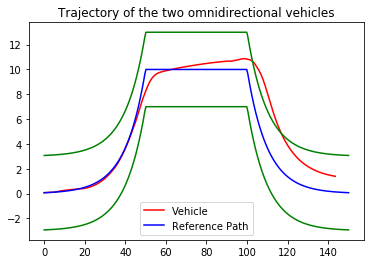

In [99]:
posx = []
posy = []
v = []
theta = []
for i in agent_traj:
    posx.append(i[0][0])
    posy.append(i[0][1])
    v.append(i[0][2])
    theta.append(i[0][3])
    
posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]

_ = plt.title("Trajectory of the two omnidirectional vehicles")
_ = plt.plot(posx, posy, "r")
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend(["Vehicle", "Reference Path"])

Now implement the MPSC guided controller. MPSC solves feasiblity problem to verify the safety of each output of the regression model. Once the output is unsafe, then MPC solves an optimal control and overrides the regression model.

In [136]:
N = len(x_path)
H = 30  # Number of time steps in trajectory.
n = 30
n_init = 0
#n_end = 250
n_end = N - H - 1
x0 = x_path[n_init]  # Initial state.
# Random initial action path.
us_init = np.zeros((n - 1, dynamics.action_size))

J_hist = []
nn_traj = []
mpc_traj= []
traj = []

for i in range(n_init, n_end):
    print(">>>>>Step {} at {}".format(i, x0))
    x_path_ = x_path[i: i + H]
    x_nn = []
    for j in [x0] + x_path_[0 : n]:
        for k in j:
            x_nn.append(k)
    u = agent.run([x_nn])
    #print("NN outputs control")
    agent_traj = agent_traj + [[x0, u[0, :]]]
    x0_ = dynamics.f(x0, u[0], i)
    #print("Get next state")

    if i <= N - H - 1:
        n_ilqr =  H 
    else:
        n_ilqr = N - i - 1
    x_path_ilqr = x_path[i + 1: i + 1 + n_ilqr]
    #us_init = np.random.uniform(-1, 1, (n_ilqr - 1, dynamics.action_size))
    
    cost_ = CarCost(Q = Q, q = q, \
                   R = R, r = r, \
                   A = A, b = b, \
                   q1 = q1, q2 = q2, \
                   x_path = x_path_ilqr, \
                   x_nominal = nominal)
    ilqr_ = iLQR(dynamics, cost_, n_ilqr - 1)
    xs, us = ilqr_.fit(x0_, us_init, on_iteration=on_iteration)
    #print("MPC verifying")
    
    
    if (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                   <= 0)).all() == True and \
        (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[1,0]\
                  <= 0)).all() == True:
        traj.append([x0, u[0, :]])
        nn_traj.append(traj[-1])
        print("Utilize NN output {}".format(u))
    else:
        max_itr = 5
        while (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                   <= 0)).any() == False or \
        (np.squeeze(\
        (xs - np.array([[x[0], nominal(x[0])[0], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[1,0]\
                  <= 0)).any() == False :
            if max_itr == 0:
                break
            max_itr -= 1    
            cost = CarCost(Q = Q, q = q, \
                   R = R, r = r, \
                   A = A, b = b, \
                   q1 = q1, q2 = q2, \
                   x_path = x_path_, \
                   x_nominal = nominal)
            ilqr = iLQR(dynamics, cost, H)
            xs, us = ilqr.fit(x0, us_init, on_iteration=on_iteration)
        traj.append([x0, us[0]])
        mpc_traj.append(traj[-1])
        x0_ = dynamics.f(x0, us[0], i)
        print("Utilize MPC output {}".format(us[0]))
    x0 = x0_[0][:]

>>>>>Step 0 at [0.0, 0.06737946999085467, 10, 0.006737845034422798]
iteration 0 accepted [0.02917407] [15.01920967  0.29544211 10.01279303  0.02235436] [-0.00053448 -0.00297075]
Utilize NN output [[0.31843686 0.00750294]]
>>>>>Step 1 at [ 0.50037376  0.07075096 10.01540464  0.01048924]
iteration 0 accepted [0.03648636] [15.530946    0.31070101 10.01728897  0.02209918] [-0.00050057 -0.00413014]
Utilize NN output [[ 0.31082064 -0.00971172]]
>>>>>Step 2 at [1.00149290e+00 7.60075151e-02 1.00304638e+01 5.62605374e-03]
iteration 0 accepted [0.0552487] [16.04320249  0.32672517 10.02165384  0.02317564] [-0.00046045 -0.00438979]
Utilize NN output [[3.0839422e-01 1.2876838e-04]]
>>>>>Step 3 at [1.50338187e+00 7.88311992e-02 1.00454126e+01 5.69063408e-03]
iteration 0 accepted [0.0862953] [16.55603807  0.343656   10.02590927  0.02507623] [-0.00041346 -0.00411319]
Utilize NN output [[0.30798423 0.00602156]]
>>>>>Step 4 at [2.00601761e+00 8.16915462e-02 1.00603427e+01 8.71505081e-03]
iteration 0 ac

iteration 60 accepted [8.48705404] [32.8387092   1.76275162 10.12624963  0.16715578] [-0.00660233  0.        ]
Utilize NN output [[0.139034   0.00900358]]
>>>>>Step 36 at [18.39850902  0.3793394  10.39165085  0.01846795]
iteration 0 accepted [10.82088542] [33.56502499  1.80441907 10.06623404  0.12631047] [ 0.00467208 -0.02663563]
Utilize NN output [[0.13767263 0.00950203]]
>>>>>Step 37 at [18.91817395  0.38893764 10.39849132  0.02340489]
iteration 0 accepted [11.53087837] [34.07874587  1.89941399 10.06618563  0.13376442] [ 0.00483533 -0.02731514]
Utilize NN output [[0.13636698 0.00940092]]
>>>>>Step 38 at [19.43812548  0.40110927 10.40526771  0.02829252]
iteration 0 accepted [12.26748875] [34.59190409  1.99921462 10.06615688  0.14152906] [ 0.00499627 -0.02808279]
Utilize NN output [[0.13503468 0.00934248]]
>>>>>Step 39 at [19.95834836  0.41583161 10.41197871  0.03315292]
iteration 0 accepted [13.03013813] [35.10442207  2.10406985 10.06615766  0.14962874] [ 0.0051542  -0.02893658]
Utili

Utilize NN output [[0.28244838 0.01936927]]
>>>>>Step 74 at [38.15074789  2.99643158 10.68963881  0.31569201]
iteration 0 accepted [49.18370817] [51.86778708  9.98634754 10.27713769  0.20241379] [-0.00234672  0.032347  ]
Utilize NN output [[0.30992183 0.01551083]]
>>>>>Step 75 at [38.65917357  3.16249109 10.70465711  0.32398161]
iteration 0 accepted [50.26498297] [52.43827773  9.9663243  10.28777045  0.1381481 ] [-0.00286136  0.0530684 ]
Utilize NN output [[0.31162184 0.02496429]]
>>>>>Step 76 at [39.16691892  3.33299915 10.7197527   0.33734054]
iteration 0 accepted [51.19685933] [53.00675401  9.94897364 10.29838177  0.10607052] [-0.00340474  0.06895745]
Utilize NN output [[0.29246417 0.05089656]]
>>>>>Step 77 at [39.6730328   3.5105173  10.73397277  0.36459694]
iteration 0 accepted [52.17740009] [53.55440589  9.93539503 10.30265965  0.08660257] [-0.00339419  0.0745024 ]
Utilize NN output [[0.2923324  0.00186416]]
>>>>>Step 78 at [40.17478492  3.70201612 10.74818677  0.36559743]
iterat

Utilize NN output [[ 0.03369428 -0.01838984]]
>>>>>Step 111 at [5.69132189e+01 9.76202033e+00 1.09410786e+01 5.39423427e-02]
iteration 0 accepted [161.24127524] [7.25674594e+01 9.94610269e+00 1.01813862e+01 1.21390438e-02] [0.00815104 0.00952033]
Utilize NN output [[ 0.03299348 -0.01213828]]
>>>>>Step 112 at [5.74595183e+01 9.79151761e+00 1.09427276e+01 4.73023724e-02]
iteration 0 accepted [166.62613682] [7.31131288e+01 9.93916215e+00 1.01779050e+01 1.09655868e-02] [0.00839969 0.00861763]
Utilize NN output [[ 0.03238592 -0.0082432 ]]
>>>>>Step 113 at [5.80060831e+01 9.81739072e+00 1.09443464e+01 4.27923182e-02]
iteration 0 accepted [172.16380671] [7.36585563e+01 9.93537811e+00 1.01744475e+01 1.02477333e-02] [0.00864661 0.00807127]
Utilize NN output [[ 0.03189205 -0.00500345]]
>>>>>Step 114 at [5.85528393e+01 9.84080198e+00 1.09459404e+01 4.00543679e-02]
iteration 0 accepted [177.85281274] [7.42038723e+01 9.93376666e+00 1.01710305e+01 9.83212963e-03] [0.00889032 0.00776173]
Utilize NN o

Utilize NN output [[ 0.02608826 -0.00035209]]
>>>>>Step 145 at [7.55447221e+01 1.03785583e+01 1.09889352e+01 2.49111536e-02]
iteration 0 accepted [425.49772346] [9.11244007e+01 9.93520656e+00 1.00921594e+01 6.06655056e-03] [0.01425351 0.00506976]
Utilize NN output [[ 0.02608272 -0.00030012]]
>>>>>Step 146 at [7.60940310e+01 1.03922451e+01 1.09902391e+01 2.47462554e-02]
iteration 0 accepted [435.89097125] [9.16712563e+01 9.93572656e+00 1.00903490e+01 6.02653649e-03] [0.01436829 0.00504337]
Utilize NN output [[ 0.02607814 -0.00025228]]
>>>>>Step 147 at [7.66434072e+01 1.04058428e+01 1.09915427e+01 2.46076223e-02]
iteration 0 accepted [446.44192296] [9.22181853e+01 9.93632935e+00 1.00885770e+01 5.99322406e-03] [0.01448009 0.00502241]
Utilize NN output [[ 0.02607409 -0.00020365]]
>>>>>Step 148 at [7.71928506e+01 1.04193661e+01 1.09928461e+01 2.44957027e-02]
iteration 0 accepted [457.15024073] [9.27651838e+01 9.93699948e+00 1.00868431e+01 5.96529254e-03] [0.01458895 0.0050058 ]
Utilize NN o

Utilize NN output [[ 0.02734509 -0.00543113]]
>>>>>Step 179 at [9.42599695e+01 1.07405930e+01 1.10350569e+01 3.20556121e-02]
iteration 0 accepted [815.87934747] [108.42475648   6.35749881  10.05304827  -0.6282886 ] [0.01876096 0.17632888]
Utilize NN output [[ 0.02723982 -0.02116996]]
>>>>>Step 180 at [9.48114730e+01 1.07582778e+01 1.10364186e+01 2.03767687e-02]
iteration 0 accepted [828.90939227] [108.86043729   6.11817365  10.05107434  -0.60498528] [0.01916086 0.17597067]
Utilize NN output [[0.02639806 0.03977059]]
>>>>>Step 181 at [9.53632123e+01 1.07695220e+01 1.10377382e+01 4.23114482e-02]
iteration 0 accepted [835.93444077] [109.3007372    5.84706912  10.05157757  -0.57698653] [0.01936891 0.17148797]
Utilize NN output [[0.0353183  0.02061822]]
>>>>>Step 182 at [9.59146494e+01 1.07928680e+01 1.10395033e+01 5.36887622e-02]
iteration 0 accepted [825.54360308] [109.74839145   5.4582333   10.05791804  -0.54057742] [0.01906653 0.15589693]
Utilize NN output [[ 0.04116092 -0.0384234 ]]
>>

Utilize NN output [[0.0469423  0.01343067]]
>>>>>Step 215 at [110.79904173   5.8406398   11.10756817  -0.40142416]
iteration 0 accepted [169.22098913] [124.49819544   0.27631464  10.29269155  -0.18522457] [ 0.00475213 -0.0567301 ]
Utilize NN output [[0.04470985 0.01728269]]
>>>>>Step 216 at [111.310322     5.62361515  11.10980218  -0.39182668]
iteration 0 accepted [179.14940875] [125.10143579   0.20946674  10.28577313  -0.17822769] [ 0.00518365 -0.05565025]
Utilize NN output [[0.0427108  0.01970393]]
>>>>>Step 217 at [111.82376252   5.41146571  11.11193642  -0.38088275]
iteration 0 accepted [189.99482172] [125.70858429   0.1489079   10.27899089  -0.17107446] [ 0.00559809 -0.05424365]
Utilize NN output [[0.04098075 0.02212204]]
>>>>>Step 218 at [112.33959104   5.20490906  11.11398431  -0.36859382]
iteration 0 accepted [201.64310124] [ 1.26317781e+02  9.41314517e-02  1.02724010e+01 -1.63936149e-01] [ 0.00599403 -0.05264892]
Utilize NN output [[0.03943499 0.02332225]]
>>>>>Step 219 at [11

Utilize NN output [[0.0235036  0.00740916]]
>>>>>Step 249 at [ 1.29180010e+02  1.69867465e+00  1.11581868e+01 -8.41430948e-02]
iteration 0 accepted [748.41835541] [ 1.44633920e+02 -2.07540441e-01  1.01623315e+01 -3.54151807e-02] [ 0.01169182 -0.01232443]
Utilize NN output [[0.02339343 0.00705629]]
>>>>>Step 250 at [ 1.29735974e+02  1.65178335e+00  1.11593562e+01 -8.02063898e-02]
iteration 0 accepted [768.9906155] [ 1.45204312e+02 -2.03682736e-01  1.01606873e+01 -3.37192521e-02] [ 0.01175621 -0.01176374]
Utilize NN output [[0.0232925  0.00669665]]
>>>>>Step 251 at [ 1.30292178e+02  1.60707640e+00  1.11605207e+01 -7.64699288e-02]
iteration 0 accepted [789.73806256] [ 1.45774140e+02 -1.99768589e-01  1.01591002e+01 -3.21078984e-02] [ 0.011817   -0.01123101]
Utilize NN output [[0.02320078 0.00636181]]
>>>>>Step 252 at [ 1.30848602e+02  1.56444355e+00  1.11616805e+01 -7.29199219e-02]
iteration 0 accepted [810.66229722] [ 1.46343439e+02 -1.95822529e-01  1.01575676e+01 -3.05771332e-02] [ 0.011

The red curve in the plot is the trajecotry of the hybrid controller. It can be seen that the vehicle still drive out of the lane boundaries even with the existence of the MPSC. It is because horizon being 30 is too short to predict the unsafe outcome and prevent the vehicle from moving out of the boundary.

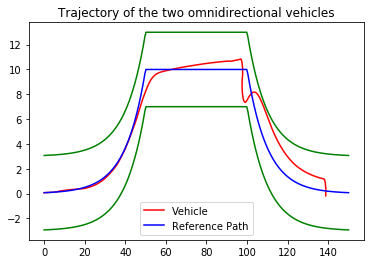

In [137]:
posx = []
posy = []
v = []
theta = []
for i in traj:
    posx.append(i[0][0])
    posy.append(i[0][1])
    v.append(i[0][2])
    theta.append(i[0][3])
    
posx_ = np.asarray(x_path)[:, 0]
posy_ = np.asarray(x_path)[:, 1]

_ = plt.title("Trajectory of the two omnidirectional vehicles")
_ = plt.plot(posx, posy, "r")
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_ + 3.0, 'g')
_ = plt.plot(posx_, posy_ - 3.0, 'g')
_ = plt.legend(["Vehicle", "Reference Path"])



The red dots are the steering commands output by the regression model while the blue dots are from the MPC.

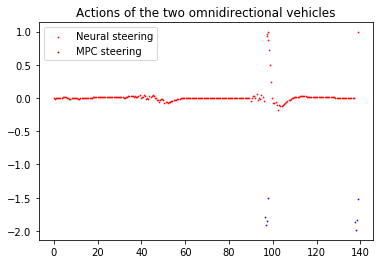

In [135]:

str_nn = []
posx_nn = []
str_mpc = []
posx_mpc = []
for i in nn_traj:
    posx_nn.append(i[0][0])
    str_nn.append(i[1][1])
for j in mpc_traj:
    posx_mpc.append(j[0][0])
    str_mpc.append(j[1][1])
    

_ = plt.title("Actions of the two omnidirectional vehicles")
_ = plt.scatter(posx_nn, str_nn, s = 0.5, c = "r")
_ = plt.scatter(posx_mpc, str_mpc, s = 0.5, c = "b")
_ = plt.legend(["Neural steering", "MPC steering"])

MPSC Guided Learning
=====================

I have considered two algorithms different from what we have discussed. Instead of filtering the learning-based controller's output during deploying phase, MPC can be used as a filter during training phase. The ultimate goal is that the learning model maintains high performance while avoiding performing unsafe behavior.

The basic set up is that the environment has state space $X$, control space $U$ as well as the known, perhaps nonlinear dynamics $x_{k+1} = f(x_k, u_k)$ where $x_k,u_k$ are current state and action pairs and $x_{k+1}$ is next state. Given a learning based controller $g:X\times \Theta\rightarrow U$ where $\Theta$ is the parameter space, a set of trajectories $\{\tau_i|\tau_i=(x^{(i)}_0, u^{(i)}_0, x^{(i)}_1, u^{(i)}_1, \ldots)\}$ can be obtained by executing $g$. Define the convex set of safe states $\{x|x\in X, UNSAFE(x)\leq 0\}$. Assume that an unsafe controller $g$ is at hand. It can generate at least one trajectory $\tau=(x_0, a_0, x_1, a_1, \ldots x_T, a_T\}$ that reaches an unsafe state.

The algorithm is inspired by the motivation of iLQR, which is to linearize the nonlinear dynamics. Given one trajectory $\tau$, a perturbation can be added to this trajectory, i.e. $x_k\rightarrow x_k + \delta x_k, u_k\rightarrow u_k +\delta u_k$. Then the relationship between $\delta x_k,\delta u_k$ can be obtained as follows.

\begin{eqnarray}
x_{k+1} &=& f(x_k, u_k)\\
x_{k+1} \delta x_{k+1} &=& f(x_k+\delta x_k, u_k + \delta u_k) \\
\delta x_{k+1} &=& f(x_k+\delta, u_k + \delta u_k) - f(x_k, u_k)\\
&\approx& \nabla_x f(x_k, u_k) \delta x_k + \nabla_u f(x_k, u_k) \delta u_k
\end{eqnarray}


<h2>MPSC Guided Policy Search</h2>

Usually, learning-based controller upates its model parameter iteratively during the training phase. We can use MPSC to filter the update. It is already known that $u_k=g(x_k, \theta)$.Then the following equation holds.

\begin{eqnarray}
u_k &=& g(x_k, \theta)\\
u_k + \delta u_k &=& g(x_k + \delta x_k, \theta + \delta \theta)\\
\delta u_k &\approx& \nabla_x g(x_k, \theta) \delta x_k + \nabla_\theta g(x_k, \theta) \delta \theta
\end{eqnarray}

Then interpolate it into the linearized dynmics. 
$$\delta x_{k+1} \approx [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x g(x_k, \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta g(x_k, \theta) \delta \theta$$


At this end, we can determine our MPSC problem as, finding the minimal perturbation on the learning model parameters such that the unsafe trajecotries becomes safe.
\begin{eqnarray}
\underset{\delta\theta}{min}&&||\delta \theta||_2^2 \\
s.t. && \delta x_{k+1} = [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x g(x_k, \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta g(x_k, \theta) \delta \theta\qquad k=0, 1, 2, \ldots, T\\
&& \delta x_0 = 0\\
&& UNSAFE(x_k+\delta x_k)\leq 0\qquad k=0, 1, 2, \ldots, T
\end{eqnarray}

In practice, the solved $\delta \theta$ can be applied to the learning model parameter in every iteration. For instance, when using policy gradient to train a parameterized policy $\pi_\theta: X\rightarrow U$, after every gradient step $\theta_{i-1} \rightarrow \theta_{i}$, the resulted policy $\pi_{\theta_i}$ is used to generated samples for the next optimization. Then MPC formulated above can be implemented to the unsafe trajectories (or multiple trajecotries nearby the unsafe set) to further update the policy parameter $\theta_i\rightarrow \theta_i + \delta \theta_i$. 




<h2>MPSC Guided Imitation Learning</h2>


Following the afformentioned basic setup, we can use MPSC in imitation learning, not to perturb the model parameter, but perturb the cost function based on the intermediate sample trajectories. 
It is known that the original IRL formula is 
$$\underset{c}{min}\ \underset{\pi}{max}\ \mathbb{E}_{\pi_E}[c(x, u)] - \mathbb{E}_{\pi} [c(x, u)]$$

It is common in model-free approaches that whenever a new intermediate policy $\pi_{\theta_i}$ is obtained, a set of corresponding sample trajecotries are generated to compare with the expert trajectories $E$ and update the cost function. For instance, in WGAN formulated GAIL, the update of the discriminator $D: X\times U\times W\rightarrow \mathbb{R}$ with parameter space $W$ is as follows.

$$\underset{w\in W}{min}\ \mathbb{E}_{(x,u)\sim \pi_E}[D(x, u, w)] - \mathbb{E}_{(x,u)\sim\pi_{\theta_i}} [D(x, u, w)]$$




Our first step is to find the minimal perturbation to the unsafe intermediate sample trajectories while maintaining high performance. Given an unsafe trajecotry $\tau=(x_0,u_0, \ldots, x_T, u_T)$, the quadratic cost matrices $Q, R$ standard for iLQR are obtained from the current cost $D(, ,w_{i-1})$. Then the MPSC problem is as follows.
\begin{eqnarray}
\underset{\delta x, \delta u}{min} && \delta x^T Q \delta x + \delta u^T R \delta u \\
s.t. && \delta x_{k+1} \approx \nabla_x f(x_k, u_k) \delta x_k + \nabla_u f(x_k, u_k) \delta u_k \qquad k=0, 1, 2, \ldots, T\\
&& \delta x_0 = 0\\
&& UNSAFE(x_k+\delta x_k)\leq 0\qquad k=0, 1, 2, \ldots, T
\end{eqnarray}

Then a constraint can be added to the optimal cost problem such that the perturbed trajecotry $\tau+\delta\tau$ has lower cost than $\tau$. 

\begin{eqnarray}
\underset{w}{min}& &\mathbb{E}_{(x,u)\sim \pi_E}[D(x, u, w)] - \mathbb{E}_{(x,u)\sim\pi_{\theta_i}} [D(x, u, w_{i-1})]\\
s.t. && \sum_{(x_k+\delta x_k,u_k + \delta u_k)\in \tau+\delta_\tau} D(x_k + \delta x_k,u_k + \delta u_k, w) - \sum_{(x_k,u_k)\in \tau} D(x_k,u_k, w)  \leq 0
\end{eqnarray}

However, since $\tau$ is optimal w.r.t the $\pi_{\theta_i}$ which is optimal w.r.t $D(,, w_{i-1})$, the constraint is mostly unlike to be satisfied under $w_{i-1}$. In other word, the constraint of the problem changes in every iteration and the problem can be infeasible in the beginning of every iteration. To simplify the problem, the constraint can be manipulated as follows.

If function $D$ is convex in terms of $x, u$, then subgradient can be used.
\begin{eqnarray}
&&\sum_{(x_k,u_k)\in \tau} D(x_k,u_k, w) - \sum_{(x_k+\delta x_k,u_k + \delta u_k)\in \tau+\delta_\tau} D(x_k+\delta x_k,u_k + \delta u_k, w)  \geq 0\\
&\Rightarrow& \underset{g^{(k)}_i\in \partial_{(x, u)} D(x_k+\delta x_k, u_k + \delta u_k ,w)}{min}\  \sum_{(x_k,u_k)\in\tau} g^{(k)}_i \cdot [-\delta x_k, - \delta u_k]^T\geq 0 
\end{eqnarray}

However, it can be problemetic to find the minimal subgradient in practice. The second proposal does not require convexity to be guaranteed. In every iteration, we can consider two cases. 

If $\sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1}) \geq 0$, which implies that $w_{i-1}$ is feasible, then directly use barrier or penalty method to update $w_{i-1}$. 

If $\sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1}) \leq 0$, then the constraint can be tightened by borrowing the left hand side of the inequality. Assume that a feasible update $\delta w_{i-1}$ on $w_{i-1}$ enables $w_i = w_{i-1} + \delta w_{i-1}$ to satisfy the tightened constraint as below.

\begin{eqnarray}
&&\sum_{\tau+\delta_\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1} + \delta w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1} + \delta w_{i-1})\leq \sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - \sum_{\tau} D(x_k,u_k, w_{i-1}) \\
&&\sum_{\tau+\delta_\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1} + \delta w_{i-1}) - \sum_{\tau + \delta\tau} D(x_k,u_k, w_{i-1}) + \sum_{\tau} D(x_k,u_k, w_{i-1})- \sum_{\tau} D(x_k,u_k, w_{i-1} + \delta w_{i-1})  \leq 0\\
&&\nabla_w \sum_{\tau + \delta\tau} D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1})\delta w_{i-1} - \nabla_w \sum_{\tau} D(x_k,u_k, w_{i-1})\delta  w_{i-1}\leq 0\\
&&\nabla_w \sum_{\tau} [D(x_k + \delta x_k,u_k + \delta u_k, w_{i-1}) - D(x_k,u_k, w_{i-1})]\delta w_{i-1}\leq 0
\end{eqnarray}

As a result, the constraint is linearized. The direction of $\delta w_{i-1}$ can be determined by the gradient of the object while the step length is confined by this linear constraint.
